# Clock-building notebook for beluga methylation array data 

This notebook aims to build clocks from methylation data generated through the Horvath Custom Methylation Array run at UCLA. 


## Import packages 

In [2]:
#import matplotlib for plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl 

#Make fonts 'TrueType' for figures in pdf and ps (avoids font that won't work in many journals)
#This also seemed to be important to get things to show up correctly in Illustrator
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

#import pandas for working with dataframes 
import pandas as pd 
from pandas import DataFrame, read_csv 

#import numpy 
import numpy as np 


#csv reader 
import csv

#import scipy packages
from scipy import stats 
import pylab 

#Enable in-line plotting 
%matplotlib inline


## Import data files & make dataframes

*IMPORTANT:*

As of 10 December 2019, the file that has (1) just probes that start with 'cg' and (2) only individuals with a z-code from SWFSC will be included in the datafile. ALSO, the file has been updated to include data that replaces 'dleu_35281' with 'dleu_35281_KBO'. This is because of results from the HIERARCHICAL CLUSTERING ANALYSIS. 

The total number of whales that will be included in the clock using this data file is n=70. 

In [10]:
# This is a filepath to the 'simple' beluga sesame normalized data in which I've removed the row with ages.
# The file has data for 70 individuals (but including reps!) and only has data for probes starting with 'cg'
sesame_data_path = '/Users/elliebors/Desktop/Beluga/methylation_array/data/normalized_data_July2019/simple_beluga_sesame_normalized_betas_cg_only_n70_hierarchFixed.csv'

beluga_sesame_df = pd.read_csv(sesame_data_path, sep=',', index_col=0)

## Uncomment line below to view your dataframe 
#beluga_sesame_df


### Metadata (age, sex, etc.) 

In [11]:
#File path to a data file that has the following metadata for every sample, including the averaged replicates: 
# (1) age (note: Tooth age. Updated to reflect the one age error we found (sample ####))
# (2) sex (note: updated with molecular sex data)
# (3) binary_sex: a column where 1=female and 0=male
# (3) whale_length 

metadata_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/beluga_metadata.csv'

beluga_metadata_df = pd.read_csv(metadata_filepath, sep = ',', index_col=0)

## Uncomment line below to view your dataframe
beluga_metadata_df


age  binary_sex sex  ConfidenceInAgeEstimate  \
sampleID                                                            
dleu_1335           18.0           0   m                  0.75000   
dleu_4195           23.0           1   f                  0.66666   
dleu_4360           18.0           0   m                  0.75000   
dleu_4361           17.0           0   m                  0.75000   
dleu_5316           23.0           1   f                  0.66666   
dleu_5381           22.0           1   f                  0.66666   
dleu_9798           26.0           1   f                  0.66666   
dleu_9799           25.0           0   m                  0.66666   
dleu_9800           20.0           0   m                  0.75000   
dleu_10918          17.0           1   f                  1.00000   
dleu_35279          22.0           0   m                  0.66666   
dleu_70583          49.0           0   m                  0.40000   
dleu_144309_KP      39.0           1   m                  0.40000   
dleu_692_BLKA_074    0.5           1   f                  1.00000   
dleu_1336           35.0           0   m                  0.40000   
dleu_4107           23.0           0   m                  0.66666   
dleu_4108            2.0           1   f                  1.00000   
dleu_4109           19.0           1   f                  0.75000   
dleu_5428           29.0           1   f                  0.40000   
dleu_13507          17.0           1   f                  0.75000   
dleu_25494_08       21.0           1   f                  1.00000   
dleu_25495_08        0.1           1   f                  1.00000   
dleu_41732           9.0           0   m                  1.00000   
dleu_41745_06       21.0           0   m                  0.66666   
dleu_70581          30.0           1   f                  0.40000   
dleu_77292          10.0           1   f                  1.00000   
dleu_79633_06       37.0           1   f                  0.40000   
dleu_113072         15.0           0   m                  0.75000   
dleu_144309_13      39.0           0   m                  0.40000   
dleu_156874         20.0           0   m                  0.75000   
...                  ...         ...  ..                      ...   
dleu_35280          20.0           0   m                  0.75000   
dleu_35281_KBO      26.0           0   m                  0.66666   
dleu_35281          26.0           0   m                  0.66666   
dleu_35344          22.0           1   f                  0.66666   
dleu_35345           1.0           0   m                  0.75000   
dleu_35853          28.0           0   m                  0.66666   
dleu_39050          23.0           1   f                  0.66666   
dleu_41745_07       21.0           0   m                  0.66666   
dleu_47973          30.0           0   m                  0.66666   
dleu_74693          32.0           1   f                  0.66666   
dleu_88661          16.0           1   f                  0.75000   
dleu_91065          14.0           1   f                  0.75000   
dleu_91066          27.0           1   f                  0.66666   
dleu_91067           6.0           0   m                  1.00000   
dleu_143907         41.0           0   m                  0.40000   
dleu_156870         40.0           0   m                  0.40000   
dleu_156873         40.0           0   m                  0.40000   
dleu_16605          10.0           0   m                  1.00000   
dleu_25494_16       21.0           1   f                  0.75000   
dleu_25495_16        0.1           1   f                  1.00000   
dleu_79633_13       37.0           1   f                  0.40000   
dleu_28926_B        22.0           0   m                  0.66666   
dleu_32512_B        -1.0           1   f                  1.00000   
dleu_41745_avg      21.0           0   m                  0.66666   
dleu_25494_avg      21.0           1   f                  0.75000   
dleu_25495_avg     

### Import genome mapping data 

Coordinates from UCLA team.

In [12]:

# A file that has the beluga genome coordinates for probes mapped exactly + uniquely (analysis by M Thompson)
unique_mapping_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/site_information/Dleu_unique_probe_locations_cgonly.csv'

# A file that has the beluga genome coordiantes for probes mapped exactly + multiple times (analysis by M Thompson)
# This file has multiple columns with coordinates 1, 2, 3.... 
ambiguous_mapping_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/site_information/Dleu_ambiguous_probe_locations.csv'

# Make a unique mapped dataframe 
unique_mapping_df = pd.read_csv(unique_mapping_filepath, sep = ',', index_col=0)
# Ensure that the scaffold coordinate (scaff_coord) column has values that are strings 
unique_mapping_df['scaff_coord'] = unique_mapping_df['scaff_coord'].astype('str')

# Make an 'ambigous' mapped dataframe 
ambiguous_mapping_df = pd.read_csv(ambiguous_mapping_filepath, sep = ',', index_col=0)

#unique_mapping_df
#ambiguous_mapping_df

## Subsetting data for replicate info and p-value filtering 

In some of our original data, we ran samples multiple times. Here, I generated numerous versions of the data to trial running the data with different replicates. I also trialed averaging replicate data, which is shown in the next cell. 

In [13]:
## Make new columns in the beluga_sesame_df that are averages of replicate samples
# Note that the sequential replicates are already removed from this spreadsheet. 

beluga_sesame_df['dleu_32512_avg'] = (beluga_sesame_df['dleu_32512_A'] + beluga_sesame_df['dleu_32512_B'])/2
beluga_sesame_df['dleu_79633_avg'] = (beluga_sesame_df['dleu_79633_13'] + beluga_sesame_df['dleu_79633_06'])/2
beluga_sesame_df['dleu_28926_avg'] = (beluga_sesame_df['dleu_28926_A'] + beluga_sesame_df['dleu_28926_B'])/2
beluga_sesame_df['dleu_25495_avg'] = (beluga_sesame_df['dleu_25495_08'] + beluga_sesame_df['dleu_25495_16'])/2
beluga_sesame_df['dleu_25494_avg'] = (beluga_sesame_df['dleu_25494_08'] + beluga_sesame_df['dleu_25494_16'])/2
beluga_sesame_df['dleu_144309_avg'] = (beluga_sesame_df['dleu_144309_13'] + beluga_sesame_df['dleu_144309_KP'])/2
beluga_sesame_df['dleu_41745_avg'] = (beluga_sesame_df['dleu_41745_06'] + beluga_sesame_df['dleu_41745_07'])/2

#beluga_sesame_df

In [16]:
## Making unique lists that enable me to remove outliers from different parts of the analysis. 


samples = []
for i in beluga_sesame_df.columns: 
    samples.append(i)
# print(len(samples))

# Define lists of sample replicates that will be removed from the whole list of samples available in the data file

sesame_KBO_samp_69_exclusion = ['dleu_32512_A','dleu_79633_06', 'dleu_28926_A', 'dleu_25495_08', 'dleu_25494_08', 
                              'dleu_144309_KP', 'dleu_41745_06', 'dleu_32512_avg', 'dleu_79633_avg', 'dleu_28926_avg',
                              'dleu_25495_avg', 'dleu_25494_avg', 'dleu_144309_avg', 'dleu_41745_avg',  
                              'dleu_35281', 'dleu_34578'] 

# The following lines of code to 3 things: 
# ... (1) define new lists of sample names to acheive the three different ways of dealing with replicates 
# ... (2) define a dataframe of beta values for the subset of samples in your lists 
# ... (3) export a csv file of the beta values for the samples you want


sesame_KBO_samp_69_sample_names = [samp for samp in samples if samp not in sesame_KBO_samp_69_exclusion]
sesame_KBO_samp_69 = beluga_sesame_df[sesame_KBO_samp_69_sample_names]
sesame_KBO_samp_69.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/sesame_KBO_samp_69.csv')
print(len(sesame_KBO_samp_69.columns))

#sesame_KBO_samp_69_sample_names

69


### p-value filtering 

Find CpGs that had good detection pValues on the array and filter for those

NOTE: Because the final dataset we are using has 69 samples, we are only going to run the p-value filtering on those individuals. 

In [17]:
# Load in a file that has the pVlaues for JUST the 69 beluga (or for all beluga -- the top file path)

#sesame_detection_pValue_filepath = "/Users/elliebors/Desktop/Beluga/methylation_array/data/sesame_pValues_22Dec2019/beluga_detection_p_values_sesame_EKB_IDs.csv"
sesame_detection_pValue_filepath = "/Users/elliebors/Desktop/Beluga/methylation_array/data/sesame_pValues_22Dec2019/calibration_beluga_detection_p_values_sesame_EKB_IDs.csv"

# Make a dataframe of all the pValues JUST FOR THE n = 69 Dataset!
sesame_detection_pValue_df = pd.read_csv(sesame_detection_pValue_filepath, index_col=0)

# Un-comment and move down if you'd like to see all the pValues in the df.
#sesame_detection_pValue_df

#Makes a dataframe that consists of boolean expressions: True if the pValue is <= 0.05; False if the pValue >0.05. 
significant_pValues = (sesame_detection_pValue_df.iloc[0:] <=0.05)

#This row reminds you how many samples are in the database you're using. Should match #samples in your spreadsheet. 
print("We are testing pValues for",len(significant_pValues.iloc[1]),"samples.")


## To be 'good,' there must be one or more samples that have a pValue <0.05. 

#Make an exmpty list that you'll fill with the names of bad probes
bad_probes = []

for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes.append(i)

print("There are", len(bad_probes), "for which all samples have a p-value > 0.05.")
      
## Get a list of the "Good Probes," which are the ones that had all pValues over 0.05. 
all_probes = []
for i in sesame_detection_pValue_df.index: 
    all_probes.append(i)

good_probes = [probe for probe in all_probes if probe not in bad_probes]
print("There are",len(good_probes),"probes that passed for 'good_probes'.")
#good_probes


## To be good, there must be 10 or more samples for which the pValue is <0.05. 

bad_probes_max10good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max10good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-10):
        bad_probes_max10good.append(i) 
print("There are", len(bad_probes_max10good), "probes for which minimum 10 samples had a pValue <0.05.")

good_probes_max10good = [probe for probe in all_probes if probe not in bad_probes_max10good]
print("There are",len(good_probes_max10good),"probes that passed for 'good_probes_max10good'.")


## To be good, there must be 20 or more samples for which the pValue is <0.05. 

bad_probes_max20good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max20good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-20):
        bad_probes_max20good.append(i) 
print("There are", len(bad_probes_max20good), "probes for which minimum 20 samples had a pValue <0.05.")

good_probes_max20good = [probe for probe in all_probes if probe not in bad_probes_max20good]
print("There are",len(good_probes_max20good),"probes that passed for 'good_probes_max20good'.")

## To be good, there must be 30 or more samples for which the pValue is <0.05. 

bad_probes_max30good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max30good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-30):
        bad_probes_max30good.append(i) 
print("There are", len(bad_probes_max30good), "probes for which minimum 30 samples had a pValue <0.05.")

good_probes_max30good = [probe for probe in all_probes if probe not in bad_probes_max30good]
print("There are",len(good_probes_max30good),"probes that passed for 'good_probes_max30good'.")

## To be good, there must be 40 or more samples for which the pValue is <0.05. 

bad_probes_max40good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max40good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-40):
        bad_probes_max40good.append(i) 
print("There are", len(bad_probes_max40good), "probes for which minimum 40 samples had a pValue <0.05.")

good_probes_max40good = [probe for probe in all_probes if probe not in bad_probes_max40good]
print("There are",len(good_probes_max40good),"probes that passed for 'good_probes_max40good'.")

## To be good, there must be 50 or more samples for which the pValue is <0.05. 

bad_probes_max50good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max50good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-50):
        bad_probes_max50good.append(i) 
print("There are", len(bad_probes_max50good), "probes for which minimum 50 samples had a pValue <0.05.")

good_probes_max50good = [probe for probe in all_probes if probe not in bad_probes_max50good]
print("There are",len(good_probes_max50good),"probes that passed for 'good_probes_max50good'.")

## To be good, there must be 60 or more samples for which the pValue is <0.05. 

bad_probes_max60good = []
for i in significant_pValues.index:
    significance_booleans = significant_pValues.loc[i]
    false_list = []
    for j in significance_booleans: 
        if j == False:
            false_list.append(i)
    if len(false_list)== len(significant_pValues.loc[i]):
        bad_probes_max60good.append(i)
    # You can add in a certain number of good pValues in a row and still eliminate the row this way:
    elif len(false_list)>= (len(significant_pValues.loc[i])-60):
        bad_probes_max60good.append(i) 
print("There are", len(bad_probes_max60good), "probes for which minimum 60 samples had a pValue <0.05.")

good_probes_max60good = [probe for probe in all_probes if probe not in bad_probes_max60good]
print("There are",len(good_probes_max60good),"probes that passed for 'good_probes_max60good'.")

We are testing pValues for 69 samples.
There are 6056 for which all samples have a p-value > 0.05.
There are 31432 probes that passed for 'good_probes'.
There are 8705 probes for which minimum 10 samples had a pValue <0.05.
There are 28783 probes that passed for 'good_probes_max10good'.
There are 9477 probes for which minimum 20 samples had a pValue <0.05.
There are 28011 probes that passed for 'good_probes_max20good'.
There are 10143 probes for which minimum 30 samples had a pValue <0.05.
There are 27345 probes that passed for 'good_probes_max30good'.
There are 10951 probes for which minimum 40 samples had a pValue <0.05.
There are 26537 probes that passed for 'good_probes_max40good'.
There are 11855 probes for which minimum 50 samples had a pValue <0.05.
There are 25633 probes that passed for 'good_probes_max50good'.
There are 13521 probes for which minimum 60 samples had a pValue <0.05.
There are 23967 probes that passed for 'good_probes_max60good'.


The next cell (and those after it) takes a long time to run. It makes a dataframe that contains the probes that had at least one calibration individual with a good pValue, e.g., all probes for which all samples had a pValue>0.05 were removed. 

In [15]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which all samples had to have a pValue > 0.05 to exclude the probe: 

pValue_bad_removed_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes:
    pValue_bad_removed_KBO_samp_69_df = pValue_bad_removed_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_bad_removed_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_bad_removed_KBO_samp_69.csv')


In [22]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 10 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_10good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max10good:
    pValue_10good_KBO_samp_69_df = pValue_10good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_10good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_10good_KBO_samp_69.csv')


In [23]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 20 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_20good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max20good:
    pValue_20good_KBO_samp_69_df = pValue_20good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_20good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_20good_KBO_samp_69.csv')


In [24]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 30 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_30good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max30good:
    pValue_30good_KBO_samp_69_df = pValue_30good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_30good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_30good_KBO_samp_69.csv')


In [25]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 40 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_40good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max40good:
    pValue_40good_KBO_samp_69_df = pValue_40good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_40good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_40good_KBO_samp_69.csv')


In [26]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 50 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_50good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max50good:
    pValue_50good_KBO_samp_69_df = pValue_50good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_50good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_50good_KBO_samp_69.csv')


In [27]:
#### WARNING: Takes a long time to run! Slow for loop!

# For the case in which 60 samples or more had to have a pValue > 0.05 to exclude the probe: 

pValue_60good_KBO_samp_69_df = pd.DataFrame(columns=sesame_KBO_samp_69.columns)
for i in good_probes_max60good:
    pValue_60good_KBO_samp_69_df = pValue_60good_KBO_samp_69_df.append(sesame_KBO_samp_69.loc[i])

pValue_60good_KBO_samp_69_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/pValue_60good_KBO_samp_69.csv')


## Mapping data into dataframes

The next cell deals with mapping. 

In [18]:
# Filter the data files for CpGs that mapped exactly & uniquely

cpg_list_from_mapped_datafile = unique_mapping_df.index[0:]

ambiguously_mapped_cpgs = ambiguous_mapping_df.index[0:]

unique_mapped_cpgs = []
any_mapped_cpgs = []
for i in cpg_list_from_mapped_datafile: 
    if unique_mapping_df.loc[i]['scaff_coord']!=':':
        unique_mapped_cpgs.append(i)
        any_mapped_cpgs.append(i)

for i in ambiguously_mapped_cpgs:
    any_mapped_cpgs.append(i)

print('The total number of CpGs on the arrray is', len(cpg_list_from_mapped_datafile))
print('The number of CpGs mapped uniquely is', len(unique_mapped_cpgs))
print('The number of CpGs mapped in any way (ambigously or uniquely) is', len(any_mapped_cpgs))

#unique_mapped_cpgs
#any_mapped_cpgs

The total number of CpGs on the arrray is 37488
The number of CpGs mapped uniquely is 25482
The number of CpGs mapped in any way (ambigously or uniquely) is 25834


In [19]:
# Compare CpG lists from the mapping data and the sesame normalized data 
print (len(beluga_sesame_df.index))
print(len(unique_mapping_df.index))

# Initially there was some discrepancy int he length of the files because of some control probes etc. 
# If there is some discrepancy in the length of the sesame data and the mapping data, see what the probes are with: 
list(set(sesame_data_reps_avg.index) - set(unique_mapping_df.index))

37488
37488


[]

## Make age vectors and sex vectors

In [20]:
### FUNCTION ###
### make_age_vector ###

# This function takes the following arguments: 
# (1) sample_name_list = a list of the sample names you want to include in your age vector
# (2) metadata_dataframe_name = a metadata dataframe with a column 'age' containing an age value for every sample indexed by sample name 
# (3) the name of the output file you want to create... this could be an entire path to another directory. 
# This creates an 'age vector' that matches the order of the data in the beta file - to be used in glmnet() in R. 

def make_age_vector(sample_name_list, metadata_dataframe_name, output_file_name):
    #Make empty vector to fill 
    age_vector = []
    
    #Populate the vector with values corresponding to the sample names you are targeting 
    for samp in sample_name_list:
        age_vector.append(float(metadata_dataframe_name.loc[samp]['age']))
        
    #A check that your age vector matches your # of samples
    print ('There are', len(age_vector), 'items in', output_file_name)
    
    #The next part saves the list as a csv file where the values are separated by a comma in one line 
    with open(output_file_name, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(age_vector)
    
    #The function will, in addition to making a csv, return a list in python that you can use later
    #This list can be defined when you run the function (e.g. list_name = make_age_vector())
    return age_vector

###


There are 69 items in sesame_KBO_samp_69_age_vector.csv
22.0


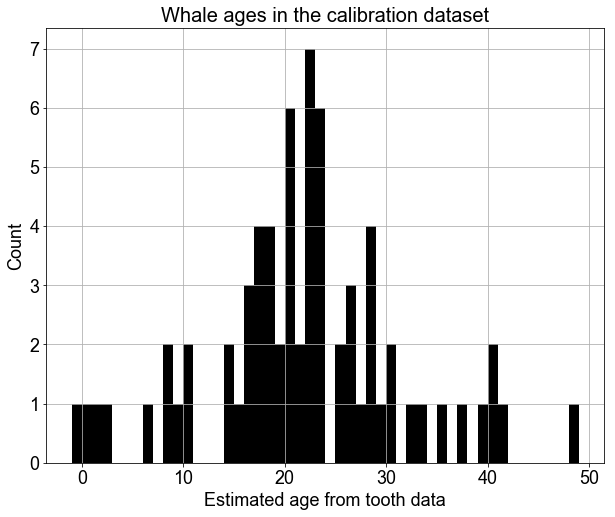

In [32]:
# Make age vector csv files for R inputs 

sesame_KBO_samp_69_age_vector = make_age_vector(sesame_KBO_samp_69_sample_names, beluga_metadata_df, 'sesame_KBO_samp_69_age_vector.csv')

ages_df = pd.DataFrame(columns=['age'])
ages_df['age']= sesame_KBO_samp_69_age_vector
ages_df.hist(column='age', figsize=(10,8), color = 'Black', bins= 50, xlabelsize=18, 
                                 ylabelsize = 18)

plt.title('Whale ages in the calibration dataset', fontsize = 20)
plt.xlabel('Estimated age from tooth data', fontsize = 18)
plt.ylabel('Count', fontsize = 18)

#plt.savefig('/Users/elliebors/Desktop/Beluga/manuscripts/beluga_array_ms/calibration_sample_ages_20Jan2020.pdf')

print(np.median(ages_df['age']))

In [22]:
### FUNCTION ###
### make_sex_vector ###

def make_sex_vector(sample_name_list, metadata_dataframe_name, output_file_name):
    #Make empty sex vector to fill 
    sex_vector = []
    
    #Populate the vector with values corresponding to the sample names you are targeting 
    for samp in sample_name_list:
        sex_vector.append(float(metadata_dataframe_name.loc[samp]['binary_sex']))
        
    #A check that your age vector matches your # of samples
    print ('There are', len(sex_vector), 'items in', output_file_name)
    
    #The next part saves the list as a csv file where the values are separated by a comma in one line 
    with open(output_file_name, 'w') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(sex_vector)
    
    #The function will, in addition to making a csv, return a list in python that you can use later
    #This list can be defined when you run the function (e.g. list_name = make_age_vector())
    return sex_vector
###


In [23]:
# Make a sex vector for input into a sex-preditor model in glmnet()

sesame_KBO_samp_69_sample_sex_vector = make_sex_vector(sesame_KBO_samp_69_sample_names, beluga_metadata_df, 'KBO_samp_69_sex_vector.csv')


There are 69 items in KBO_samp_69_sex_vector.csv


## Analysis in R

## Clock Output from R

Note that I have it set so R will output two csv files from cv.glmnet() work: 
(1) clock_cpgs.csv
(2) model_coefficientx.csv 
... These two files are output into a temporary folder:
"Desktop/Beluga/methylation_array/analysis/clock_building/temp/"



### Define Functions

In [36]:
### FUNCTION ### 
### make_epigenetic_clock ###

# Makes a dataframe with the information of the epigeentic clock built from any given model 

# This function takes the following arguments: 
# (1) the path to a csv that has a list of the clock's cpgs 
# (2) the path to a csv that has a list of the clock's coefficients 

# Note that these two files are outputs from the R cv.glmnet() analysis 
# Note that there is definitely a faster way to do this (like in R)! :) 
# The function returns a dataframe with two columns: cpgs and coefficients. 

def make_epigenetic_clock (clock_cpgs_csv_path, clock_coefficients_csv_path):
    # Make dataframes from the R output files 
    clock_cpgs_df = pd.read_csv(clock_cpgs_csv_path)
    clock_coefficients_df = pd.read_csv(clock_coefficients_csv_path)
    
    #Make a list of the CpGs in the clock 
    cpgs = clock_cpgs_df['x']
    
    #Make a list of the coefficients in the clock 
    coefficients = clock_coefficients_df['x']
    
    # The y-intercept will always be in the glmnet R output as the first value in the coefficient list
    yIntercept = coefficients[0]
    print ('The y intercept for this clock model equation is', yIntercept,'.')
    
    current_clock_df = pd.DataFrame(columns=['cpgs', 'coefficients'])
    current_clock_df['cpgs'] = cpgs
    current_clock_df['coefficients'] = coefficients

    return current_clock_df

###


In [37]:
### FUNCTION ### 
### calcualte_whale_ages ###

# Uses the output from glmnet() in the form of a df, calculates the predicted ages, and makes a dataframe for that model. 

# This function takes the following arguments: 
# (1) a list of whale sample names (whale_id_list) that correpond with the columns in a beta data file. 
# (2) the dataframe containing raw data you'd like to use 
# (3) the dataframe containing the current clock values - must have the columns 'cpgs' and 'coefficients'
# (4) a metadata dataframe with chronological age and sex. *Must have an index that is the sample names (sampleID)!

# NOTE that 'cpgs' and 'coefficients' from R glmnet() output have to have been defined outside of this function. 
# One way of defining cpgs and coefficients is to use the function above: make_epigenetic_clock
# This returns a dataframe that has two columns: sampleID and model_ages_df

def calculate_whale_ages(whale_id_list, normalized_beta_dataframe, current_clock_df, beluga_metadata_df): 
    # Calculate how many CpG terms there are in the clock/model 
    cpgs = current_clock_df['cpgs']
    coefficients = current_clock_df['coefficients']
    print ("There are", len(cpgs)-1, "cpgs in the current model")
    # This loops through the *index* of the cpgs to capture each term in the equation. 
    # NOTE: It starts at 1 because the 0 index item is the y-intercept!
    numbers = [i for i in range(1,len(cpgs)-1)]
    model_ages = []
    yIntercept = coefficients[0]
    # The following loop takes each whale and takes the column of beta values for that whale out of your dataframe
    for whale_id in whale_id_list:     
        beta_values_dleu_whale = normalized_beta_dataframe[whale_id]
        # Note that 'calculated_age' is a number that evolves throughout this code as each term of the equation is filled.
        # It starts here as the yIntercept and with the loop below, each term of the equation is added to the value. 
        # This process goes until the final output is the actual calculated age. 
        calculated_age = yIntercept
        
        for i in numbers: 
            #print (beta_values_dleu_whale[cpgs[i]] * coefficients[i])
            calculated_age = calculated_age + (beta_values_dleu_whale[current_clock_df.cpgs[i]] * current_clock_df.coefficients[i])
        
        # You can un-comment the following line to see the numbers as they are calcuated. 
        # print(whale_id, calculated_age)
        model_ages.append(calculated_age)
    model_ages_df = pd.DataFrame(columns=['sampleID', 'sex', 'model_age', 'known_age', 'age_error'])
    model_ages_df['sampleID'] = whale_id_list
    model_ages_df['model_age'] = model_ages
    known_ages = []
    for i in model_ages_df['sampleID']:
        known_ages.append((beluga_metadata_df.loc[i]['age']))
    model_ages_df['known_age'] = known_ages
    sample_sexes =[]
    for i in model_ages_df['sampleID']:
        sample_sexes.append((beluga_metadata_df.loc[i]['sex']))
    model_ages_df['sex']=sample_sexes
    model_ages_df['age_error']= model_ages_df['model_age']-model_ages_df['known_age']
    #Output of this function is a dataframe with whale sampleID and calculated model age
    return model_ages_df

###

In [38]:
### FUNCTION ### 
### make_LOOCV_age_df ###

# This function takes the following arguments: 
# (1) a path to the csv output from my LOOCV R code that contains a column of ages predicted by cv.glmnet in LOOCV
# (2) whale ID list that matches the order of the LOOCV output (must match order!)
# (3) a metadata dataframe with chronological age and sex. *Must have an index that is the sample names (sampleID)!

# This function will return a dataframe that had sampleID, sex, model_age, and known_age. 
# The output df can be used in plotting and analysis functions. 
                         
def make_LOOCV_age_df(LOOCV_ages_path, whale_id_list, beluga_metadata_df):
    
    LOOCV_df = pd.read_csv(LOOCV_ages_path, index_col=0, header = 0)
    LOOCV_ages = []
    for i in LOOCV_df['x']:
        LOOCV_ages.append(i)
    LOOCV_ages_df = pd.DataFrame(columns = ['sampleID', 'sex', 'model_age', 'known_age','age_error'])
    LOOCV_ages_df['sampleID'] = whale_id_list
    LOOCV_ages_df['model_age'] = LOOCV_ages[0:]
    
    known_ages = []
    for i in LOOCV_ages_df['sampleID']:
        known_ages.append((beluga_metadata_df.loc[i]['age']))
    LOOCV_ages_df['known_age'] = known_ages
    
    sample_sexes =[]
    for i in LOOCV_ages_df['sampleID']:
        sample_sexes.append((beluga_metadata_df.loc[i]['sex']))
    LOOCV_ages_df['sex']=sample_sexes
    
    LOOCV_ages_df['age_error']= LOOCV_ages_df['model_age']-LOOCV_ages_df['known_age']
    
    return LOOCV_ages_df

### 

In [39]:
### FUNCTION ###
### plot_model_vs_known_ages ### 

# This function takes the following arguments: 
# (1) the model age data 
# (2) the known age data 
# (3) a path to output the figure 
# (4) optional: clock title. default is 'Model Age vs. Known Age'
# (5) optional: x axis title. defaulat is 'Known age estimate'
# (6) optional: y axis title. default is 'Calculated model age'

## Note - this is a predecessor function to the next two: sex_specific_plot_model_vs_known_ages and sex_specific_clock_plots_and_stats

def plot_model_vs_known_ages(model_age_data, known_age_data, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Known age estimate', y_title = 'Calculated model age'):
    
    # Make the figures space in which to plot
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = fig.add_subplot(1,1,1)
    
    # Define x and y values to plot (model_age is 'y' and known age is 'x')
    known_ages = known_age_data
    model_ages = model_age_data

    ax.scatter(known_ages, model_ages, color = 'black', s=75)

    ax.set_title(plot_title, fontsize =30, loc='left' )
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize = 20)
    ax.tick_params(size=10, labelsize=18)
    plt.xlim(-2,50)
    plt.ylim(-2,50)

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')

    plt.savefig(output_path)
    
###

In [148]:
### FUNCTION ###
### sex_specific_plot_model_vs_known_ages ### 

# This function takes the following arguments: 
# (1) a dataframe that has model-predicted ages, known ages, and sex with index of sampleID 
#     NOTE: this dataframe could be generated by either make_LOOCV_age_df or calculate_whale_ages (other functions)
# (2) an output path for the resulting figure 
# (3) optional: clock title. default is 'Model Age vs. Known Age'
# (4) optional: x axis title. defaulat is 'Known age estimate'
# (5) optional: y axis title. default is 'Calculated model age'

def sex_specific_plot_model_vs_known_ages(model_age_df, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Known age estimate', y_title = 'Calculated model age'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)

    # Plot
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='model_age', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 150, edgecolors='black', fontsize = 14, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =36, loc='left' )
    ax.set_xlabel(x_title, fontsize=30)
    ax.set_ylabel(y_title, fontsize = 30)
    ax.tick_params(size=10, labelsize=26)
    plt.legend(fontsize=20)
    plt.xlim(-2,50)
    plt.ylim(-2,50)
    
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    model_ages = model_age_df['model_age']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        print("p-value for", key, ":", p_value)
        print("slope for", key, ":", slope)
        print("y-intercept for regression for", key, ":", intercept)
        reg_x = np.linspace(-2, 50) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])


    
    #Attempt to get the program to print r-squared etc but didn't exactly work. 
    #text = "R-squared =" + format(r_value**2,'.3f')
    #ax.text(40,5,text, fontsize=18)

    plt.savefig(output_path)
###

In [144]:
### FUNCTION ###
### sex_specific_clock_plots_and_stats ### 

# This function takes the following arguments: 
# (1) the clock name = a string that specifies which clock run it is
# (2) the alpha value
# (3) clock size - could be a number you put in or a value from another source
# (4) a dataframe that has model-predicted ages, known ages, and sex with index of sampleID 
#    NOTE: this dataframe could be generated by either make_LOOCV_age_df or calculate_whale_ages (other functions)
# (5) an output path for the resulting figure 
# (6) optional: clock title. default is 'Model Age vs. Known Age'
# (7) optional: x axis title. defaulat is 'Known age estimate'
# (8) optional: y axis title. default is 'Calculated model age'

## This function returns a dataframe (clock_stats_df) that contains age error stats and regression stats 

def sex_specific_clock_plots_and_stats(clock_name, alpha, clock_size, model_age_df, output_path, plot_title ='Model Age vs. Known Age',
                            x_title = 'Known age estimate', y_title = 'Calculated model age'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)

    
    # The following part of the function calculates the mae and medae
    
    age_error = model_age_df['model_age'] - model_age_df['known_age']
    
    clock_stats_df = pd.DataFrame(columns=['clock_info','alpha','clock_size','sex', 'mae', 'medae', 'r-squared','p-value', 'regression_slope','y-intercept'])
    
    clock_stats_df['clock_info']= [clock_name, clock_name, clock_name]
    
    clock_stats_df['clock_size']=[clock_size, clock_size, clock_size]
    
    alpha_list = []
    sex_list = []
    mae_list = []
    medae_list =[]
    rSquared_list=[]
    pValue_list=[]
    regression_slope_list=[]
    yIntercept_list=[]
    
    
    mae = np.mean(abs(age_error))
    print('The mean absolute error is', mae)
    
    medae = np.median(abs(age_error))
    print('The median absolute error is', medae)
    alpha_list.append(alpha)
    sex_list.append('all')
    mae_list.append(mae)
    medae_list.append(medae)

    
    groups = model_age_df.groupby('sex', sort=False)
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        age_error = model_ages - known_ages
        mae = np.mean(abs(age_error))
        print('The mean absolute error for', key,'is', mae)
        
        medae = np.median(abs(age_error))
        print('The median absolute error for', key,'is', medae)
        
        alpha_list.append(alpha)
        sex_list.append(key)
        mae_list.append(mae)
        medae_list.append(medae)
        
    clock_stats_df['alpha']=alpha_list
    clock_stats_df['sex']=sex_list
    clock_stats_df['mae']=mae_list
    clock_stats_df['medae']=medae_list
    
    
    # Plot
    
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='model_age', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 150, edgecolors='black', fontsize = 30, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =36, loc='left' )
    ax.set_xlabel(x_title, fontsize=30)
    ax.set_ylabel(y_title, fontsize = 30)
    ax.tick_params(size=10, labelsize=26)
    plt.legend(fontsize=20)
    plt.xlim(-2,50)
    plt.ylim(-2,50)
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    model_ages = model_age_df['model_age']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    rSquared_list.append(r_value**2)
    print("p-value:", p_value)
    pValue_list.append(p_value)
    print('slope:', slope)
    regression_slope_list.append(slope)
    print('y-intercept for regression:', intercept)
    yIntercept_list.append(intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, model_ages)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        rSquared_list.append(r_value**2)
        print("p-value for", key, ":", p_value)
        pValue_list.append(p_value)
        print("slope for", key, ":", slope)
        regression_slope_list.append(slope)
        print("y-intercept for regression for", key, ":", intercept)
        yIntercept_list.append(intercept)
        reg_x = np.linspace(-2, 50) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])


    plt.savefig(output_path)
    
    clock_stats_df['r-squared']=rSquared_list
    clock_stats_df['p-value']=pValue_list
    clock_stats_df['regression_slope']=regression_slope_list
    clock_stats_df['y-intercept']=yIntercept_list
    
    return clock_stats_df

###

In [42]:
### FUNCTION ### 
### plot_sex_specific_age_error ###

# This function takes the following arguments: 
# (1) model_age_df is a dataframe with known ages and model ages for each individual 
# (2) output file path 
# (3) optional: plot title. default is "Age error with age"
# (4) optional: X axis title. Default is "Chronological age estimate"
# (5) optional: Y axis title. Default is "Model age error"


def plot_sex_specific_age_error(model_age_df, output_path, plot_title ='Age error with age',
                            x_title = 'Chronological age', y_title = 'Model age error'):
    #Make your sex-specific groups
    groups = model_age_df.groupby('sex', sort=False)
    marker_dic = {'f':'o', 'm':'v'}
    #color_dic = {'f': '#AE4B16', 'm':'#618A98'}
    color_dic = {'f': '#618A98', 'm':'#FF6619'}
    #'#84A1BE', '#95C199'
    # Make the figures space in which to plot
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    ax.axhline(y=0, color='black', lw = 1)

    # Plot
    for key, group in groups:
        group.plot(kind='scatter', x='known_age', y='age_error', marker = marker_dic[key] , color = color_dic[key],
                   ax=ax, s = 100, edgecolors='black', fontsize = 14, label=key)

    # set various aspects of the figure
    ax.set_title(plot_title, fontsize =30, loc='left' )
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize = 20)
    ax.tick_params(size=10, labelsize=18)
    plt.xlim(-2,50)
    plt.ylim(-20,20)
    
    ax.axhline(y=0, color='black', lw = 1)
    
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        age_error = single_sex_df['age_error']
        
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, age_error)
        # Will print out regression information: 
        predict_y = intercept + slope * np.asarray(known_ages)
        pred_error =  - predict_y
        degrees_of_freedom = len(known_ages) - 2
        residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
        #Will print the r-squared and the p-value to screen: 
        print("r-squared for", key, ":", r_value**2)
        print("p-value for", key, ":", p_value)
        print("slope for", key, ":", slope)
        print("y-intercept for regression for", key, ":", intercept)
        reg_x = np.linspace(-2, 50) 
        reg_y = (slope * reg_x) + intercept
        pylab.plot(reg_x, reg_y, 'k--', color = color_dic[key])
    
    # Regression for all data: 
    known_ages = model_age_df['known_age']
    age_error = model_age_df['age_error']

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(known_ages, age_error)
    #Will print out regression information: 
    predict_y = intercept + slope * np.asarray(known_ages)
    pred_error =  - predict_y
    degrees_of_freedom = len(known_ages) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    print('y-intercept for regression:', intercept)

    #Define x and y for plotting later:
    reg_x = np.linspace(-2, 50) 
    reg_y = (slope * reg_x) + intercept
    pylab.plot(reg_x, reg_y, 'k--')
    
    sign_change_x_value = -intercept/slope 
    print(sign_change_x_value)

    plt.savefig(output_path)
    

###


In [43]:
### FUNCTION ###
### calculate_mae_medae ### 

# This function takes the following arguments: 
# (1) The model age data 
# (2) The known age data 

# Note that this function isn't necessary if you run the plot and stats function above. But may be useful if you'd like to use it in isolation. 

def calculate_mae_medae (model_age_df, alpha): 
    age_error = model_age_df['model_age'] - model_age_df['known_age']
    
    age_error_df = pd.DataFrame(columns=['alpha','sex', 'mae', 'medae'])

    alpha_list = []
    sex_list = []
    mae_list = []
    medae_list =[]
    
    
    mae = np.mean(abs(age_error))
    print('The mean absolute error is', mae)
    
    medae = np.median(abs(age_error))
    print('The median absolute error is', medae)
    alpha_list.append(alpha)
    sex_list.append('all')
    mae_list.append(mae)
    medae_list.append(medae)

    
    groups = model_age_df.groupby('sex', sort=False)
    for key, group in groups: 
        single_sex_df = model_age_df[model_age_df['sex']==key]
        #print (single_sex_df['sex'])
        known_ages = single_sex_df['known_age']
        model_ages = single_sex_df['model_age']
        age_error = model_ages - known_ages
        mae = np.mean(abs(age_error))
        print('The mean absolute error for', key,'is', mae)
        
        medae = np.median(abs(age_error))
        print('The median absolute error for', key,'is', medae)
        
        alpha_list.append(alpha)
        sex_list.append(key)
        mae_list.append(mae)
        medae_list.append(medae)
        
    age_error_df['alpha']=alpha_list
    age_error_df['sex']=sex_list
    age_error_df['mae']=mae_list
    age_error_df['medae']=medae_list
    
    return age_error_df

    
###
 

# For 69 samples using KBO update for 35281

The y intercept for this clock model equation is 407.09079955827997 .
There are 37488 cpgs in the current model
The mean absolute error is 0.21148251875825555
The median absolute error is 0.13602697769067973
The mean absolute error for m is 0.24299396369497744
The median absolute error for m is 0.15780828021899396
The mean absolute error for f is 0.17285558625517716
The median absolute error for f is 0.1332895117571642
r-squared: 0.9995201475032636
p-value: 6.375193067406207e-113
slope: 0.9770438996732215
y-intercept for regression: 0.48848625616299657
r-squared for m : 0.9995189891337951
p-value for m : 2.5099219258822623e-61
slope for m : 0.9735302560277077
y-intercept for regression for m : 0.5846084304314942
r-squared for f : 0.9995772886158595
p-value for f : 1.756794488536106e-50
slope for f : 0.982940046581359
y-intercept for regression for f : 0.3475373724043713


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a00_clock    0.0       37488  all  0.211483  0.136027   
1  all_KBO_samp_69_a00_clock    0.0       37488    m  0.242994  0.157808   
2  all_KBO_samp_69_a00_clock    0.0       37488    f  0.172856  0.133290   

   r-squared        p-value  regression_slope  y-intercept  
0   0.999520  6.375193e-113          0.977044     0.488486  
1   0.999519   2.509922e-61          0.973530     0.584608  
2   0.999577   1.756794e-50          0.982940     0.347537

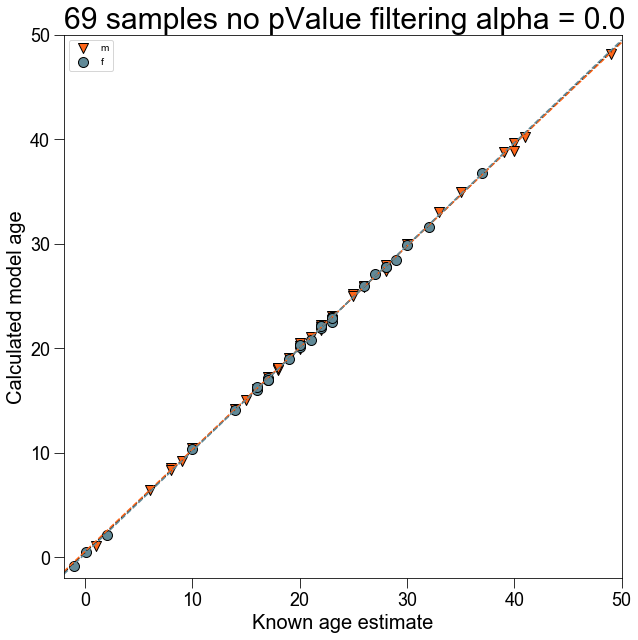

In [52]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a00_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a00_model_cpgs.csv'
all_KBO_samp_69_a00_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a00_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a00_clock = make_epigenetic_clock(all_KBO_samp_69_a00_clock_cpgs_path, all_KBO_samp_69_a00_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a00_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a00_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a00_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a00_clock", 0.0, len(all_KBO_samp_69_a00_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a00_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a00_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.0')
all_KBO_samp_69_a00_clock_stats

The y intercept for this clock model equation is 263.357210616781 .
There are 161 cpgs in the current model
The mean absolute error is 2.438422826434496
The median absolute error is 2.449360720729306
The mean absolute error for m is 2.5294176911873585
The median absolute error for m is 2.6105679019304056
The mean absolute error for f is 2.3268807341567954
The median absolute error for f is 2.440745802128582
r-squared: 0.9825985375205102
p-value: 1.1235835450602078e-60
slope: 0.8714712665521457
y-intercept for regression: 4.903914825303225
r-squared for m : 0.9798066293547245
p-value for m : 4.1564880501773946e-32
slope for m : 0.8624689894727736
y-intercept for regression for m : 5.101347814869186
r-squared for f : 0.9875126020108546
p-value for f : 3.701629095244503e-29
slope for f : 0.8883205687773245
y-intercept for regression for f : 4.567348218410469


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a01_clock    0.1         161  all  2.438423  2.449361   
1  all_KBO_samp_69_a01_clock    0.1         161    m  2.529418  2.610568   
2  all_KBO_samp_69_a01_clock    0.1         161    f  2.326881  2.440746   

   r-squared       p-value  regression_slope  y-intercept  
0   0.982599  1.123584e-60          0.871471     4.903915  
1   0.979807  4.156488e-32          0.862469     5.101348  
2   0.987513  3.701629e-29          0.888321     4.567348

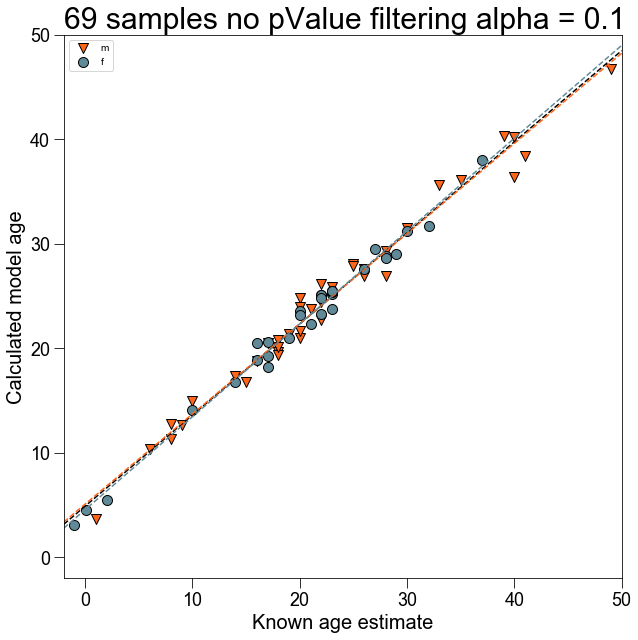

In [53]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a01_model_cpgs.csv'
all_KBO_samp_69_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a01_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a01_clock = make_epigenetic_clock(all_KBO_samp_69_a01_clock_cpgs_path, all_KBO_samp_69_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a01_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a01_clock", 0.1, len(all_KBO_samp_69_a01_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a01_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a01_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.1')

all_KBO_samp_69_a01_clock_stats

The y intercept for this clock model equation is 280.42803490999097 .
There are 107 cpgs in the current model
The mean absolute error is 2.484854576320469
The median absolute error is 2.5475171484144603
The mean absolute error for m is 2.5258236864597805
The median absolute error for m is 2.6658898571571683
The mean absolute error for f is 2.434634376794862
The median absolute error for f is 2.4427188753726874
r-squared: 0.9877352914902814
p-value: 9.118030698915354e-66
slope: 0.8914196205477963
y-intercept for regression: 4.638546438705738
r-squared for m : 0.9855464286292654
p-value for m : 1.0076746802869267e-34
slope for m : 0.8846298083590661
y-intercept for regression for m : 4.793632700435442
r-squared for f : 0.9915411994417073
p-value for f : 1.3022682476252852e-31
slope for f : 0.9039075379347161
y-intercept for regression for f : 4.381591648511147


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a02_clock    0.2         107  all  2.484855  2.547517   
1  all_KBO_samp_69_a02_clock    0.2         107    m  2.525824  2.665890   
2  all_KBO_samp_69_a02_clock    0.2         107    f  2.434634  2.442719   

   r-squared       p-value  regression_slope  y-intercept  
0   0.987735  9.118031e-66          0.891420     4.638546  
1   0.985546  1.007675e-34          0.884630     4.793633  
2   0.991541  1.302268e-31          0.903908     4.381592

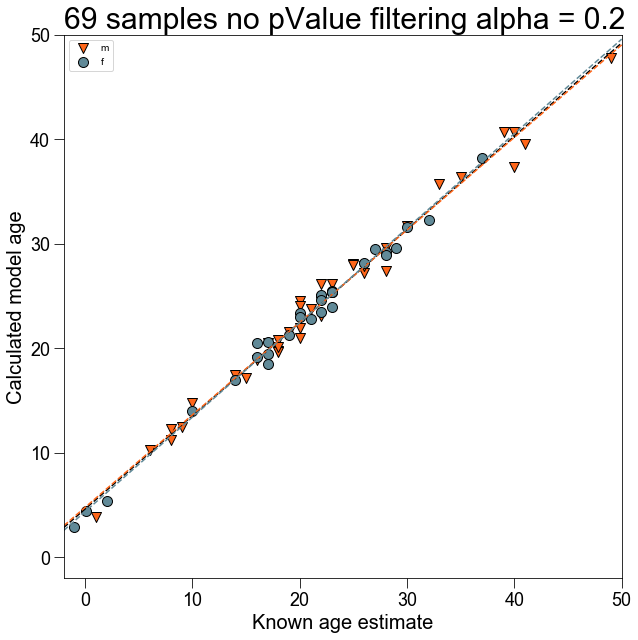

In [55]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a02_model_cpgs.csv'
all_KBO_samp_69_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a02_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a02_clock = make_epigenetic_clock(all_KBO_samp_69_a02_clock_cpgs_path, all_KBO_samp_69_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a02_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a02_clock", 0.2, len(all_KBO_samp_69_a02_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a02_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a02_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.2')

all_KBO_samp_69_a02_clock_stats

The y intercept for this clock model equation is 265.716249296699 .
There are 79 cpgs in the current model
The mean absolute error is 2.4458257357563027
The median absolute error is 2.419722932726046
The mean absolute error for m is 2.530596017382023
The median absolute error for m is 2.628374631355605
The mean absolute error for f is 2.3419137776344496
The median absolute error for f is 2.346100207465099
r-squared: 0.9828658114837782
p-value: 6.688890166080323e-61
slope: 0.8768706026150075
y-intercept for regression: 4.829979481069632
r-squared for m : 0.9799236733980351
p-value for m : 3.743344747394396e-32
slope for m : 0.8680298177794822
y-intercept for regression for m : 5.0343035940931635
r-squared for f : 0.9880133256052906
p-value for f : 2.0444568305432453e-29
slope for f : 0.8930453580903032
y-intercept for regression for f : 4.4942048649815405


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a03_clock    0.3          79  all  2.445826  2.419723   
1  all_KBO_samp_69_a03_clock    0.3          79    m  2.530596  2.628375   
2  all_KBO_samp_69_a03_clock    0.3          79    f  2.341914  2.346100   

   r-squared       p-value  regression_slope  y-intercept  
0   0.982866  6.688890e-61          0.876871     4.829979  
1   0.979924  3.743345e-32          0.868030     5.034304  
2   0.988013  2.044457e-29          0.893045     4.494205

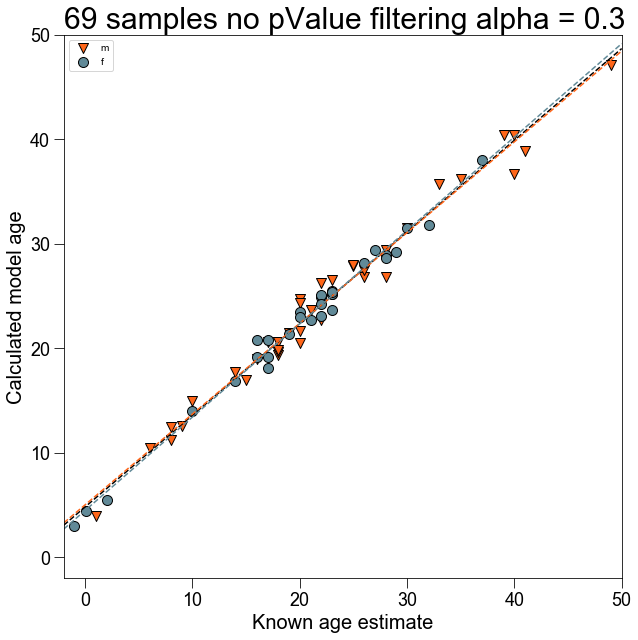

In [56]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a03_model_cpgs.csv'
all_KBO_samp_69_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a03_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a03_clock = make_epigenetic_clock(all_KBO_samp_69_a03_clock_cpgs_path, all_KBO_samp_69_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a03_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a03_clock", 0.3, len(all_KBO_samp_69_a03_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a03_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a03_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.3')

all_KBO_samp_69_a03_clock_stats

The y intercept for this clock model equation is 259.257572593529 .
There are 63 cpgs in the current model
The mean absolute error is 1.7639382097019645
The median absolute error is 1.7575896338559325
The mean absolute error for m is 1.888652913298414
The median absolute error for m is 1.932485656370428
The mean absolute error for f is 1.6110621214224456
The median absolute error for f is 1.5591830235407222
r-squared: 0.9841847395218225
p-value: 4.567730961849851e-62
slope: 0.8885129007909495
y-intercept for regression: 3.7824989941781695
r-squared for m : 0.9815575978084812
p-value for m : 8.115507511661163e-33
slope for m : 0.8796659136054974
y-intercept for regression for m : 3.9962891063900123
r-squared for f : 0.98879383904128
p-value for f : 7.69858281429117e-30
slope for f : 0.9043663348202113
y-intercept for regression for f : 3.441801346752527


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a04_clock    0.4          63  all  1.763938  1.757590   
1  all_KBO_samp_69_a04_clock    0.4          63    m  1.888653  1.932486   
2  all_KBO_samp_69_a04_clock    0.4          63    f  1.611062  1.559183   

   r-squared       p-value  regression_slope  y-intercept  
0   0.984185  4.567731e-62          0.888513     3.782499  
1   0.981558  8.115508e-33          0.879666     3.996289  
2   0.988794  7.698583e-30          0.904366     3.441801

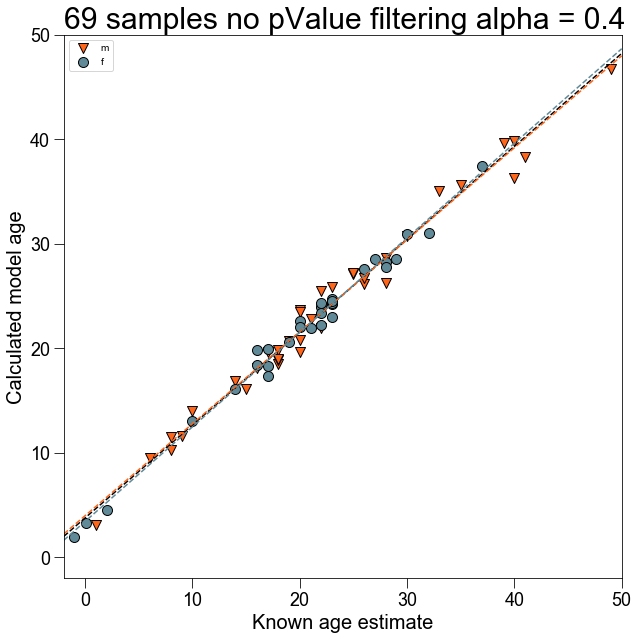

In [57]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a04_model_cpgs.csv'
all_KBO_samp_69_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a04_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a04_clock = make_epigenetic_clock(all_KBO_samp_69_a04_clock_cpgs_path, all_KBO_samp_69_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a04_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a04_clock", 0.4, len(all_KBO_samp_69_a04_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a04_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a04_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.4')

all_KBO_samp_69_a04_clock_stats

The y intercept for this clock model equation is 259.98887970718 .
There are 60 cpgs in the current model
The mean absolute error is 1.115750060311181
The median absolute error is 0.9453014549961942
The mean absolute error for m is 1.2418378902936817
The median absolute error for m is 1.0761073102544785
The mean absolute error for f is 0.9611907848487613
The median absolute error for f is 0.8289168057662906
r-squared: 0.9876937437580644
p-value: 1.0212031132601159e-65
slope: 0.9082773392121289
y-intercept for regression: 2.43271685018356
r-squared for m : 0.9857002431736299
p-value for m : 8.310954797506423e-35
slope for m : 0.9009501347196021
y-intercept for regression for m : 2.617881336400554
r-squared for f : 0.991161439157558
p-value for f : 2.462257118081025e-31
slope for f : 0.9211183321777081
y-intercept for regression for f : 2.1464731618197384


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a05_clock    0.5          60  all  1.115750  0.945301   
1  all_KBO_samp_69_a05_clock    0.5          60    m  1.241838  1.076107   
2  all_KBO_samp_69_a05_clock    0.5          60    f  0.961191  0.828917   

   r-squared       p-value  regression_slope  y-intercept  
0   0.987694  1.021203e-65          0.908277     2.432717  
1   0.985700  8.310955e-35          0.900950     2.617881  
2   0.991161  2.462257e-31          0.921118     2.146473

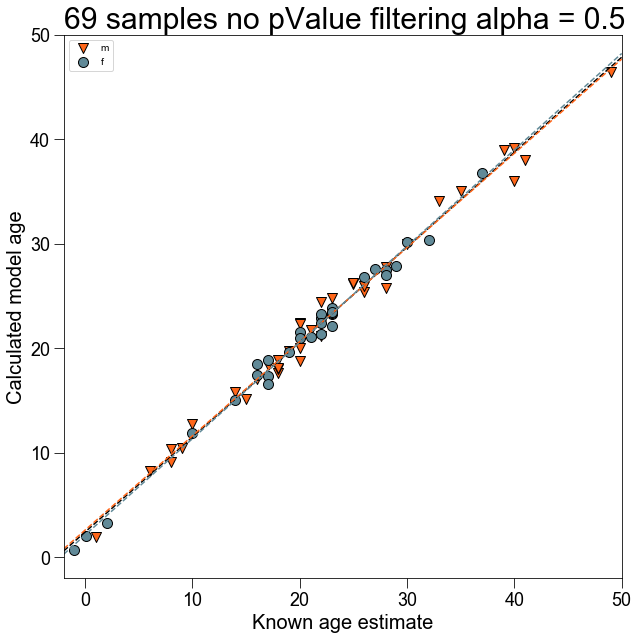

In [58]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a05_model_cpgs.csv'
all_KBO_samp_69_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a05_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a05_clock = make_epigenetic_clock(all_KBO_samp_69_a05_clock_cpgs_path, all_KBO_samp_69_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a05_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a05_clock", 0.5, len(all_KBO_samp_69_a05_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a05_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a05_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.5')

all_KBO_samp_69_a05_clock_stats

The y intercept for this clock model equation is 262.71600054078203 .
There are 58 cpgs in the current model
The mean absolute error is 3.4958489728417907
The median absolute error is 3.530550646819183
The mean absolute error for m is 3.410109531857197
The median absolute error for m is 3.5428028502116256
The mean absolute error for f is 3.6009489327583877
The median absolute error for f is 3.468751929445812
r-squared: 0.990008922976977
p-value: 9.471340555451196e-69
slope: 0.8621569098635862
y-intercept for regression: 6.403419060579523
r-squared for m : 0.9905455562975273
p-value for m : 4.83253112770558e-38
slope for m : 0.8527453400468569
y-intercept for regression for m : 6.621765465631984
r-squared for f : 0.9893375631275535
p-value for f : 3.741912516025837e-30
slope for f : 0.8793463131236285
y-intercept for regression for f : 6.045548311050293


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a06_clock    0.6          58  all  3.495849  3.530551   
1  all_KBO_samp_69_a06_clock    0.6          58    m  3.410110  3.542803   
2  all_KBO_samp_69_a06_clock    0.6          58    f  3.600949  3.468752   

   r-squared       p-value  regression_slope  y-intercept  
0   0.990009  9.471341e-69          0.862157     6.403419  
1   0.990546  4.832531e-38          0.852745     6.621765  
2   0.989338  3.741913e-30          0.879346     6.045548

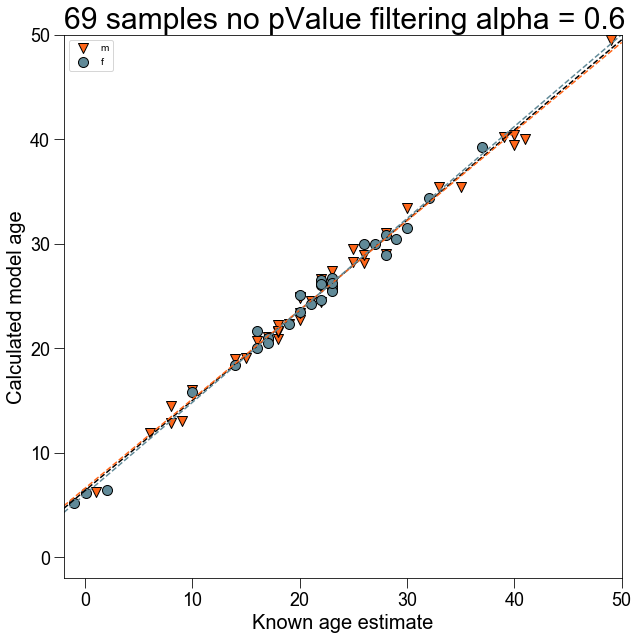

In [59]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a06_model_cpgs.csv'
all_KBO_samp_69_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a06_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a06_clock = make_epigenetic_clock(all_KBO_samp_69_a06_clock_cpgs_path, all_KBO_samp_69_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a06_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a06_clock", 0.6, len(all_KBO_samp_69_a06_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a06_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a06_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.6')

all_KBO_samp_69_a06_clock_stats

The y intercept for this clock model equation is 253.10743266377497 .
There are 53 cpgs in the current model
The mean absolute error is 3.5264443535147003
The median absolute error is 3.6450949823447907
The mean absolute error for m is 3.432079558620005
The median absolute error for m is 3.6318092355482143
The mean absolute error for f is 3.6421173279017474
The median absolute error for f is 3.6476691067133338
r-squared: 0.9905966844265209
p-value: 1.2421897199955072e-69
slope: 0.8652763778489038
y-intercept for regression: 6.378659366153119
r-squared for m : 0.9912998483826797
p-value for m : 1.0815666177892289e-38
slope for m : 0.8558708275922213
y-intercept for regression for m : 6.59464920380756
r-squared for f : 0.9896534817725671
p-value for f : 2.4189464300156948e-30
slope for f : 0.8825338951757294
y-intercept for regression for f : 6.022132180808981


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a07_clock    0.7          53  all  3.526444  3.645095   
1  all_KBO_samp_69_a07_clock    0.7          53    m  3.432080  3.631809   
2  all_KBO_samp_69_a07_clock    0.7          53    f  3.642117  3.647669   

   r-squared       p-value  regression_slope  y-intercept  
0   0.990597  1.242190e-69          0.865276     6.378659  
1   0.991300  1.081567e-38          0.855871     6.594649  
2   0.989653  2.418946e-30          0.882534     6.022132

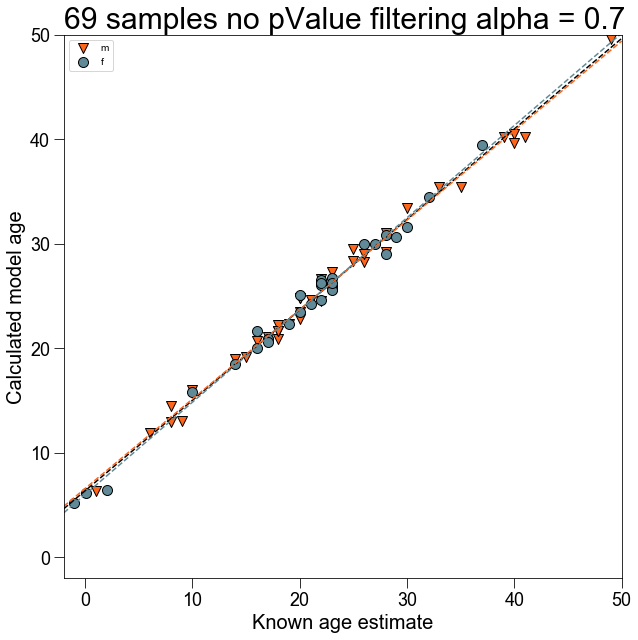

In [60]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a07_model_cpgs.csv'
all_KBO_samp_69_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a07_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a07_clock = make_epigenetic_clock(all_KBO_samp_69_a07_clock_cpgs_path, all_KBO_samp_69_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a07_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a07_clock", 0.7, len(all_KBO_samp_69_a07_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a07_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a07_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.7')

all_KBO_samp_69_a07_clock_stats

The y intercept for this clock model equation is 242.57201392042597 .
There are 53 cpgs in the current model
The mean absolute error is 3.6424736804863267
The median absolute error is 3.8154034506802432
The mean absolute error for m is 3.533304168703023
The median absolute error for m is 3.7999248041777083
The mean absolute error for f is 3.7762943723497284
The median absolute error for f is 3.84210249440779
r-squared: 0.9909080734883087
p-value: 4.019583120956005e-70
slope: 0.8662047353336959
y-intercept for regression: 6.488762618958685
r-squared for m : 0.9918228511248965
p-value for m : 3.542389538495837e-39
slope for m : 0.856913959121878
y-intercept for regression for m : 6.69789076864334
r-squared for f : 0.9895991839426929
p-value for f : 2.609748302549578e-30
slope for f : 0.8834024632342091
y-intercept for regression for f : 6.1387109156591855


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a08_clock    0.8          53  all  3.642474  3.815403   
1  all_KBO_samp_69_a08_clock    0.8          53    m  3.533304  3.799925   
2  all_KBO_samp_69_a08_clock    0.8          53    f  3.776294  3.842102   

   r-squared       p-value  regression_slope  y-intercept  
0   0.990908  4.019583e-70          0.866205     6.488763  
1   0.991823  3.542390e-39          0.856914     6.697891  
2   0.989599  2.609748e-30          0.883402     6.138711

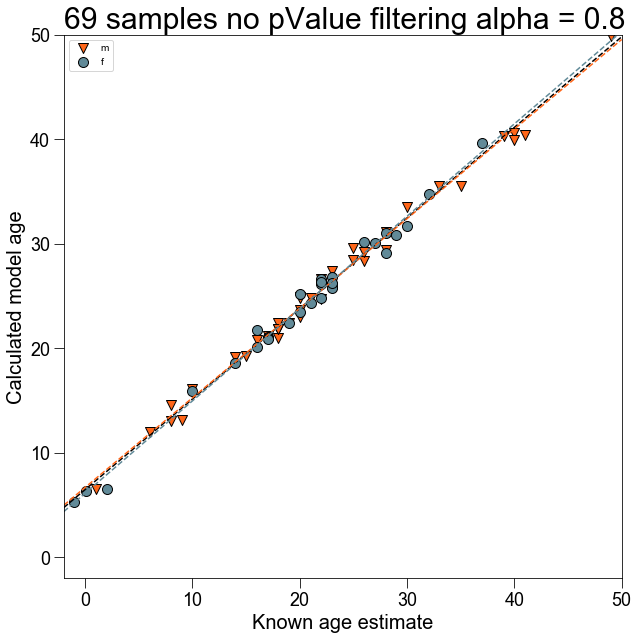

In [61]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a08_model_cpgs.csv'
all_KBO_samp_69_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a08_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a08_clock = make_epigenetic_clock(all_KBO_samp_69_a08_clock_cpgs_path, all_KBO_samp_69_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a08_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a08_clock", 0.8, len(all_KBO_samp_69_a08_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a08_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a08_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.8')

all_KBO_samp_69_a08_clock_stats

The y intercept for this clock model equation is 243.669782448457 .
There are 51 cpgs in the current model
The mean absolute error is 3.899006924466604
The median absolute error is 4.06757745775484
The mean absolute error for m is 3.7898762686677627
The median absolute error for m is 4.069747022216934
The mean absolute error for f is 4.03277998641357
The median absolute error for f is 4.062932786362225
r-squared: 0.9886471490440868
p-value: 6.850222509146815e-67
slope: 0.8526198878258218
y-intercept for regression: 7.028590304621126
r-squared for m : 0.9895707374536546
p-value for m : 2.8280968643360177e-37
slope for m : 0.8418366799460806
y-intercept for regression for m : 7.27770604424251
r-squared for f : 0.9874735561619797
p-value for f : 3.873117186853588e-29
slope for f : 0.8723520200725067
y-intercept for regression for f : 6.619092766815459


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a09_clock    0.9          51  all  3.899007  4.067577   
1  all_KBO_samp_69_a09_clock    0.9          51    m  3.789876  4.069747   
2  all_KBO_samp_69_a09_clock    0.9          51    f  4.032780  4.062933   

   r-squared       p-value  regression_slope  y-intercept  
0   0.988647  6.850223e-67          0.852620     7.028590  
1   0.989571  2.828097e-37          0.841837     7.277706  
2   0.987474  3.873117e-29          0.872352     6.619093

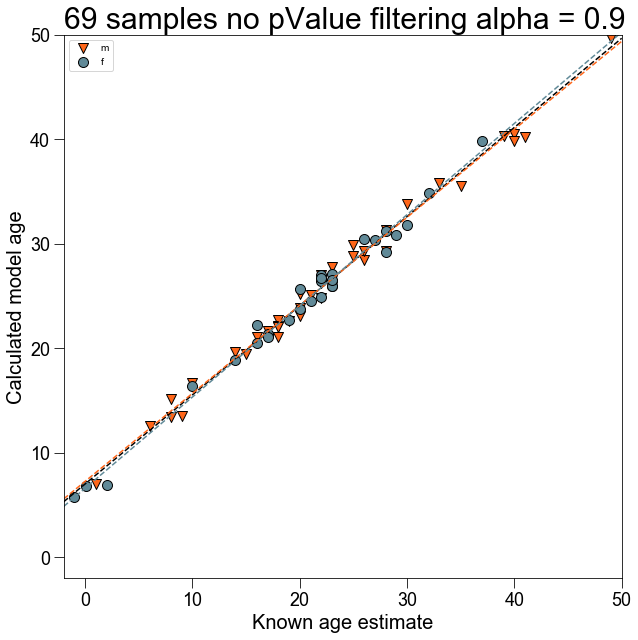

In [62]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a09_model_cpgs.csv'
all_KBO_samp_69_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a09_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a09_clock = make_epigenetic_clock(all_KBO_samp_69_a09_clock_cpgs_path, all_KBO_samp_69_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a09_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a09_clock", 0.9, len(all_KBO_samp_69_a09_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a09_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a09_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 0.9')

all_KBO_samp_69_a09_clock_stats

The y intercept for this clock model equation is 215.73287553448898 .
There are 53 cpgs in the current model
The mean absolute error is 3.7608910916870526
The median absolute error is 3.9473656205882293
The mean absolute error for m is 3.6390538558867114
The median absolute error for m is 3.984625638696116
The mean absolute error for f is 3.9102399613777976
The median absolute error for f is 3.9316253153343794
r-squared: 0.9920390135905555
p-value: 4.691999006738292e-72
slope: 0.8723368639328354
y-intercept for regression: 6.489135575052913
r-squared for m : 0.9931996095383272
p-value for m : 1.28169906357311e-40
slope for m : 0.8636963649353591
y-intercept for regression for m : 6.6761085331581
r-squared for f : 0.9902644945312141
p-value for f : 1.0004214060005948e-30
slope for f : 0.8885991639785843
y-intercept for regression for f : 6.167364642185902


clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a1_clock    1.0          53  all  3.760891  3.947366   
1  all_KBO_samp_69_a1_clock    1.0          53    m  3.639054  3.984626   
2  all_KBO_samp_69_a1_clock    1.0          53    f  3.910240  3.931625   

   r-squared       p-value  regression_slope  y-intercept  
0   0.992039  4.691999e-72          0.872337     6.489136  
1   0.993200  1.281699e-40          0.863696     6.676109  
2   0.990264  1.000421e-30          0.888599     6.167365

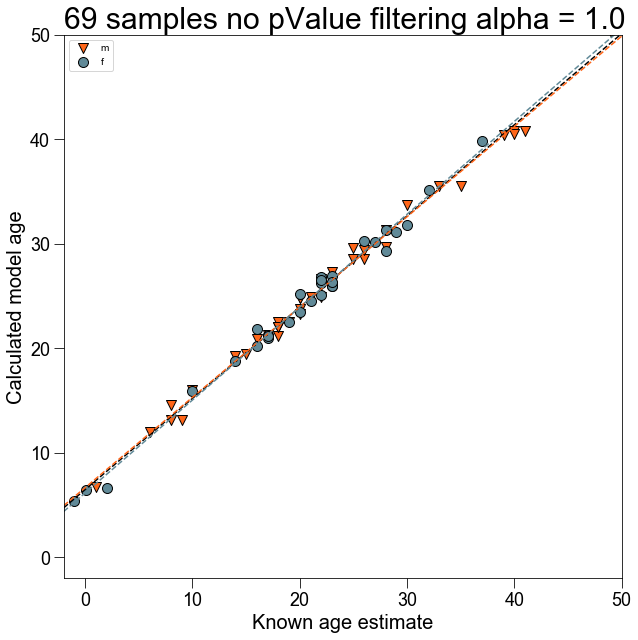

In [63]:
### Using all sites; no filtering
### Using sesame_KBO_samp_69
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
all_KBO_samp_69_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a1_model_cpgs.csv'
all_KBO_samp_69_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/sesame_KBO_samp_69_a1_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
all_KBO_samp_69_a1_clock = make_epigenetic_clock(all_KBO_samp_69_a1_clock_cpgs_path, all_KBO_samp_69_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model 
all_KBO_samp_69_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               all_KBO_samp_69_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
all_KBO_samp_69_a1_clock_stats = sex_specific_clock_plots_and_stats("all_KBO_samp_69_a1_clock", 1.0, len(all_KBO_samp_69_a1_clock['cpgs'])-1,
                                                                     all_KBO_samp_69_a1_model_age_df, 
                                                                     '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/KBO_samp_69_fig_a1_sex_specific.eps', 
                                                                     '69 samples no pValue filtering alpha = 1.0')

all_KBO_samp_69_a1_clock_stats

In [104]:

dfs_for_samp_69_no_pvalue_filtering = [all_KBO_samp_69_a01_clock_stats, all_KBO_samp_69_a02_clock_stats,
                                       all_KBO_samp_69_a03_clock_stats, all_KBO_samp_69_a04_clock_stats,
                                       all_KBO_samp_69_a05_clock_stats, all_KBO_samp_69_a06_clock_stats,
                                       all_KBO_samp_69_a07_clock_stats, all_KBO_samp_69_a08_clock_stats,
                                       all_KBO_samp_69_a09_clock_stats, all_KBO_samp_69_a1_clock_stats]
                                       
stats_samp_69_no_pvalue_filtering_clocks = pd.concat(dfs_for_samp_69_no_pvalue_filtering)

stats_samp_69_no_pvalue_filtering_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_69_no_pvalue_filtering_clocks.csv')

stats_samp_69_no_pvalue_filtering_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  all_KBO_samp_69_a01_clock    0.1         161  all  2.438423  2.449361   
1  all_KBO_samp_69_a01_clock    0.1         161    m  2.529418  2.610568   
2  all_KBO_samp_69_a01_clock    0.1         161    f  2.326881  2.440746   
0  all_KBO_samp_69_a02_clock    0.2         107  all  2.484855  2.547517   
1  all_KBO_samp_69_a02_clock    0.2         107    m  2.525824  2.665890   
2  all_KBO_samp_69_a02_clock    0.2         107    f  2.434634  2.442719   
0  all_KBO_samp_69_a03_clock    0.3          79  all  2.445826  2.419723   
1  all_KBO_samp_69_a03_clock    0.3          79    m  2.530596  2.628375   
2  all_KBO_samp_69_a03_clock    0.3          79    f  2.341914  2.346100   
0  all_KBO_samp_69_a04_clock    0.4          63  all  1.763938  1.757590   
1  all_KBO_samp_69_a04_clock    0.4          63    m  1.888653  1.932486   
2  all_KBO_samp_69_a04_clock    0.4          63    f  1.611062  1.559183   
0  all_KBO_samp_69_a05_clock    0.5          60  all  1.115750  0.945301   
1  all_KBO_samp_69_a05_clock    0.5          60    m  1.241838  1.076107   
2  all_KBO_samp_69_a05_clock    0.5          60    f  0.961191  0.828917   
0  all_KBO_samp_69_a06_clock    0.6          58  all  3.495849  3.530551   
1  all_KBO_samp_69_a06_clock    0.6          58    m  3.410110  3.542803   
2  all_KBO_samp_69_a06_clock    0.6          58    f  3.600949  3.468752   
0  all_KBO_samp_69_a07_clock    0.7          53  all  3.526444  3.645095   
1  all_KBO_samp_69_a07_clock    0.7          53    m  3.432080  3.631809   
2  all_KBO_samp_69_a07_clock    0.7          53    f  3.642117  3.647669   
0  all_KBO_samp_69_a08_clock    0.8          53  all  3.642474  3.815403   
1  all_KBO_samp_69_a08_clock    0.8          53    m  3.533304  3.799925   
2  all_KBO_samp_69_a08_clock    0.8          53    f  3.776294  3.842102   
0  all_KBO_samp_69_a09_clock    0.9          51  all  3.899007  4.067577   
1  all_KBO_samp_69_a09_clock    0.9          51    m  3.789876  4.069747   
2  all_KBO_samp_69_a09_clock    0.9          51    f  4.032780  4.062933   
0   all_KBO_samp_69_a1_clock    1.0          53  all  3.760891  3.947366   
1   all_KBO_samp_69_a1_clock    1.0          53    m  3.639054  3.984626   
2   all_KBO_samp_69_a1_clock    1.0          53    f  3.910240  3.931625   

   r-squared       p-value  regression_slope  y-intercept  
0   0.982599  1.123584e-60          0.871471     4.903915  
1   0.979807  4.156488e-32          0.862469     5.101348  
2   0.987513  3.701629e-29          0.888321     4.567348  
0   0.987735  9.118031e-66          0.891420     4.638546  
1   0.985546  1.007675e-34          0.884630     4.793633  
2   0.991541  1.302268e-31          0.903908     4.381592  
0   0.982866  6.688890e-61          0.876871     4.829979  
1   0.979924  3.743345e-32          0.868030     5.034304  
2   0.988013  2.044457e-29          0.893045     4.494205  
0   0.984185  4.567731e-62          0.888513     3.782499  
1   0.981558  8.115508e-33          0.879666     3.996289  
2   0.988794  7.698583e-30          0.904366     3.441801  
0   0.987694  1.021203e-65          0.908277     2.432717  
1   0.985700  8.310955e-35          0.900950     2.617881  
2   0.991161  2.462257e-31          0.921118     2.146473  
0   0.990009  9.471341e-69          0.862157     6.403419  
1   0.990546  4.832531e-38          0.852745     6.621765  
2   0.989338  3.741913e-30          0.879346     6.045548  
0   0.990597  1.242190e-69          0.865276     6.378659  
1   0.991300  1.081567e-38          0.855871     6.594649  
2   0.989653  2.418946e-30          0.882534     6.022132  
0   0.990908  4.019583e-70          0.866205     6.488763  
1   0.991823  3.542390e-39          0.856914     6.697891  
2   0.989599  2.609748e-30          0.883402     6.138711  
0   0.988647  6.850223e-67          0.852620     7.028590  
1   0.989571  2.828097e-37          0.841837     7.277706  
2   0.987474  3.873117e-29          0.872

# P Value Filtered Clocks 

## Remove probes with bad pValues for all 

The y intercept for this clock model equation is 217.130448730966 .
There are 120 cpgs in the current model
The mean absolute error is 3.154180516361172
The median absolute error is 3.008756036365938
The mean absolute error for m is 3.4583583770637842
The median absolute error for m is 3.3823632090584947
The mean absolute error for f is 2.781317332274099
The median absolute error for f is 2.887263201136463
r-squared: 0.9295071414423918
p-value: 2.603402763782983e-40
slope: 0.7528954739151198
y-intercept for regression: 7.512162167851667
r-squared for m : 0.9193038704075092
p-value for m : 2.8933074857330134e-21
slope for m : 0.7281813127590218
y-intercept for regression for m : 8.112540746495977
r-squared for f : 0.9482500739401667
p-value for f : 3.384278700805701e-20
slope for f : 0.7970696988556802
y-intercept for regression for f : 6.558833790723714


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a01_clock    0.1         120  all  3.154181   
1  samp_69_bad_pValue_removed_a01_clock    0.1         120    m  3.458358   
2  samp_69_bad_pValue_removed_a01_clock    0.1         120    f  2.781317   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.008756   0.929507  2.603403e-40          0.752895     7.512162  
1  3.382363   0.919304  2.893307e-21          0.728181     8.112541  
2  2.887263   0.948250  3.384279e-20          0.797070     6.558834

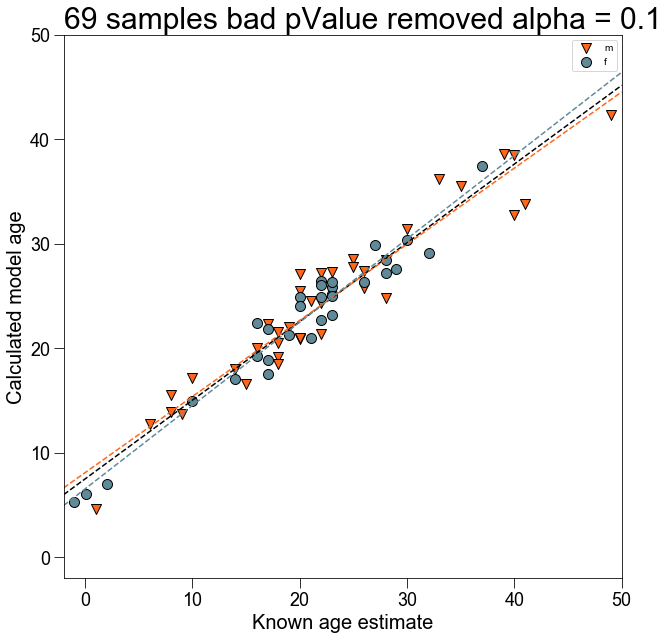

In [64]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a01_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a01_clock_cpgs_path, samp_69_bad_pValue_removed_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a01_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a01_clock", 0.1, len(samp_69_bad_pValue_removed_a01_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a01_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a01_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.1')
samp_69_bad_pValue_removed_a01_clock_stats

The y intercept for this clock model equation is 189.209131778287 .
There are 70 cpgs in the current model
The mean absolute error is 3.565214979801332
The median absolute error is 3.433559942838258
The mean absolute error for m is 3.853725048967617
The median absolute error for m is 3.8612459946512505
The mean absolute error for f is 3.211557475662019
The median absolute error for f is 3.2325305732273506
r-squared: 0.9279365489092406
p-value: 5.451173327847555e-40
slope: 0.7447535170327124
y-intercept for regression: 8.220588735811733
r-squared for m : 0.9175188199169046
p-value for m : 4.293699146649192e-21
slope for m : 0.7189957107357099
y-intercept for regression for m : 8.859040607045518
r-squared for f : 0.9472734890839303
p-value for f : 4.4402212884322424e-20
slope for f : 0.7903392546008782
y-intercept for regression for f : 7.2206068802957155


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a02_clock    0.2          70  all  3.565215   
1  samp_69_bad_pValue_removed_a02_clock    0.2          70    m  3.853725   
2  samp_69_bad_pValue_removed_a02_clock    0.2          70    f  3.211557   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.433560   0.927937  5.451173e-40          0.744754     8.220589  
1  3.861246   0.917519  4.293699e-21          0.718996     8.859041  
2  3.232531   0.947273  4.440221e-20          0.790339     7.220607

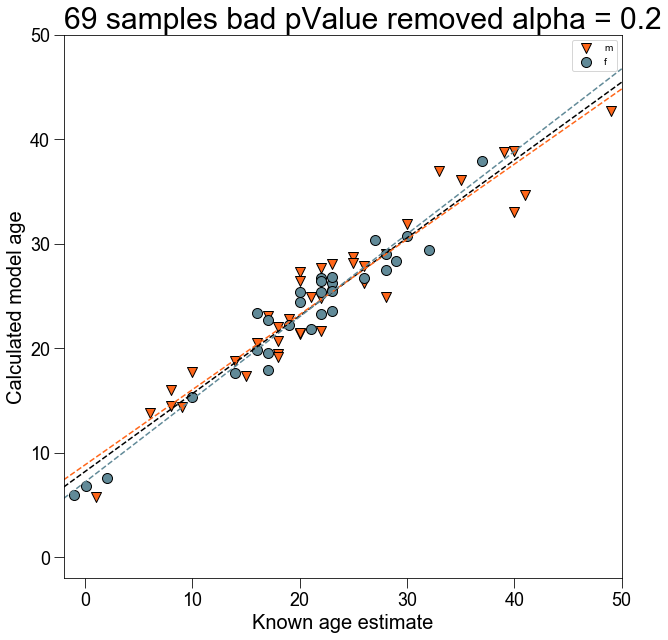

In [65]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a02_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a02_clock_cpgs_path, samp_69_bad_pValue_removed_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a02_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a02_clock", 0.2, len(samp_69_bad_pValue_removed_a02_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a02_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a02_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.2')
samp_69_bad_pValue_removed_a02_clock_stats

The y intercept for this clock model equation is 195.046662094279 .
There are 52 cpgs in the current model
The mean absolute error is 3.5390542991602665
The median absolute error is 3.4727135082767617
The mean absolute error for m is 3.809364940959244
The median absolute error for m is 3.941803540093039
The mean absolute error for f is 3.207705770503455
The median absolute error for f is 3.4056947817104017
r-squared: 0.9328279369033736
p-value: 5.161196245050101e-41
slope: 0.7596093087643296
y-intercept for regression: 7.96854016230121
r-squared for m : 0.9237354900474227
p-value for m : 1.0443963866776066e-21
slope for m : 0.7339894962813006
y-intercept for regression for m : 8.616231766546193
r-squared for f : 0.949987524260988
p-value for f : 2.0608216590419467e-20
slope for f : 0.804499063153261
y-intercept for regression for f : 6.967549998352084


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a03_clock    0.3          52  all  3.539054   
1  samp_69_bad_pValue_removed_a03_clock    0.3          52    m  3.809365   
2  samp_69_bad_pValue_removed_a03_clock    0.3          52    f  3.207706   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.472714   0.932828  5.161196e-41          0.759609     7.968540  
1  3.941804   0.923735  1.044396e-21          0.733989     8.616232  
2  3.405695   0.949988  2.060822e-20          0.804499     6.967550

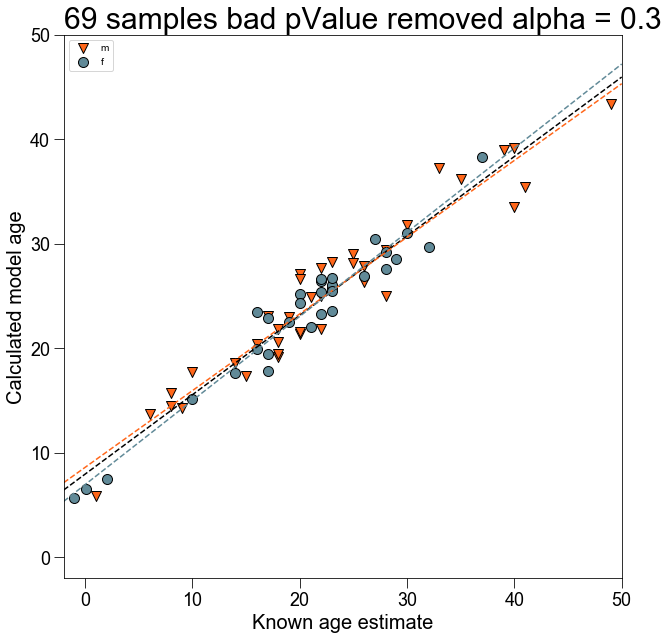

In [66]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a03_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a03_clock_cpgs_path, samp_69_bad_pValue_removed_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a03_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a03_clock", 0.3, len(samp_69_bad_pValue_removed_a03_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a03_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a03_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.3')
samp_69_bad_pValue_removed_a03_clock_stats

The y intercept for this clock model equation is 212.48412561048 .
There are 40 cpgs in the current model
The mean absolute error is 3.208481294323121
The median absolute error is 3.2273687578806154
The mean absolute error for m is 3.4825836688927505
The median absolute error for m is 3.6515957364368337
The mean absolute error for f is 2.8724848351732515
The median absolute error for f is 3.0204249126324996
r-squared: 0.9368927336139267
p-value: 6.363164572269848e-42
slope: 0.7744014412255094
y-intercept for regression: 7.289389847148492
r-squared for m : 0.9287463781913754
p-value for m : 3.0653283352044636e-22
slope for m : 0.7496716769803672
y-intercept for regression for m : 7.91839720391717
r-squared for f : 0.9522935960927761
p-value for f : 1.038185866241021e-20
slope for f : 0.8175954933397354
y-intercept for regression for f : 6.321255521929636


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a04_clock    0.4          40  all  3.208481   
1  samp_69_bad_pValue_removed_a04_clock    0.4          40    m  3.482584   
2  samp_69_bad_pValue_removed_a04_clock    0.4          40    f  2.872485   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.227369   0.936893  6.363165e-42          0.774401     7.289390  
1  3.651596   0.928746  3.065328e-22          0.749672     7.918397  
2  3.020425   0.952294  1.038186e-20          0.817595     6.321256

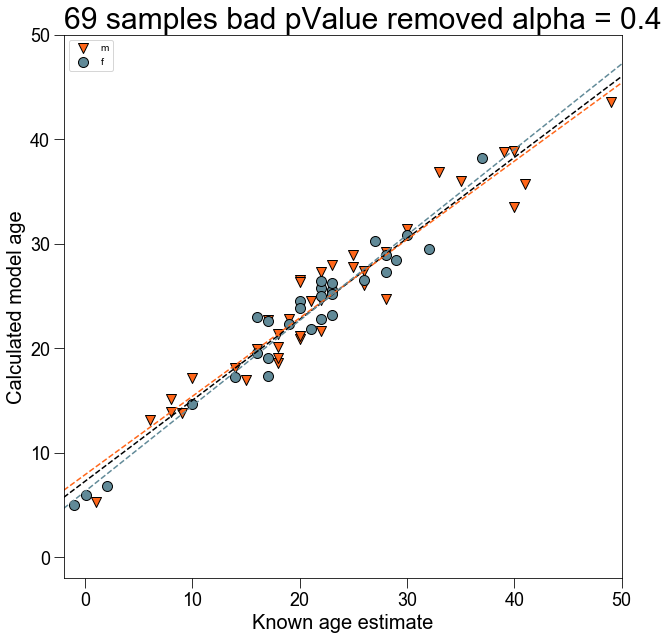

In [67]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a04_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a04_clock_cpgs_path, samp_69_bad_pValue_removed_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a04_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a04_clock", 0.4, len(samp_69_bad_pValue_removed_a04_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a04_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a04_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.4')
samp_69_bad_pValue_removed_a04_clock_stats

The y intercept for this clock model equation is 217.078891347078 .
There are 35 cpgs in the current model
The mean absolute error is 2.8358310094489805
The median absolute error is 2.795535629631779
The mean absolute error for m is 3.1407975621473914
The median absolute error for m is 3.3564575129878094
The mean absolute error for f is 2.4620010416251183
The median absolute error for f is 2.649905668169385
r-squared: 0.9377502693394446
p-value: 4.0218626860355436e-42
slope: 0.7808783933590614
y-intercept for regression: 6.620639250136328
r-squared for m : 0.9301975065733503
p-value for m : 2.1149926235546563e-22
slope for m : 0.7564369073499446
y-intercept for regression for m : 7.246597505721045
r-squared for f : 0.9520821851778768
p-value for f : 1.1070437410236955e-20
slope for f : 0.8234160806495688
y-intercept for regression for f : 5.6616369278254375


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a05_clock    0.5          35  all  2.835831   
1  samp_69_bad_pValue_removed_a05_clock    0.5          35    m  3.140798   
2  samp_69_bad_pValue_removed_a05_clock    0.5          35    f  2.462001   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.795536   0.937750  4.021863e-42          0.780878     6.620639  
1  3.356458   0.930198  2.114993e-22          0.756437     7.246598  
2  2.649906   0.952082  1.107044e-20          0.823416     5.661637

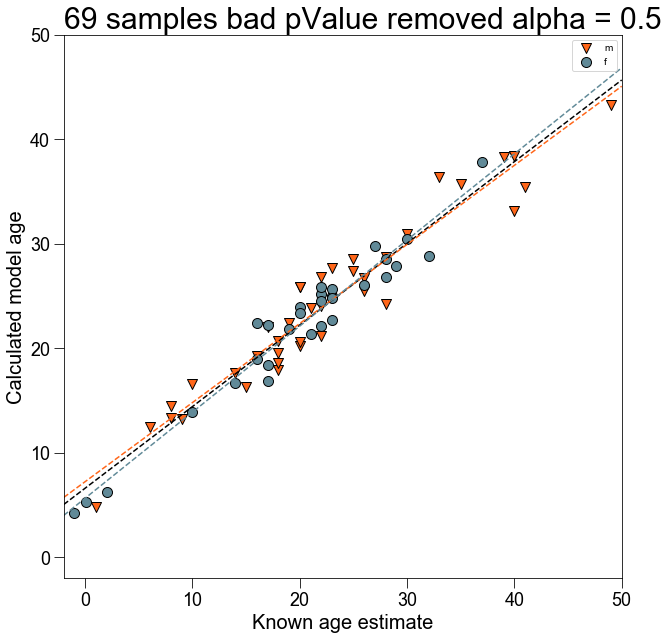

In [68]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a05_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a05_clock_cpgs_path, samp_69_bad_pValue_removed_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a05_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a05_clock", 0.5, len(samp_69_bad_pValue_removed_a05_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a05_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a05_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.5')
samp_69_bad_pValue_removed_a05_clock_stats

The y intercept for this clock model equation is 206.94558158086997 .
There are 31 cpgs in the current model
The mean absolute error is 2.4647435101368695
The median absolute error is 2.119077312258625
The mean absolute error for m is 2.7796309523292186
The median absolute error for m is 2.6067854543765083
The mean absolute error for f is 2.0787524519656033
The median absolute error for f is 1.8656165264584423
r-squared: 0.938032646654764
p-value: 3.4531635540411785e-42
slope: 0.7877227102248987
y-intercept for regression: 5.735381325841004
r-squared for m : 0.930617063263834
p-value for m : 1.8970893029293924e-22
slope for m : 0.7634345288584948
y-intercept for regression for m : 6.357741095186846
r-squared for f : 0.9520571776019631
p-value for f : 1.1154643444675516e-20
slope for f : 0.8299818935101874
y-intercept for regression for f : 4.782229387286527


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a06_clock    0.6          31  all  2.464744   
1  samp_69_bad_pValue_removed_a06_clock    0.6          31    m  2.779631   
2  samp_69_bad_pValue_removed_a06_clock    0.6          31    f  2.078752   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  2.119077   0.938033  3.453164e-42          0.787723     5.735381  
1  2.606785   0.930617  1.897089e-22          0.763435     6.357741  
2  1.865617   0.952057  1.115464e-20          0.829982     4.782229

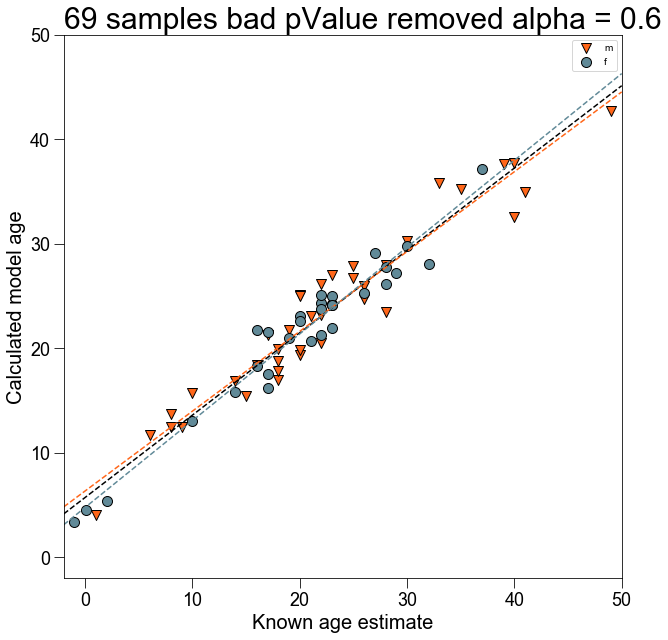

In [69]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a06_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a06_clock_cpgs_path, samp_69_bad_pValue_removed_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a06_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a06_clock", 0.6, len(samp_69_bad_pValue_removed_a06_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a06_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a06_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.6')
samp_69_bad_pValue_removed_a06_clock_stats

The y intercept for this clock model equation is 192.365643241929 .
There are 30 cpgs in the current model
The mean absolute error is 2.2359237643548595
The median absolute error is 1.9351275395120595
The mean absolute error for m is 2.6077306470189847
The median absolute error for m is 2.0867084319357727
The mean absolute error for f is 1.780160488831092
The median absolute error for f is 1.6265694166791356
r-squared: 0.9382185143018436
p-value: 3.1222764718861164e-42
slope: 0.7953906458327408
y-intercept for regression: 4.616961946662062
r-squared for m : 0.9308674602863997
p-value for m : 1.777336406810627e-22
slope for m : 0.7712849332382535
y-intercept for regression for m : 5.2364061833834015
r-squared for f : 0.9520406555870836
p-value for f : 1.1210603528174052e-20
slope for f : 0.8372695451116183
y-intercept for regression for f : 3.6700857554633544


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a07_clock    0.7          30  all  2.235924   
1  samp_69_bad_pValue_removed_a07_clock    0.7          30    m  2.607731   
2  samp_69_bad_pValue_removed_a07_clock    0.7          30    f  1.780160   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  1.935128   0.938219  3.122276e-42          0.795391     4.616962  
1  2.086708   0.930867  1.777336e-22          0.771285     5.236406  
2  1.626569   0.952041  1.121060e-20          0.837270     3.670086

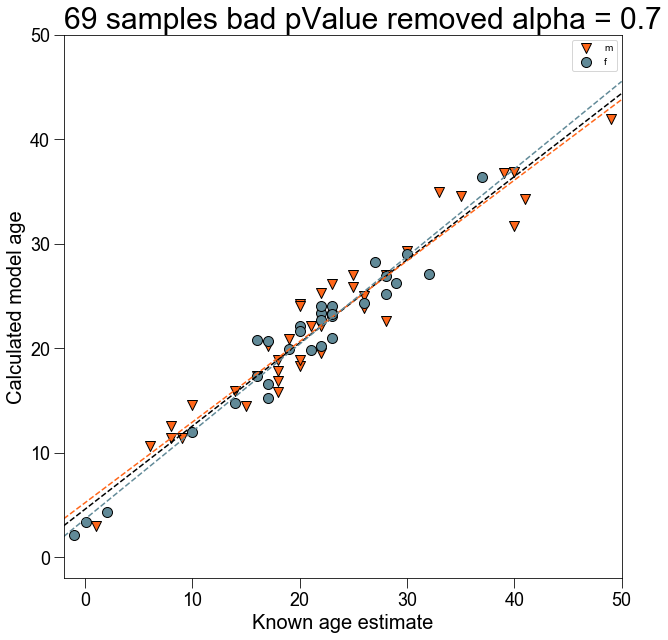

In [70]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a07_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a07_clock_cpgs_path, samp_69_bad_pValue_removed_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a07_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a07_clock", 0.7, len(samp_69_bad_pValue_removed_a07_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a07_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a07_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.7')
samp_69_bad_pValue_removed_a07_clock_stats

The y intercept for this clock model equation is 192.06055266879503 .
There are 28 cpgs in the current model
The mean absolute error is 5.961813688239435
The median absolute error is 5.910300617752057
The mean absolute error for m is 5.989892225406047
The median absolute error for m is 6.167609082454767
The mean absolute error for f is 5.927394836228748
The median absolute error for f is 5.905668086592559
r-squared: 0.9283766076847814
p-value: 4.438891699234272e-40
slope: 0.694830525234254
y-intercept for regression: 12.174749860752
r-squared for m : 0.9261966118000939
p-value for m : 5.77948075515378e-22
slope for m : 0.6647802089833713
y-intercept for regression for m : 12.899324267938994
r-squared for f : 0.9371604129797249
p-value for f : 5.6824990968638185e-19
slope for f : 0.748736559055501
y-intercept for regression for f : 11.018316360655845


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a08_clock    0.8          28  all  5.961814   
1  samp_69_bad_pValue_removed_a08_clock    0.8          28    m  5.989892   
2  samp_69_bad_pValue_removed_a08_clock    0.8          28    f  5.927395   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  5.910301   0.928377  4.438892e-40          0.694831    12.174750  
1  6.167609   0.926197  5.779481e-22          0.664780    12.899324  
2  5.905668   0.937160  5.682499e-19          0.748737    11.018316

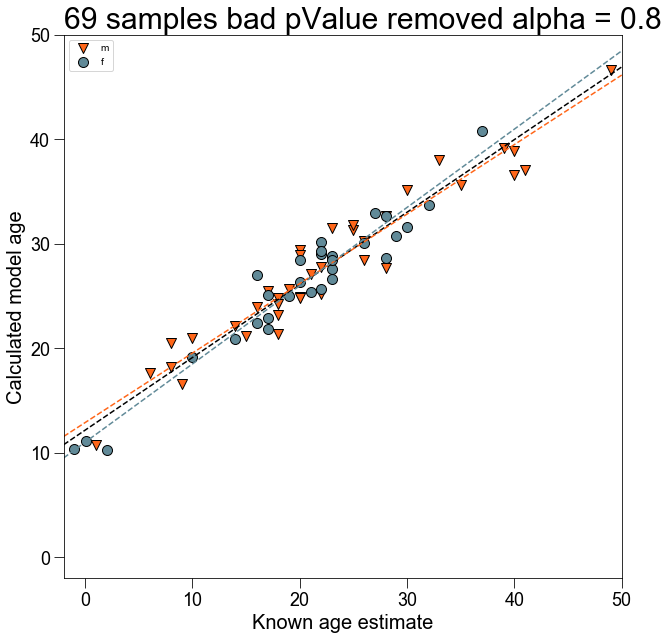

In [71]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a08_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a08_clock_cpgs_path, samp_69_bad_pValue_removed_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a08_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a08_clock", 0.8, len(samp_69_bad_pValue_removed_a08_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a08_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a08_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.8')
samp_69_bad_pValue_removed_a08_clock_stats

The y intercept for this clock model equation is 199.526023437144 .
There are 27 cpgs in the current model
The mean absolute error is 6.336773289363945
The median absolute error is 6.411664213162773
The mean absolute error for m is 6.296480149226432
The median absolute error for m is 6.614041996719502
The mean absolute error for f is 6.386164880500256
The median absolute error for f is 6.263086056219716
r-squared: 0.9302180176225662
p-value: 1.8531883322733637e-40
slope: 0.694736461305528
y-intercept for regression: 12.627386799781467
r-squared for m : 0.9291916259821786
p-value for m : 2.7376439049196324e-22
slope for m : 0.665358248903317
y-intercept for regression for m : 13.330369204665647
r-squared for f : 0.9370655918334018
p-value for f : 5.8083782194431975e-19
slope for f : 0.7476290366397876
y-intercept for regression for f : 11.499526238130882


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a09_clock    0.9          27  all  6.336773   
1  samp_69_bad_pValue_removed_a09_clock    0.9          27    m  6.296480   
2  samp_69_bad_pValue_removed_a09_clock    0.9          27    f  6.386165   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  6.411664   0.930218  1.853188e-40          0.694736    12.627387  
1  6.614042   0.929192  2.737644e-22          0.665358    13.330369  
2  6.263086   0.937066  5.808378e-19          0.747629    11.499526

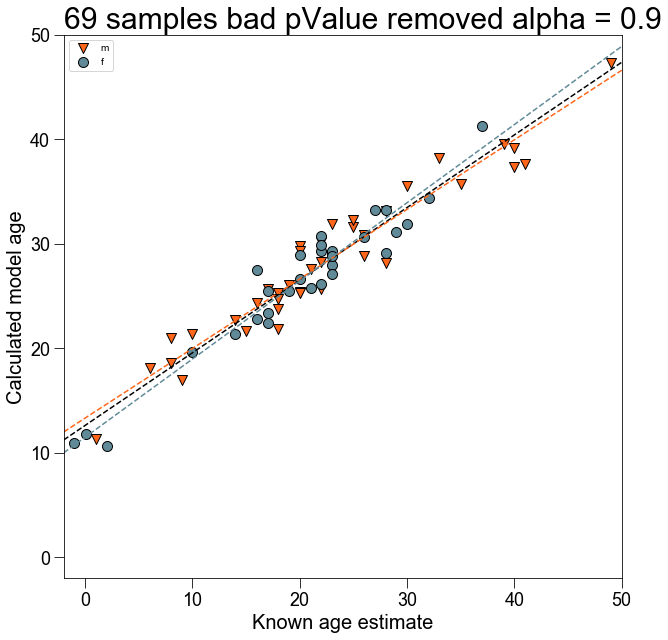

In [72]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a09_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a09_clock_cpgs_path, samp_69_bad_pValue_removed_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a09_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a09_clock", 0.9, len(samp_69_bad_pValue_removed_a09_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a09_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a09_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 0.9')
samp_69_bad_pValue_removed_a09_clock_stats

The y intercept for this clock model equation is 194.72310742005502 .
There are 26 cpgs in the current model
The mean absolute error is 6.547818901705716
The median absolute error is 6.65312140942347
The mean absolute error for m is 6.480524672373766
The median absolute error for m is 6.824492542184698
The mean absolute error for f is 6.630308602177137
The median absolute error for f is 6.507781710047816
r-squared: 0.9297429367150251
p-value: 2.3267040898426055e-40
slope: 0.6914356260509881
y-intercept for regression: 12.933282961231994
r-squared for m : 0.9290117874204165
p-value for m : 2.8657993473318054e-22
slope for m : 0.662033373891777
y-intercept for regression for m : 13.6326207556703
r-squared for f : 0.9362366373247953
p-value for f : 7.024870620704266e-19
slope for f : 0.7445220635013987
y-intercept for regression for f : 11.806621244589124


clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a1_clock    1.0          26  all  6.547819   
1  samp_69_bad_pValue_removed_a1_clock    1.0          26    m  6.480525   
2  samp_69_bad_pValue_removed_a1_clock    1.0          26    f  6.630309   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  6.653121   0.929743  2.326704e-40          0.691436    12.933283  
1  6.824493   0.929012  2.865799e-22          0.662033    13.632621  
2  6.507782   0.936237  7.024871e-19          0.744522    11.806621

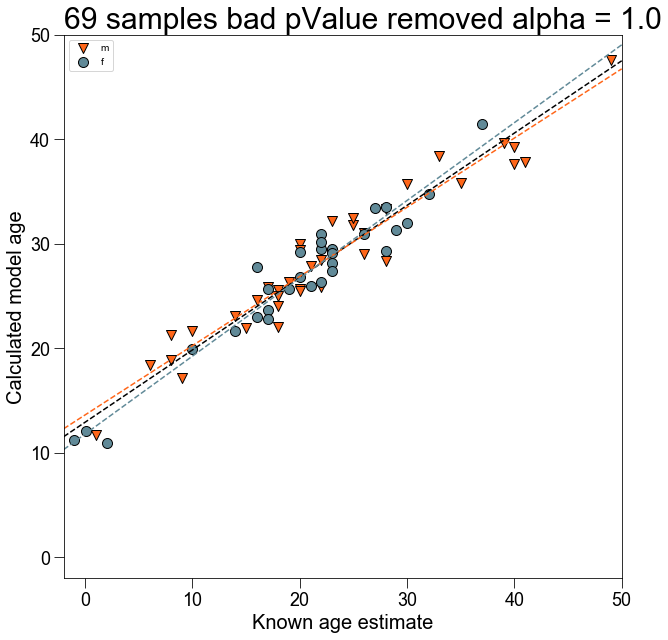

In [73]:
# Using probes filtered for pValue. 
# If ALL samples had a bad pValue, the probe was removed. If just one had a good pValue, it was used in the elastic net. 
# alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_bad_pValue_removed_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_bad_pvalue_removed_model_cpgs.csv'
samp_69_bad_pValue_removed_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_bad_pvalue_removed_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_bad_pValue_removed_a1_clock = make_epigenetic_clock(samp_69_bad_pValue_removed_a1_clock_cpgs_path, samp_69_bad_pValue_removed_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_bad_pValue_removed_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_bad_pValue_removed_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_bad_pValue_removed_a1_clock_stats = sex_specific_clock_plots_and_stats("samp_69_bad_pValue_removed_a1_clock", 1.0, len(samp_69_bad_pValue_removed_a1_clock['cpgs'])-1,
                                                                                samp_69_bad_pValue_removed_a1_model_age_df,
                                                                                '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_bad_pValue_removed_a1_sex_specific.eps', 
                                                                                '69 samples bad pValue removed alpha = 1.0')
samp_69_bad_pValue_removed_a1_clock_stats

In [105]:

dfs_for_samp_69_bad_pValue_removed = [samp_69_bad_pValue_removed_a01_clock_stats, samp_69_bad_pValue_removed_a02_clock_stats,
                                      samp_69_bad_pValue_removed_a03_clock_stats, samp_69_bad_pValue_removed_a04_clock_stats,
                                      samp_69_bad_pValue_removed_a05_clock_stats, samp_69_bad_pValue_removed_a06_clock_stats,
                                      samp_69_bad_pValue_removed_a07_clock_stats, samp_69_bad_pValue_removed_a08_clock_stats,
                                      samp_69_bad_pValue_removed_a09_clock_stats, samp_69_bad_pValue_removed_a1_clock_stats]

stats_samp_69_bad_pValue_removed_clocks = pd.concat(dfs_for_samp_69_bad_pValue_removed)

stats_samp_69_bad_pValue_removed_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_69_bad_pValue_removed_clocks.csv')
stats_samp_69_bad_pValue_removed_clocks

clock_info  alpha  clock_size  sex       mae  \
0  samp_69_bad_pValue_removed_a01_clock    0.1         120  all  3.154181   
1  samp_69_bad_pValue_removed_a01_clock    0.1         120    m  3.458358   
2  samp_69_bad_pValue_removed_a01_clock    0.1         120    f  2.781317   
0  samp_69_bad_pValue_removed_a02_clock    0.2          70  all  3.565215   
1  samp_69_bad_pValue_removed_a02_clock    0.2          70    m  3.853725   
2  samp_69_bad_pValue_removed_a02_clock    0.2          70    f  3.211557   
0  samp_69_bad_pValue_removed_a03_clock    0.3          52  all  3.539054   
1  samp_69_bad_pValue_removed_a03_clock    0.3          52    m  3.809365   
2  samp_69_bad_pValue_removed_a03_clock    0.3          52    f  3.207706   
0  samp_69_bad_pValue_removed_a04_clock    0.4          40  all  3.208481   
1  samp_69_bad_pValue_removed_a04_clock    0.4          40    m  3.482584   
2  samp_69_bad_pValue_removed_a04_clock    0.4          40    f  2.872485   
0  samp_69_bad_pValue_removed_a05_clock    0.5          35  all  2.835831   
1  samp_69_bad_pValue_removed_a05_clock    0.5          35    m  3.140798   
2  samp_69_bad_pValue_removed_a05_clock    0.5          35    f  2.462001   
0  samp_69_bad_pValue_removed_a06_clock    0.6          31  all  2.464744   
1  samp_69_bad_pValue_removed_a06_clock    0.6          31    m  2.779631   
2  samp_69_bad_pValue_removed_a06_clock    0.6          31    f  2.078752   
0  samp_69_bad_pValue_removed_a07_clock    0.7          30  all  2.235924   
1  samp_69_bad_pValue_removed_a07_clock    0.7          30    m  2.607731   
2  samp_69_bad_pValue_removed_a07_clock    0.7          30    f  1.780160   
0  samp_69_bad_pValue_removed_a08_clock    0.8          28  all  5.961814   
1  samp_69_bad_pValue_removed_a08_clock    0.8          28    m  5.989892   
2  samp_69_bad_pValue_removed_a08_clock    0.8          28    f  5.927395   
0  samp_69_bad_pValue_removed_a09_clock    0.9          27  all  6.336773   
1  samp_69_bad_pValue_removed_a09_clock    0.9          27    m  6.296480   
2  samp_69_bad_pValue_removed_a09_clock    0.9          27    f  6.386165   
0   samp_69_bad_pValue_removed_a1_clock    1.0          26  all  6.547819   
1   samp_69_bad_pValue_removed_a1_clock    1.0          26    m  6.480525   
2   samp_69_bad_pValue_removed_a1_clock    1.0          26    f  6.630309   

      medae  r-squared       p-value  regression_slope  y-intercept  
0  3.008756   0.929507  2.603403e-40          0.752895     7.512162  
1  3.382363   0.919304  2.893307e-21          0.728181     8.112541  
2  2.887263   0.948250  3.384279e-20          0.797070     6.558834  
0  3.433560   0.927937  5.451173e-40          0.744754     8.220589  
1  3.861246   0.917519  4.293699e-21          0.718996     8.859041  
2  3.232531   0.947273  4.440221e-20          0.790339     7.220607  
0  3.472714   0.932828  5.161196e-41          0.759609     7.968540  
1  3.941804   0.923735  1.044396e-21          0.733989     8.616232  
2  3.405695   0.949988  2.060822e-20          0.804499     6.967550  
0  3.227369   0.936893  6.363165e-42          0.774401     7.289390  
1  3.651596   0.928746  3.065328e-22          0.749672     7.918397  
2  3.020425   0.952294  1.038186e-20          0.817595     6.321256  
0  2.795536   0.937750  4.021863e-42          0.780878     6.620639  
1  3.356458   0.930198  2.114993e-22          0.756437     7.246598  
2  2.649906   0.952082  1.107044e-20          0.823416     5.661637  
0  2.119077   0.938033  3.453164e-42          0.787723     5.735381  
1  2.606785   0.930617  1.897089e-22          0.763435     6.357741  
2  1.865617   0.952057  1.115464e-20          0.829982     4.782229  
0  1.935128   0.938219  3.122276e-42          0.795391     4.616962  
1  2.086708   0.930867  1.777336e-22          0.771285     5.236406  
2  1.626569   0.952041  1.121060e-20          0.837270     3.670086  
0  5.910301   0.928377  4.438892e-40          0.694831    12.174750  
1  6.167609   0.926197  5.77948

## Remove probes for which a maximum of 10 samples have good pValues (59+ have bad pValues)

The y intercept for this clock model equation is 205.058387288115 .
There are 118 cpgs in the current model
The mean absolute error is 3.2364029250490907
The median absolute error is 3.0634694330265972
The mean absolute error for m is 3.5376717522176313
The median absolute error for m is 3.440579996133719
The mean absolute error for f is 2.8671056530360435
The median absolute error for f is 2.927095654543244
r-squared: 0.9253480057152115
p-value: 1.7803717587365843e-39
slope: 0.7431190128345843
y-intercept for regression: 7.766617348561335
r-squared for m : 0.914874140175754
p-value for m : 7.588264157274377e-21
slope for m : 0.7193401901526093
y-intercept for regression for m : 8.329318921205758
r-squared for f : 0.9443179222537295
p-value for f : 9.805959066285289e-20
slope for f : 0.7861550594043141
y-intercept for regression for f : 6.856888273359491


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a01_clock    0.1         118  all  3.236403  3.063469   
1  samp_69_10good_a01_clock    0.1         118    m  3.537672  3.440580   
2  samp_69_10good_a01_clock    0.1         118    f  2.867106  2.927096   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925348  1.780372e-39          0.743119     7.766617  
1   0.914874  7.588264e-21          0.719340     8.329319  
2   0.944318  9.805959e-20          0.786155     6.856888

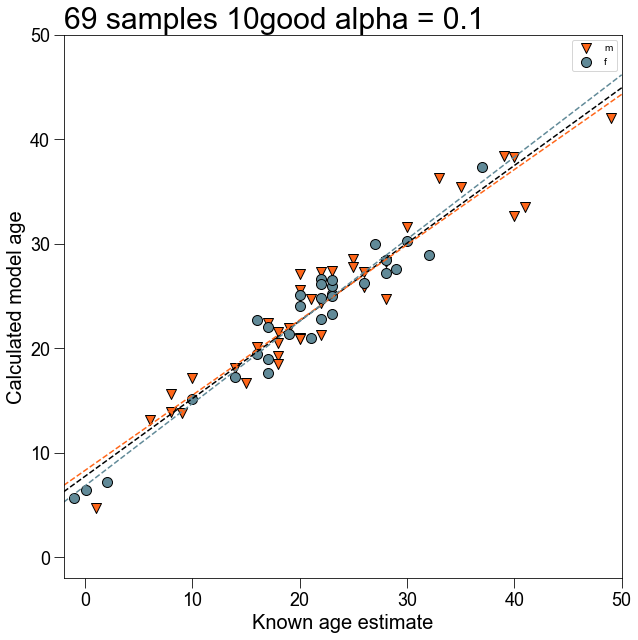

In [74]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_10good_model_cpgs.csv'
samp_69_10good_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a01_clock = make_epigenetic_clock(samp_69_10good_a01_clock_cpgs_path, samp_69_10good_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a01_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a01_clock", 0.1, len(samp_69_10good_a01_clock['cpgs'])-1,
                                                                    samp_69_10good_a01_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a01_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.1')
samp_69_10good_a01_clock_stats_df

The y intercept for this clock model equation is 202.012655129821 .
There are 69 cpgs in the current model
The mean absolute error is 3.589993758549638
The median absolute error is 3.4523272279686275
The mean absolute error for m is 3.8582617297396182
The median absolute error for m is 4.007799651986925
The mean absolute error for f is 3.261149148703856
The median absolute error for f is 3.343276779896275
r-squared: 0.9307879245968724
p-value: 1.4076113463145858e-40
slope: 0.7526711405161595
y-intercept for regression: 8.145418863357808
r-squared for m : 0.9210854529532986
p-value for m : 1.9340891845903913e-21
slope for m : 0.7277492650002754
y-intercept for regression for m : 8.76287171192094
r-squared for f : 0.9487697373526411
p-value for f : 2.922802609356417e-20
slope for f : 0.7967874185498868
y-intercept for regression for f : 7.178030208845492


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a02_clock    0.2          69  all  3.589994  3.452327   
1  samp_69_10good_a02_clock    0.2          69    m  3.858262  4.007800   
2  samp_69_10good_a02_clock    0.2          69    f  3.261149  3.343277   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930788  1.407611e-40          0.752671     8.145419  
1   0.921085  1.934089e-21          0.727749     8.762872  
2   0.948770  2.922803e-20          0.796787     7.178030

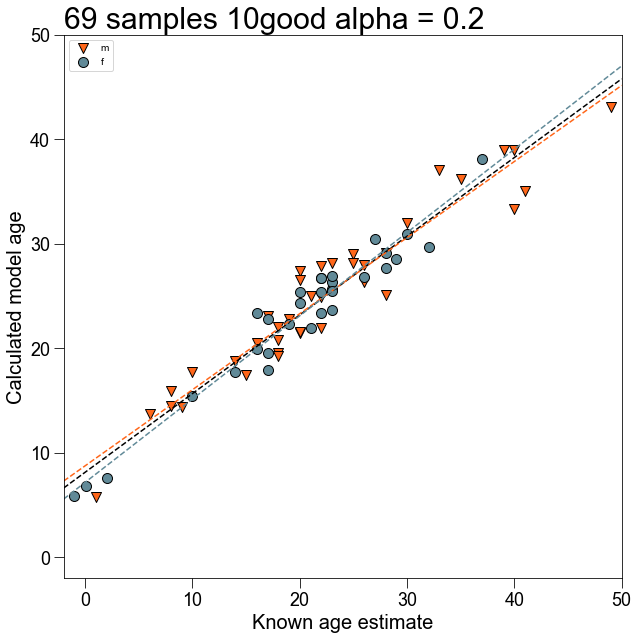

In [75]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_10good_model_cpgs.csv'
samp_69_10good_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a02_clock = make_epigenetic_clock(samp_69_10good_a02_clock_cpgs_path, samp_69_10good_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a02_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a02_clock", 0.2, len(samp_69_10good_a02_clock['cpgs'])-1,
                                                                    samp_69_10good_a02_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a02_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.2')
samp_69_10good_a02_clock_stats_df

The y intercept for this clock model equation is 193.95339673265 .
There are 50 cpgs in the current model
The mean absolute error is 3.5851366829492775
The median absolute error is 3.555867958236149
The mean absolute error for m is 3.8490660710099918
The median absolute error for m is 4.029379339312339
The mean absolute error for f is 3.261610336294212
The median absolute error for f is 3.4211944151724225
r-squared: 0.9328809795067792
p-value: 5.026264253870469e-41
slope: 0.7592492311288497
y-intercept for regression: 8.039475821207542
r-squared for m : 0.9238693410338743
p-value for m : 1.0118207034293027e-21
slope for m : 0.7338274749846287
y-intercept for regression for m : 8.680990862050727
r-squared for f : 0.9498618624821835
p-value for f : 2.137321872461665e-20
slope for f : 0.8038336943069789
y-intercept for regression for f : 7.046811945348303


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_10good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_10good_a03_clock    0.3          50    f  3.261610  3.421194   

   r-squared       p-value  regression_slope  y-intercept  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812

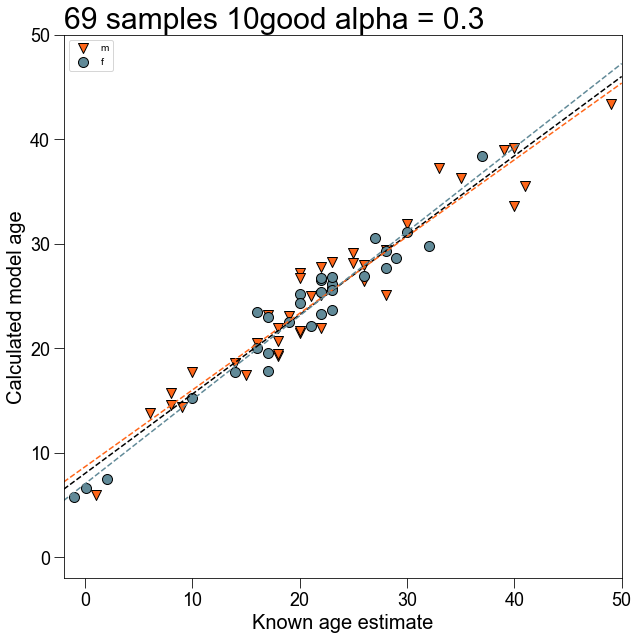

In [76]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_10good_model_cpgs.csv'
samp_69_10good_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a03_clock = make_epigenetic_clock(samp_69_10good_a03_clock_cpgs_path, samp_69_10good_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a03_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a03_clock", 0.3, len(samp_69_10good_a03_clock['cpgs'])-1,
                                                                    samp_69_10good_a03_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a03_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.3')
samp_69_10good_a03_clock_stats_df

The y intercept for this clock model equation is 212.486529486121 .
There are 40 cpgs in the current model
The mean absolute error is 3.2085824467926476
The median absolute error is 3.22752402162903
The mean absolute error for m is 3.482674077078052
The median absolute error for m is 3.6517462249939374
The mean absolute error for f is 2.8725991580556984
The median absolute error for f is 3.0205597744753803
r-squared: 0.9368926573143758
p-value: 6.363422555860014e-42
slope: 0.7744002992599786
y-intercept for regression: 7.289552115071089
r-squared for m : 0.9287462358157852
p-value for m : 3.065438808723207e-22
slope for m : 0.74967076067247
y-intercept for regression for m : 7.91855455258078
r-squared for f : 0.9522935762730216
p-value for f : 1.0381921304341482e-20
slope for f : 0.8175939279560782
y-intercept for regression for f : 6.3214262115225


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_10good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_10good_a04_clock    0.4          40    f  2.872599  3.020560   

   r-squared       p-value  regression_slope  y-intercept  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426

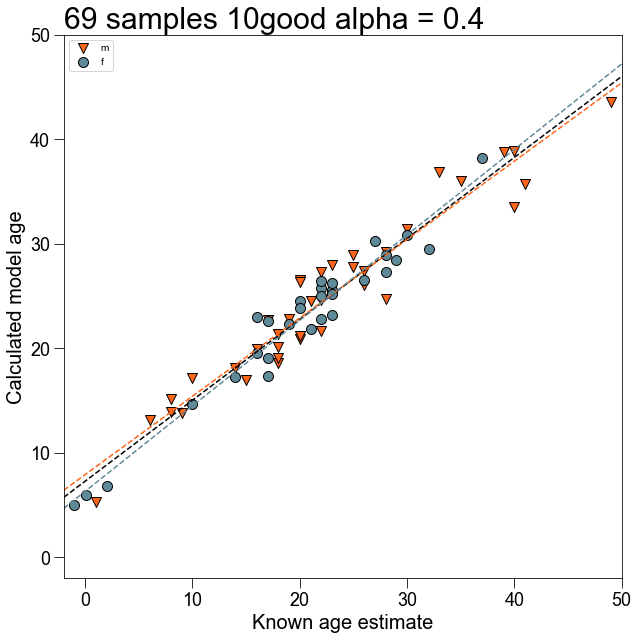

In [77]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_10good_model_cpgs.csv'
samp_69_10good_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a04_clock = make_epigenetic_clock(samp_69_10good_a04_clock_cpgs_path, samp_69_10good_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a04_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a04_clock", 0.4, len(samp_69_10good_a04_clock['cpgs'])-1,
                                                                    samp_69_10good_a04_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a04_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.4')
samp_69_10good_a04_clock_stats_df

The y intercept for this clock model equation is 217.078891347078 .
There are 35 cpgs in the current model
The mean absolute error is 2.8358310094489805
The median absolute error is 2.795535629631779
The mean absolute error for m is 3.1407975621473914
The median absolute error for m is 3.3564575129878094
The mean absolute error for f is 2.4620010416251183
The median absolute error for f is 2.649905668169385
r-squared: 0.9377502693394446
p-value: 4.0218626860355436e-42
slope: 0.7808783933590614
y-intercept for regression: 6.620639250136328
r-squared for m : 0.9301975065733503
p-value for m : 2.1149926235546563e-22
slope for m : 0.7564369073499446
y-intercept for regression for m : 7.246597505721045
r-squared for f : 0.9520821851778768
p-value for f : 1.1070437410236955e-20
slope for f : 0.8234160806495688
y-intercept for regression for f : 5.6616369278254375


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_10good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_10good_a05_clock    0.5          35    f  2.462001  2.649906   

   r-squared       p-value  regression_slope  y-intercept  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637

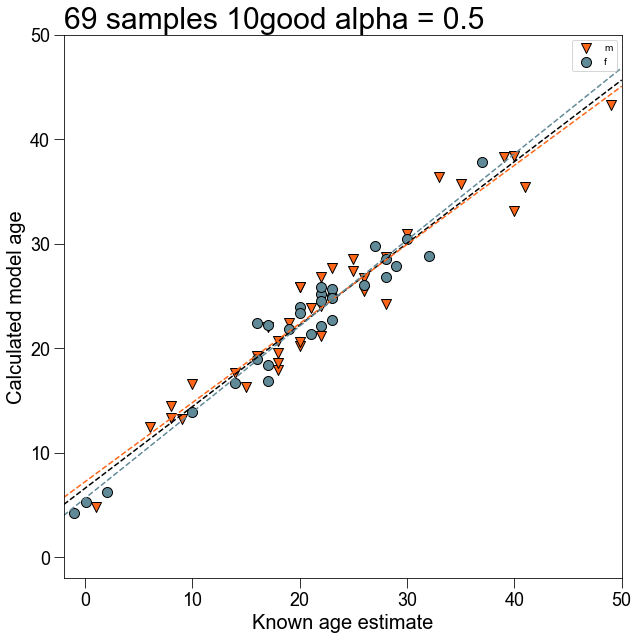

In [78]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_10good_model_cpgs.csv'
samp_69_10good_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a05_clock = make_epigenetic_clock(samp_69_10good_a05_clock_cpgs_path, samp_69_10good_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a05_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a05_clock", 0.5, len(samp_69_10good_a05_clock['cpgs'])-1,
                                                                    samp_69_10good_a05_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a05_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.5')
samp_69_10good_a05_clock_stats_df

The y intercept for this clock model equation is 206.94558158086997 .
There are 31 cpgs in the current model
The mean absolute error is 2.4647435101368695
The median absolute error is 2.119077312258625
The mean absolute error for m is 2.7796309523292186
The median absolute error for m is 2.6067854543765083
The mean absolute error for f is 2.0787524519656033
The median absolute error for f is 1.8656165264584423
r-squared: 0.938032646654764
p-value: 3.4531635540411785e-42
slope: 0.7877227102248987
y-intercept for regression: 5.735381325841004
r-squared for m : 0.930617063263834
p-value for m : 1.8970893029293924e-22
slope for m : 0.7634345288584948
y-intercept for regression for m : 6.357741095186846
r-squared for f : 0.9520571776019631
p-value for f : 1.1154643444675516e-20
slope for f : 0.8299818935101874
y-intercept for regression for f : 4.782229387286527


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_10good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_10good_a06_clock    0.6          31    f  2.078752  1.865617   

   r-squared       p-value  regression_slope  y-intercept  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229

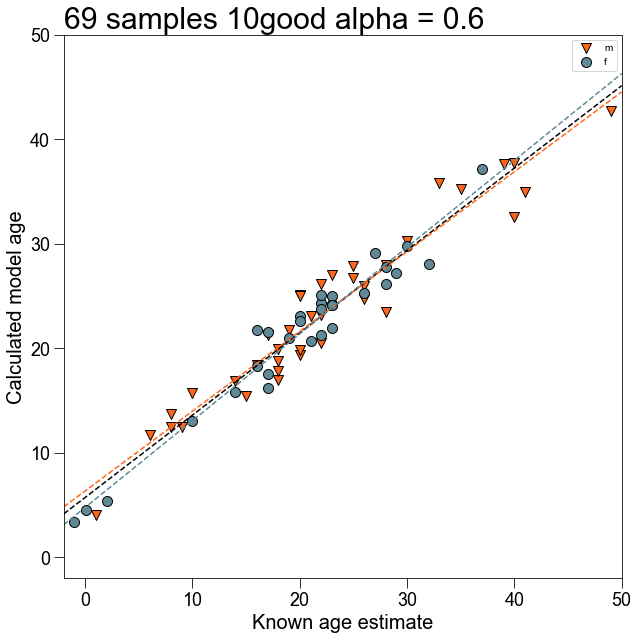

In [79]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_10good_model_cpgs.csv'
samp_69_10good_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a06_clock = make_epigenetic_clock(samp_69_10good_a06_clock_cpgs_path, samp_69_10good_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a06_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a06_clock", 0.6, len(samp_69_10good_a06_clock['cpgs'])-1,
                                                                    samp_69_10good_a06_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a06_sex_specific.eps', 
                                                                    'Beluga Epigenetic Clock')
samp_69_10good_a06_clock_stats_df

The y intercept for this clock model equation is 205.346091305246 .
There are 29 cpgs in the current model
The mean absolute error is 2.219155285993478
The median absolute error is 1.8976412149839703
The mean absolute error for m is 2.567739125147147
The median absolute error for m is 2.071776728939618
The mean absolute error for f is 1.7918589670309168
The median absolute error for f is 1.5737019000960757
r-squared: 0.940554970793685
p-value: 8.571640564286161e-43
slope: 0.801680874941195
y-intercept for regression: 4.679933405286523
r-squared for m : 0.933341010197348
p-value for m : 9.212924739564713e-23
slope for m : 0.7783908737035836
y-intercept for regression for m : 5.2781579560665755
r-squared for f : 0.9539996990276227
p-value for f : 6.117590920819982e-21
slope for f : 0.8421518566673357
y-intercept for regression for f : 3.7652283891619582


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_10good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_10good_a07_clock    0.7          29    f  1.791859  1.573702   

   r-squared       p-value  regression_slope  y-intercept  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228

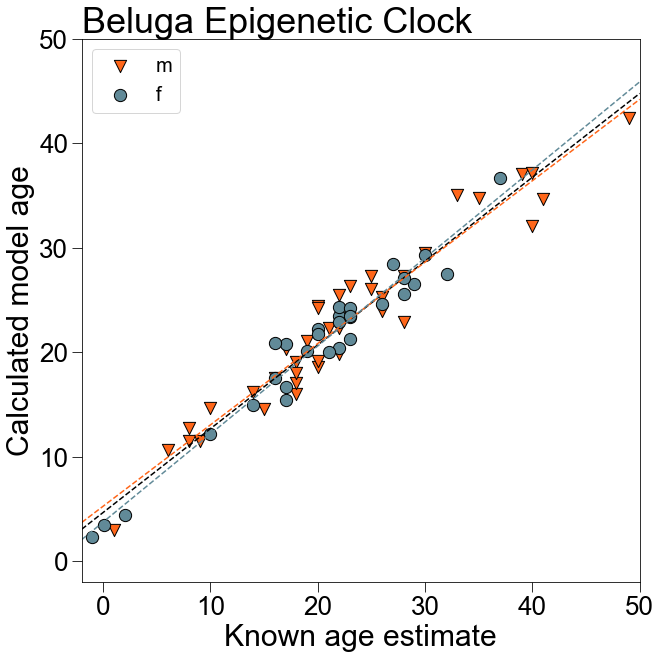

In [145]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_10good_model_cpgs.csv'
samp_69_10good_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a07_clock = make_epigenetic_clock(samp_69_10good_a07_clock_cpgs_path, samp_69_10good_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a07_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a07_clock", 0.7, len(samp_69_10good_a07_clock['cpgs'])-1,
                                                                    samp_69_10good_a07_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a07_sex_specific.eps', 
                                                                    'Beluga Epigenetic Clock')
samp_69_10good_a07_clock_stats_df

The y intercept for this clock model equation is 192.06055266879503 .
There are 28 cpgs in the current model
The mean absolute error is 5.961813688239435
The median absolute error is 5.910300617752057
The mean absolute error for m is 5.989892225406047
The median absolute error for m is 6.167609082454767
The mean absolute error for f is 5.927394836228748
The median absolute error for f is 5.905668086592559
r-squared: 0.9283766076847814
p-value: 4.438891699234272e-40
slope: 0.694830525234254
y-intercept for regression: 12.174749860752
r-squared for m : 0.9261966118000939
p-value for m : 5.77948075515378e-22
slope for m : 0.6647802089833713
y-intercept for regression for m : 12.899324267938994
r-squared for f : 0.9371604129797249
p-value for f : 5.6824990968638185e-19
slope for f : 0.748736559055501
y-intercept for regression for f : 11.018316360655845


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_10good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_10good_a08_clock    0.8          28    f  5.927395  5.905668   

   r-squared       p-value  regression_slope  y-intercept  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316

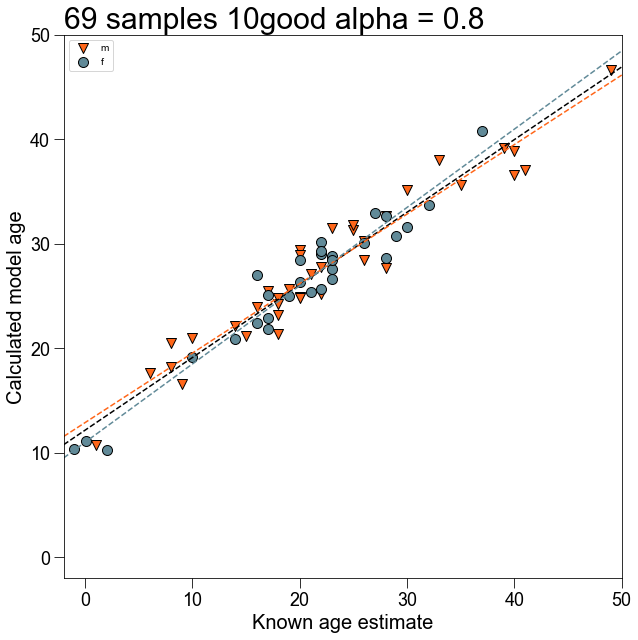

In [81]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_10good_model_cpgs.csv'
samp_69_10good_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a08_clock = make_epigenetic_clock(samp_69_10good_a08_clock_cpgs_path, samp_69_10good_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a08_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a08_clock", 0.8, len(samp_69_10good_a08_clock['cpgs'])-1,
                                                                    samp_69_10good_a08_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a08_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.8')
samp_69_10good_a08_clock_stats_df

The y intercept for this clock model equation is 199.526023437144 .
There are 27 cpgs in the current model
The mean absolute error is 6.336773289363945
The median absolute error is 6.411664213162773
The mean absolute error for m is 6.296480149226432
The median absolute error for m is 6.614041996719502
The mean absolute error for f is 6.386164880500256
The median absolute error for f is 6.263086056219716
r-squared: 0.9302180176225662
p-value: 1.8531883322733637e-40
slope: 0.694736461305528
y-intercept for regression: 12.627386799781467
r-squared for m : 0.9291916259821786
p-value for m : 2.7376439049196324e-22
slope for m : 0.665358248903317
y-intercept for regression for m : 13.330369204665647
r-squared for f : 0.9370655918334018
p-value for f : 5.8083782194431975e-19
slope for f : 0.7476290366397876
y-intercept for regression for f : 11.499526238130882


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_10good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_10good_a09_clock    0.9          27    f  6.386165  6.263086   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526

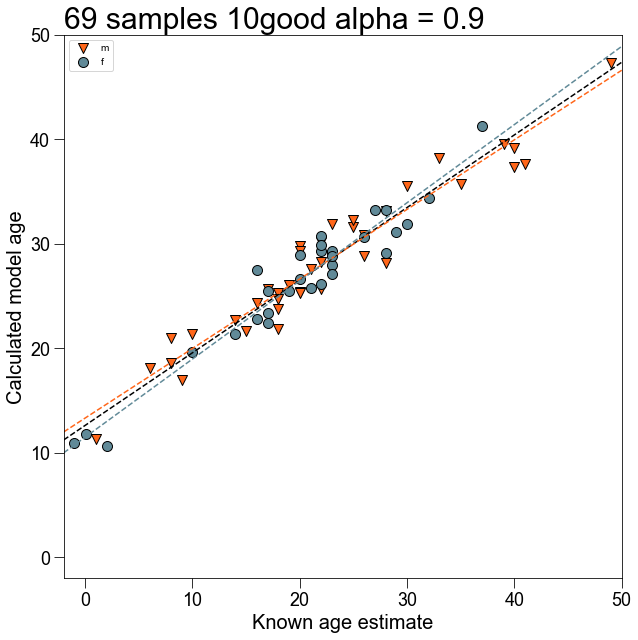

In [82]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_10good_model_cpgs.csv'
samp_69_10good_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a09_clock = make_epigenetic_clock(samp_69_10good_a09_clock_cpgs_path, samp_69_10good_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a09_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a09_clock", 0.9, len(samp_69_10good_a09_clock['cpgs'])-1,
                                                                    samp_69_10good_a09_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a09_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 0.9')
samp_69_10good_a09_clock_stats_df

The y intercept for this clock model equation is 194.72310742005502 .
There are 26 cpgs in the current model
The mean absolute error is 6.547818901705716
The median absolute error is 6.65312140942347
The mean absolute error for m is 6.480524672373766
The median absolute error for m is 6.824492542184698
The mean absolute error for f is 6.630308602177137
The median absolute error for f is 6.507781710047816
r-squared: 0.9297429367150251
p-value: 2.3267040898426055e-40
slope: 0.6914356260509881
y-intercept for regression: 12.933282961231994
r-squared for m : 0.9290117874204165
p-value for m : 2.8657993473318054e-22
slope for m : 0.662033373891777
y-intercept for regression for m : 13.6326207556703
r-squared for f : 0.9362366373247953
p-value for f : 7.024870620704266e-19
slope for f : 0.7445220635013987
y-intercept for regression for f : 11.806621244589124


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a1_clock    1.0          26  all  6.547819  6.653121   
1  samp_69_10good_a1_clock    1.0          26    m  6.480525  6.824493   
2  samp_69_10good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.929743  2.326704e-40          0.691436    12.933283  
1   0.929012  2.865799e-22          0.662033    13.632621  
2   0.936237  7.024871e-19          0.744522    11.806621

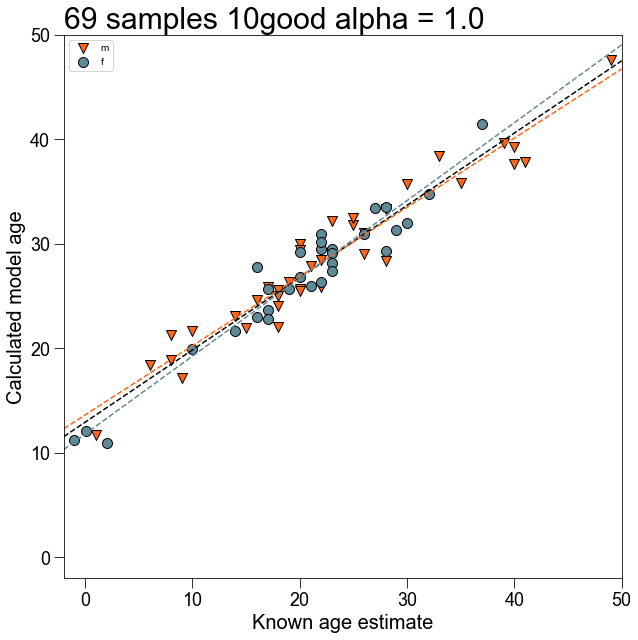

In [83]:
### Using probes filtered for pValue. If either all samples, or all - 10 samples had a bad pValue, the probe was removed. 
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_10good_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_10good_model_cpgs.csv'
samp_69_10good_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_10good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_10good_a1_clock = make_epigenetic_clock(samp_69_10good_a1_clock_cpgs_path, samp_69_10good_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_10good_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_10good_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_10good_a1_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_10good_a1_clock", 1.0, len(samp_69_10good_a1_clock['cpgs'])-1,
                                                                    samp_69_10good_a1_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_10good_a1_sex_specific.eps', 
                                                                    '69 samples 10good alpha = 1.0')
samp_69_10good_a1_clock_stats_df

In [106]:

dfs_for_samp_69_10good = [samp_69_10good_a01_clock_stats_df, samp_69_10good_a02_clock_stats_df,
                                      samp_69_10good_a03_clock_stats_df, samp_69_10good_a04_clock_stats_df,
                                      samp_69_10good_a05_clock_stats_df, samp_69_10good_a06_clock_stats_df,
                                      samp_69_10good_a07_clock_stats_df, samp_69_10good_a08_clock_stats_df,
                                      samp_69_10good_a09_clock_stats_df, samp_69_10good_a1_clock_stats_df]

stats_samp_69_10good_clocks = pd.concat(dfs_for_samp_69_10good)

stats_samp_69_10good_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_69_10good_clocks.csv')


stats_samp_69_10good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_10good_a01_clock    0.1         118  all  3.236403  3.063469   
1  samp_69_10good_a01_clock    0.1         118    m  3.537672  3.440580   
2  samp_69_10good_a01_clock    0.1         118    f  2.867106  2.927096   
0  samp_69_10good_a02_clock    0.2          69  all  3.589994  3.452327   
1  samp_69_10good_a02_clock    0.2          69    m  3.858262  4.007800   
2  samp_69_10good_a02_clock    0.2          69    f  3.261149  3.343277   
0  samp_69_10good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_10good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_10good_a03_clock    0.3          50    f  3.261610  3.421194   
0  samp_69_10good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_10good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_10good_a04_clock    0.4          40    f  2.872599  3.020560   
0  samp_69_10good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_10good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_10good_a05_clock    0.5          35    f  2.462001  2.649906   
0  samp_69_10good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_10good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_10good_a06_clock    0.6          31    f  2.078752  1.865617   
0  samp_69_10good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_10good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_10good_a07_clock    0.7          29    f  1.791859  1.573702   
0  samp_69_10good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_10good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_10good_a08_clock    0.8          28    f  5.927395  5.905668   
0  samp_69_10good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_10good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_10good_a09_clock    0.9          27    f  6.386165  6.263086   
0   samp_69_10good_a1_clock    1.0          26  all  6.547819  6.653121   
1   samp_69_10good_a1_clock    1.0          26    m  6.480525  6.824493   
2   samp_69_10good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925348  1.780372e-39          0.743119     7.766617  
1   0.914874  7.588264e-21          0.719340     8.329319  
2   0.944318  9.805959e-20          0.786155     6.856888  
0   0.930788  1.407611e-40          0.752671     8.145419  
1   0.921085  1.934089e-21          0.727749     8.762872  
2   0.948770  2.922803e-20          0.796787     7.178030  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526  
0   0.92974

## For pValue 20good 

The y intercept for this clock model equation is 205.971030976414 .
There are 116 cpgs in the current model
The mean absolute error is 3.2300013820340054
The median absolute error is 3.094606837500166
The mean absolute error for m is 3.5318685757788555
The median absolute error for m is 3.4313193551370063
The mean absolute error for f is 2.85997062841129
The median absolute error for f is 2.92159737855577
r-squared: 0.9251636909187863
p-value: 1.9338789757785607e-39
slope: 0.7430650078689274
y-intercept for regression: 7.756300206512291
r-squared for m : 0.9148203380464305
p-value for m : 7.67527059540337e-21
slope for m : 0.7193784716487002
y-intercept for regression for m : 8.318654279892378
r-squared for f : 0.9438790104510836
p-value for f : 1.0990755875113045e-19
slope for f : 0.7858685012352268
y-intercept for regression for f : 6.849178490879302


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a01_clock    0.1         116  all  3.230001  3.094607   
1  samp_69_20good_a01_clock    0.1         116    m  3.531869  3.431319   
2  samp_69_20good_a01_clock    0.1         116    f  2.859971  2.921597   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925164  1.933879e-39          0.743065     7.756300  
1   0.914820  7.675271e-21          0.719378     8.318654  
2   0.943879  1.099076e-19          0.785869     6.849178

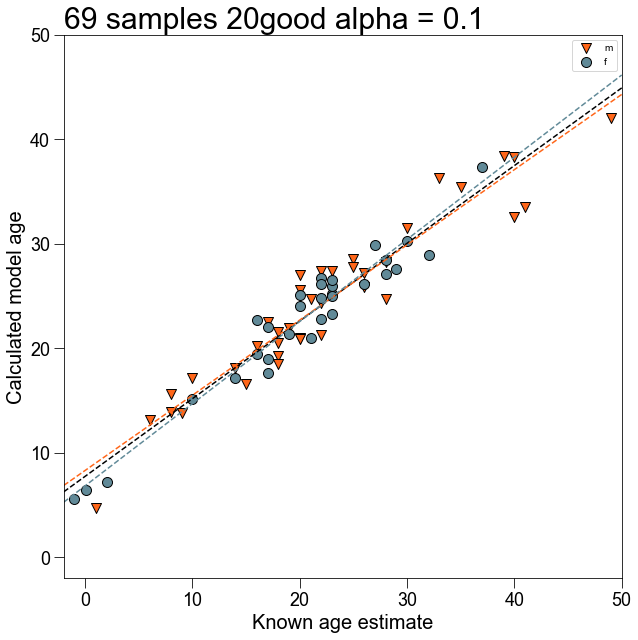

In [84]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_20good_model_cpgs.csv'
samp_69_20good_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a01_clock = make_epigenetic_clock(samp_69_20good_a01_clock_cpgs_path, samp_69_20good_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a01_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a01_clock", 0.1, len(samp_69_20good_a01_clock['cpgs'])-1,
                                                                    samp_69_20good_a01_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a01_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.1')
samp_69_20good_a01_clock_stats_df

The y intercept for this clock model equation is 202.114464417485 .
There are 68 cpgs in the current model
The mean absolute error is 3.5875200555783584
The median absolute error is 3.44553099322167
The mean absolute error for m is 3.8562926982544026
The median absolute error for m is 4.004645776514421
The mean absolute error for f is 3.2580568161690167
The median absolute error for f is 3.3399117299795194
r-squared: 0.9307694402306919
p-value: 1.4202734305998322e-40
slope: 0.7526799455085915
y-intercept for regression: 8.141342449402106
r-squared for m : 0.9210795149345015
p-value for m : 1.9367163415959454e-21
slope for m : 0.7277612424131318
y-intercept for regression for m : 8.759037497672608
r-squared for f : 0.9487283142393215
p-value for f : 2.957318067733991e-20
slope for f : 0.7967791604360845
y-intercept for regression for f : 7.173915639753826


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a02_clock    0.2          68  all  3.587520  3.445531   
1  samp_69_20good_a02_clock    0.2          68    m  3.856293  4.004646   
2  samp_69_20good_a02_clock    0.2          68    f  3.258057  3.339912   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930769  1.420273e-40          0.752680     8.141342  
1   0.921080  1.936716e-21          0.727761     8.759037  
2   0.948728  2.957318e-20          0.796779     7.173916

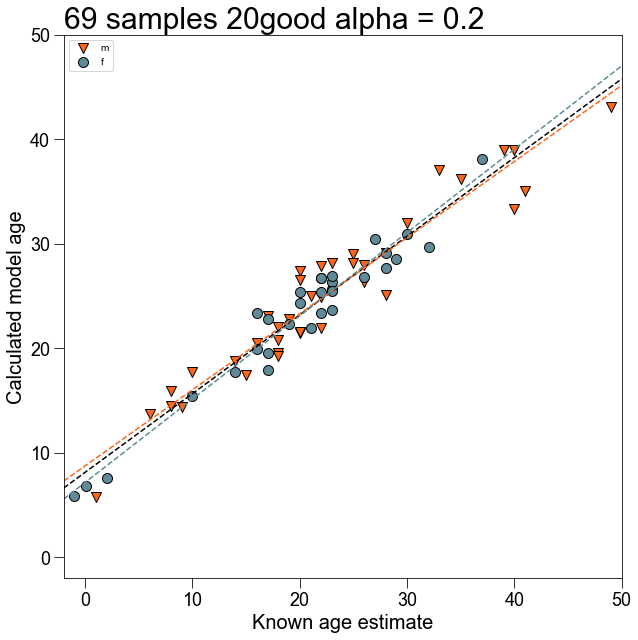

In [85]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_20good_model_cpgs.csv'
samp_69_20good_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a02_clock = make_epigenetic_clock(samp_69_20good_a02_clock_cpgs_path, samp_69_20good_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a02_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a02_clock", 0.2, len(samp_69_20good_a02_clock['cpgs'])-1,
                                                                    samp_69_20good_a02_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a02_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.2')
samp_69_20good_a02_clock_stats_df

The y intercept for this clock model equation is 193.95339673265 .
There are 50 cpgs in the current model
The mean absolute error is 3.5851366829492775
The median absolute error is 3.555867958236149
The mean absolute error for m is 3.8490660710099918
The median absolute error for m is 4.029379339312339
The mean absolute error for f is 3.261610336294212
The median absolute error for f is 3.4211944151724225
r-squared: 0.9328809795067792
p-value: 5.026264253870469e-41
slope: 0.7592492311288497
y-intercept for regression: 8.039475821207542
r-squared for m : 0.9238693410338743
p-value for m : 1.0118207034293027e-21
slope for m : 0.7338274749846287
y-intercept for regression for m : 8.680990862050727
r-squared for f : 0.9498618624821835
p-value for f : 2.137321872461665e-20
slope for f : 0.8038336943069789
y-intercept for regression for f : 7.046811945348303


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_20good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_20good_a03_clock    0.3          50    f  3.261610  3.421194   

   r-squared       p-value  regression_slope  y-intercept  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812

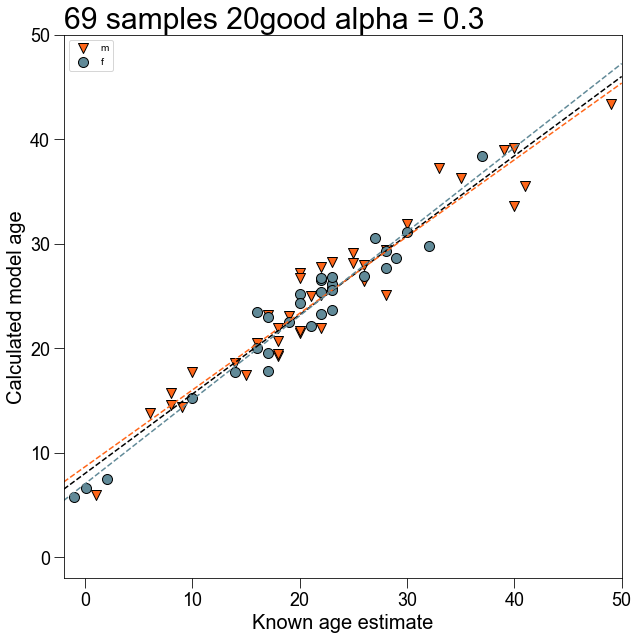

In [86]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_20good_model_cpgs.csv'
samp_69_20good_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a03_clock = make_epigenetic_clock(samp_69_20good_a03_clock_cpgs_path, samp_69_20good_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a03_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a03_clock", 0.3, len(samp_69_20good_a03_clock['cpgs'])-1,
                                                                    samp_69_20good_a03_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a03_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.3')
samp_69_20good_a03_clock_stats_df

The y intercept for this clock model equation is 212.486529486121 .
There are 40 cpgs in the current model
The mean absolute error is 3.2085824467926476
The median absolute error is 3.22752402162903
The mean absolute error for m is 3.482674077078052
The median absolute error for m is 3.6517462249939374
The mean absolute error for f is 2.8725991580556984
The median absolute error for f is 3.0205597744753803
r-squared: 0.9368926573143758
p-value: 6.363422555860014e-42
slope: 0.7744002992599786
y-intercept for regression: 7.289552115071089
r-squared for m : 0.9287462358157852
p-value for m : 3.065438808723207e-22
slope for m : 0.74967076067247
y-intercept for regression for m : 7.91855455258078
r-squared for f : 0.9522935762730216
p-value for f : 1.0381921304341482e-20
slope for f : 0.8175939279560782
y-intercept for regression for f : 6.3214262115225


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_20good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_20good_a04_clock    0.4          40    f  2.872599  3.020560   

   r-squared       p-value  regression_slope  y-intercept  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426

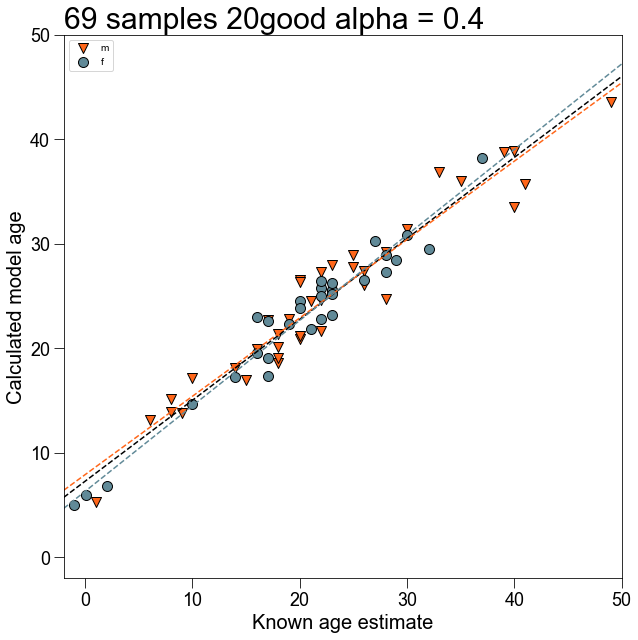

In [87]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_20good_model_cpgs.csv'
samp_69_20good_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a04_clock = make_epigenetic_clock(samp_69_20good_a04_clock_cpgs_path, samp_69_20good_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a04_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a04_clock", 0.4, len(samp_69_20good_a04_clock['cpgs'])-1,
                                                                    samp_69_20good_a04_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a04_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.4')
samp_69_20good_a04_clock_stats_df

The y intercept for this clock model equation is 217.078891347078 .
There are 35 cpgs in the current model
The mean absolute error is 2.8358310094489805
The median absolute error is 2.795535629631779
The mean absolute error for m is 3.1407975621473914
The median absolute error for m is 3.3564575129878094
The mean absolute error for f is 2.4620010416251183
The median absolute error for f is 2.649905668169385
r-squared: 0.9377502693394446
p-value: 4.0218626860355436e-42
slope: 0.7808783933590614
y-intercept for regression: 6.620639250136328
r-squared for m : 0.9301975065733503
p-value for m : 2.1149926235546563e-22
slope for m : 0.7564369073499446
y-intercept for regression for m : 7.246597505721045
r-squared for f : 0.9520821851778768
p-value for f : 1.1070437410236955e-20
slope for f : 0.8234160806495688
y-intercept for regression for f : 5.6616369278254375


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_20good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_20good_a05_clock    0.5          35    f  2.462001  2.649906   

   r-squared       p-value  regression_slope  y-intercept  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637

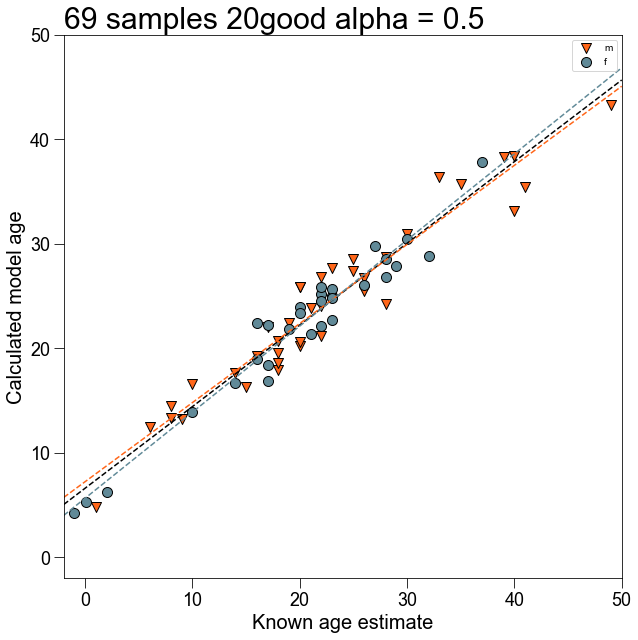

In [88]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_20good_model_cpgs.csv'
samp_69_20good_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a05_clock = make_epigenetic_clock(samp_69_20good_a05_clock_cpgs_path, samp_69_20good_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a05_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a05_clock", 0.5, len(samp_69_20good_a05_clock['cpgs'])-1,
                                                                    samp_69_20good_a05_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a05_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.5')
samp_69_20good_a05_clock_stats_df

The y intercept for this clock model equation is 206.94558158086997 .
There are 31 cpgs in the current model
The mean absolute error is 2.4647435101368695
The median absolute error is 2.119077312258625
The mean absolute error for m is 2.7796309523292186
The median absolute error for m is 2.6067854543765083
The mean absolute error for f is 2.0787524519656033
The median absolute error for f is 1.8656165264584423
r-squared: 0.938032646654764
p-value: 3.4531635540411785e-42
slope: 0.7877227102248987
y-intercept for regression: 5.735381325841004
r-squared for m : 0.930617063263834
p-value for m : 1.8970893029293924e-22
slope for m : 0.7634345288584948
y-intercept for regression for m : 6.357741095186846
r-squared for f : 0.9520571776019631
p-value for f : 1.1154643444675516e-20
slope for f : 0.8299818935101874
y-intercept for regression for f : 4.782229387286527


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_20good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_20good_a06_clock    0.6          31    f  2.078752  1.865617   

   r-squared       p-value  regression_slope  y-intercept  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229

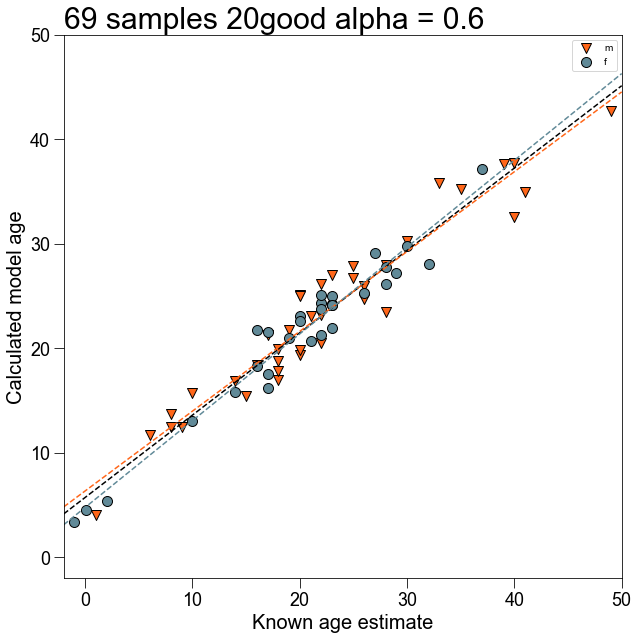

In [89]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_20good_model_cpgs.csv'
samp_69_20good_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a06_clock = make_epigenetic_clock(samp_69_20good_a06_clock_cpgs_path, samp_69_20good_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a06_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a06_clock", 0.6, len(samp_69_20good_a06_clock['cpgs'])-1,
                                                                    samp_69_20good_a06_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a06_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.6')
samp_69_20good_a06_clock_stats_df

The y intercept for this clock model equation is 205.346091305246 .
There are 29 cpgs in the current model
The mean absolute error is 2.219155285993478
The median absolute error is 1.8976412149839703
The mean absolute error for m is 2.567739125147147
The median absolute error for m is 2.071776728939618
The mean absolute error for f is 1.7918589670309168
The median absolute error for f is 1.5737019000960757
r-squared: 0.940554970793685
p-value: 8.571640564286161e-43
slope: 0.801680874941195
y-intercept for regression: 4.679933405286523
r-squared for m : 0.933341010197348
p-value for m : 9.212924739564713e-23
slope for m : 0.7783908737035836
y-intercept for regression for m : 5.2781579560665755
r-squared for f : 0.9539996990276227
p-value for f : 6.117590920819982e-21
slope for f : 0.8421518566673357
y-intercept for regression for f : 3.7652283891619582


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_20good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_20good_a07_clock    0.7          29    f  1.791859  1.573702   

   r-squared       p-value  regression_slope  y-intercept  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228

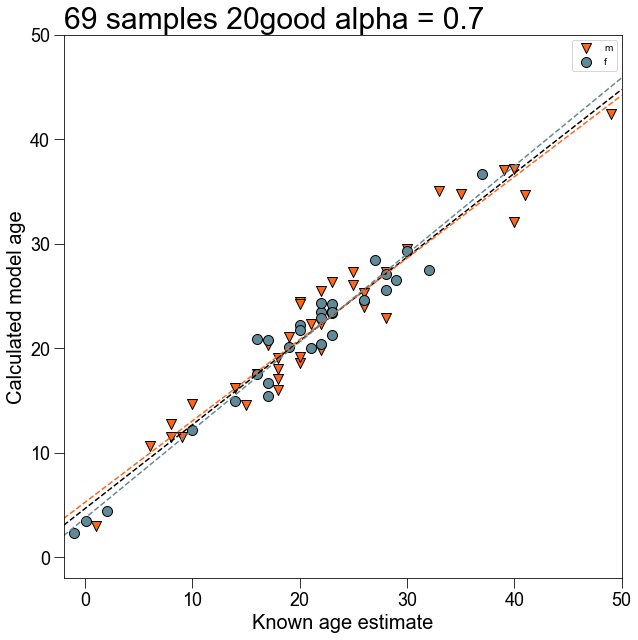

In [90]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_20good_model_cpgs.csv'
samp_69_20good_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a07_clock = make_epigenetic_clock(samp_69_20good_a07_clock_cpgs_path, samp_69_20good_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a07_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a07_clock", 0.7, len(samp_69_20good_a07_clock['cpgs'])-1,
                                                                    samp_69_20good_a07_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a07_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.7')
samp_69_20good_a07_clock_stats_df

The y intercept for this clock model equation is 192.06055266879503 .
There are 28 cpgs in the current model
The mean absolute error is 5.961813688239435
The median absolute error is 5.910300617752057
The mean absolute error for m is 5.989892225406047
The median absolute error for m is 6.167609082454767
The mean absolute error for f is 5.927394836228748
The median absolute error for f is 5.905668086592559
r-squared: 0.9283766076847814
p-value: 4.438891699234272e-40
slope: 0.694830525234254
y-intercept for regression: 12.174749860752
r-squared for m : 0.9261966118000939
p-value for m : 5.77948075515378e-22
slope for m : 0.6647802089833713
y-intercept for regression for m : 12.899324267938994
r-squared for f : 0.9371604129797249
p-value for f : 5.6824990968638185e-19
slope for f : 0.748736559055501
y-intercept for regression for f : 11.018316360655845


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_20good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_20good_a08_clock    0.8          28    f  5.927395  5.905668   

   r-squared       p-value  regression_slope  y-intercept  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316

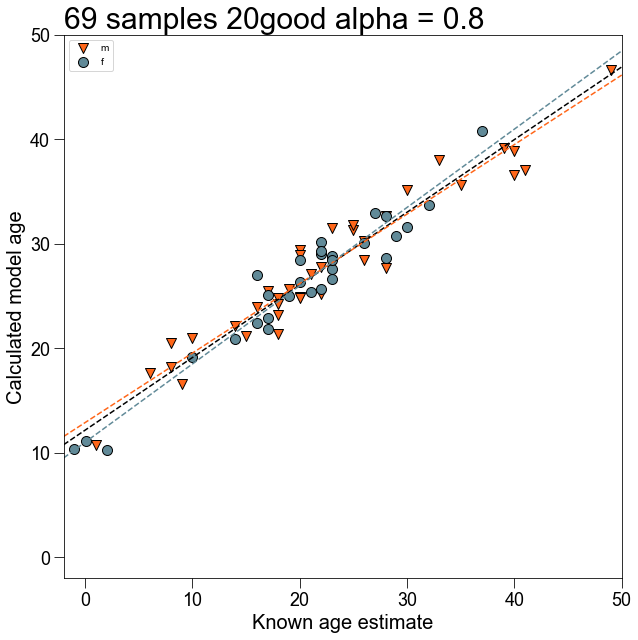

In [91]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_20good_model_cpgs.csv'
samp_69_20good_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a08_clock = make_epigenetic_clock(samp_69_20good_a08_clock_cpgs_path, samp_69_20good_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a08_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a08_clock", 0.8, len(samp_69_20good_a08_clock['cpgs'])-1,
                                                                    samp_69_20good_a08_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a08_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.8')
samp_69_20good_a08_clock_stats_df

The y intercept for this clock model equation is 199.526023437144 .
There are 27 cpgs in the current model
The mean absolute error is 6.336773289363945
The median absolute error is 6.411664213162773
The mean absolute error for m is 6.296480149226432
The median absolute error for m is 6.614041996719502
The mean absolute error for f is 6.386164880500256
The median absolute error for f is 6.263086056219716
r-squared: 0.9302180176225662
p-value: 1.8531883322733637e-40
slope: 0.694736461305528
y-intercept for regression: 12.627386799781467
r-squared for m : 0.9291916259821786
p-value for m : 2.7376439049196324e-22
slope for m : 0.665358248903317
y-intercept for regression for m : 13.330369204665647
r-squared for f : 0.9370655918334018
p-value for f : 5.8083782194431975e-19
slope for f : 0.7476290366397876
y-intercept for regression for f : 11.499526238130882


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_20good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_20good_a09_clock    0.9          27    f  6.386165  6.263086   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526

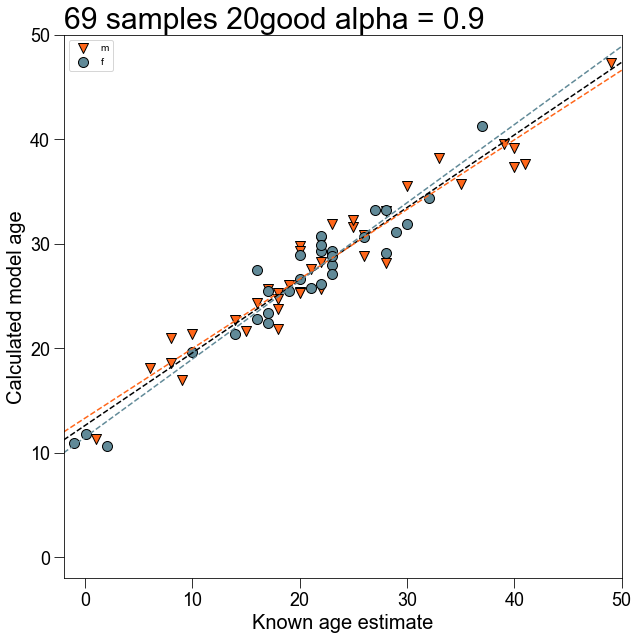

In [92]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_20good_model_cpgs.csv'
samp_69_20good_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a09_clock = make_epigenetic_clock(samp_69_20good_a09_clock_cpgs_path, samp_69_20good_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a09_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a09_clock", 0.9, len(samp_69_20good_a09_clock['cpgs'])-1,
                                                                    samp_69_20good_a09_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a09_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 0.9')
samp_69_20good_a09_clock_stats_df

The y intercept for this clock model equation is 194.72310742005502 .
There are 26 cpgs in the current model
The mean absolute error is 6.547818901705716
The median absolute error is 6.65312140942347
The mean absolute error for m is 6.480524672373766
The median absolute error for m is 6.824492542184698
The mean absolute error for f is 6.630308602177137
The median absolute error for f is 6.507781710047816
r-squared: 0.9297429367150251
p-value: 2.3267040898426055e-40
slope: 0.6914356260509881
y-intercept for regression: 12.933282961231994
r-squared for m : 0.9290117874204165
p-value for m : 2.8657993473318054e-22
slope for m : 0.662033373891777
y-intercept for regression for m : 13.6326207556703
r-squared for f : 0.9362366373247953
p-value for f : 7.024870620704266e-19
slope for f : 0.7445220635013987
y-intercept for regression for f : 11.806621244589124


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a1_clock    1.0          26  all  6.547819  6.653121   
1  samp_69_20good_a1_clock    1.0          26    m  6.480525  6.824493   
2  samp_69_20good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.929743  2.326704e-40          0.691436    12.933283  
1   0.929012  2.865799e-22          0.662033    13.632621  
2   0.936237  7.024871e-19          0.744522    11.806621

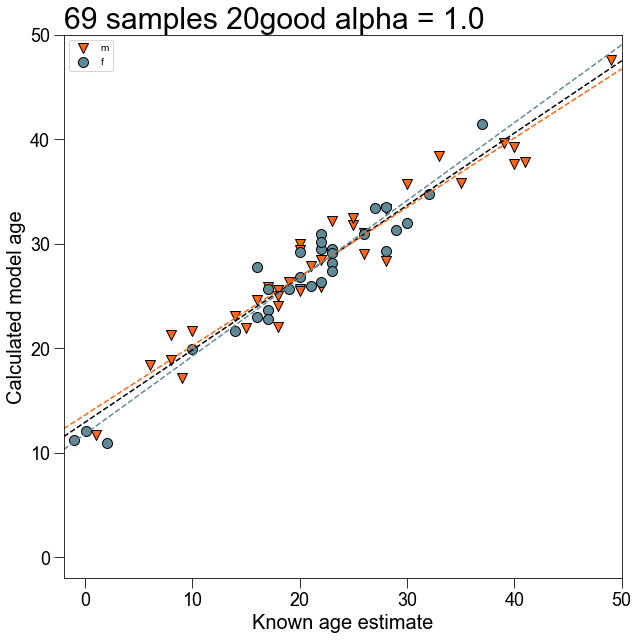

In [93]:
### Using probes filtered for pValue. If either all samples, or all - 20 samples had a bad pValue, the probe was removed. 
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_20good_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_20good_model_cpgs.csv'
samp_69_20good_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_20good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_20good_a1_clock = make_epigenetic_clock(samp_69_20good_a1_clock_cpgs_path, samp_69_20good_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_20good_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_20good_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_20good_a1_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_20good_a1_clock", 1.0, len(samp_69_20good_a1_clock['cpgs'])-1,
                                                                    samp_69_20good_a1_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_20good_a1_sex_specific.eps', 
                                                                    '69 samples 20good alpha = 1.0')
samp_69_20good_a1_clock_stats_df

In [107]:

dfs_for_samp_69_20good = [samp_69_20good_a01_clock_stats_df, samp_69_20good_a02_clock_stats_df,
                                      samp_69_20good_a03_clock_stats_df, samp_69_20good_a04_clock_stats_df,
                                      samp_69_20good_a05_clock_stats_df, samp_69_20good_a06_clock_stats_df,
                                      samp_69_20good_a07_clock_stats_df, samp_69_20good_a08_clock_stats_df,
                                      samp_69_20good_a09_clock_stats_df, samp_69_20good_a1_clock_stats_df]

stats_samp_69_20good_clocks = pd.concat(dfs_for_samp_69_20good)
    
stats_samp_69_20good_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_69_20good_clocks.csv')

stats_samp_69_20good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_20good_a01_clock    0.1         116  all  3.230001  3.094607   
1  samp_69_20good_a01_clock    0.1         116    m  3.531869  3.431319   
2  samp_69_20good_a01_clock    0.1         116    f  2.859971  2.921597   
0  samp_69_20good_a02_clock    0.2          68  all  3.587520  3.445531   
1  samp_69_20good_a02_clock    0.2          68    m  3.856293  4.004646   
2  samp_69_20good_a02_clock    0.2          68    f  3.258057  3.339912   
0  samp_69_20good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_20good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_20good_a03_clock    0.3          50    f  3.261610  3.421194   
0  samp_69_20good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_20good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_20good_a04_clock    0.4          40    f  2.872599  3.020560   
0  samp_69_20good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_20good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_20good_a05_clock    0.5          35    f  2.462001  2.649906   
0  samp_69_20good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_20good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_20good_a06_clock    0.6          31    f  2.078752  1.865617   
0  samp_69_20good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_20good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_20good_a07_clock    0.7          29    f  1.791859  1.573702   
0  samp_69_20good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_20good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_20good_a08_clock    0.8          28    f  5.927395  5.905668   
0  samp_69_20good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_20good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_20good_a09_clock    0.9          27    f  6.386165  6.263086   
0   samp_69_20good_a1_clock    1.0          26  all  6.547819  6.653121   
1   samp_69_20good_a1_clock    1.0          26    m  6.480525  6.824493   
2   samp_69_20good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925164  1.933879e-39          0.743065     7.756300  
1   0.914820  7.675271e-21          0.719378     8.318654  
2   0.943879  1.099076e-19          0.785869     6.849178  
0   0.930769  1.420273e-40          0.752680     8.141342  
1   0.921080  1.936716e-21          0.727761     8.759037  
2   0.948728  2.957318e-20          0.796779     7.173916  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526  
0   0.92974

## For pValues 30good 

The y intercept for this clock model equation is 203.53642316915798 .
There are 116 cpgs in the current model
The mean absolute error is 3.2659066475983454
The median absolute error is 3.0538140292939566
The mean absolute error for m is 3.562363173533649
The median absolute error for m is 3.484874530277308
The mean absolute error for f is 2.9025083254841024
The median absolute error for f is 2.9470833368065072
r-squared: 0.9250065646120067
p-value: 2.0748170012342173e-39
slope: 0.7426349611140101
y-intercept for regression: 7.813861233649883
r-squared for m : 0.914704010747901
p-value for m : 7.866622458676523e-21
slope for m : 0.7187125565756953
y-intercept for regression for m : 8.377615225671008
r-squared for f : 0.943734419930987
p-value for f : 1.1409379907465382e-19
slope for f : 0.7860145584747003
y-intercept for regression for f : 6.899818235537474


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a01_clock    0.1         116  all  3.265907  3.053814   
1  samp_69_30good_a01_clock    0.1         116    m  3.562363  3.484875   
2  samp_69_30good_a01_clock    0.1         116    f  2.902508  2.947083   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925007  2.074817e-39          0.742635     7.813861  
1   0.914704  7.866622e-21          0.718713     8.377615  
2   0.943734  1.140938e-19          0.786015     6.899818

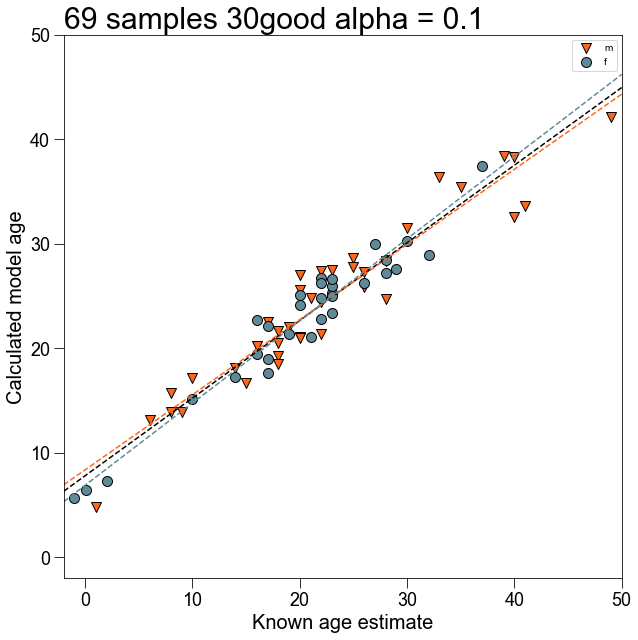

In [94]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.1

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a01_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_30good_model_cpgs.csv'
samp_69_30good_a01_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a01_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a01_clock = make_epigenetic_clock(samp_69_30good_a01_clock_cpgs_path, samp_69_30good_a01_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a01_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a01_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a01_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a01_clock", 0.1, len(samp_69_30good_a01_clock['cpgs'])-1,
                                                                    samp_69_30good_a01_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a01_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.1')
samp_69_30good_a01_clock_stats_df

The y intercept for this clock model equation is 200.84548765438598 .
There are 67 cpgs in the current model
The mean absolute error is 3.612398733260886
The median absolute error is 3.4905098746724192
The mean absolute error for m is 3.878176335566522
The median absolute error for m is 4.046010959204949
The mean absolute error for f is 3.286606833660427
The median absolute error for f is 3.3636344320655134
r-squared: 0.9307602709658246
p-value: 1.4265954592113774e-40
slope: 0.7524570598279658
y-intercept for regression: 8.17971123902333
r-squared for m : 0.9210757337046053
p-value for m : 1.9383910272217673e-21
slope for m : 0.7274600589923783
y-intercept for regression for m : 8.797850820592487
r-squared for f : 0.9487356137785485
p-value for f : 2.951208368698205e-20
slope for f : 0.796748235533586
y-intercept for regression for f : 7.209997018053034


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a02_clock    0.2          67  all  3.612399  3.490510   
1  samp_69_30good_a02_clock    0.2          67    m  3.878176  4.046011   
2  samp_69_30good_a02_clock    0.2          67    f  3.286607  3.363634   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930760  1.426595e-40          0.752457     8.179711  
1   0.921076  1.938391e-21          0.727460     8.797851  
2   0.948736  2.951208e-20          0.796748     7.209997

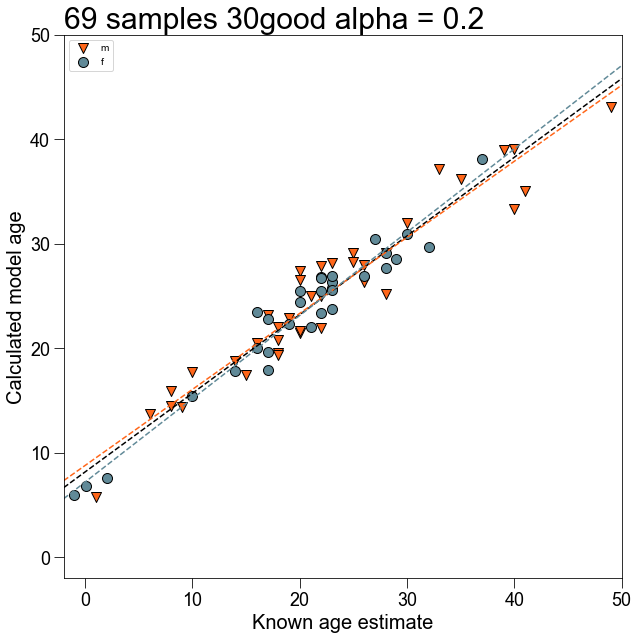

In [95]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.2

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a02_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_30good_model_cpgs.csv'
samp_69_30good_a02_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a02_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a02_clock = make_epigenetic_clock(samp_69_30good_a02_clock_cpgs_path, samp_69_30good_a02_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a02_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a02_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a02_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a02_clock", 0.2, len(samp_69_30good_a02_clock['cpgs'])-1,
                                                                    samp_69_30good_a02_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a02_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.2')
samp_69_30good_a02_clock_stats_df

The y intercept for this clock model equation is 193.95339673265 .
There are 50 cpgs in the current model
The mean absolute error is 3.5851366829492775
The median absolute error is 3.555867958236149
The mean absolute error for m is 3.8490660710099918
The median absolute error for m is 4.029379339312339
The mean absolute error for f is 3.261610336294212
The median absolute error for f is 3.4211944151724225
r-squared: 0.9328809795067792
p-value: 5.026264253870469e-41
slope: 0.7592492311288497
y-intercept for regression: 8.039475821207542
r-squared for m : 0.9238693410338743
p-value for m : 1.0118207034293027e-21
slope for m : 0.7338274749846287
y-intercept for regression for m : 8.680990862050727
r-squared for f : 0.9498618624821835
p-value for f : 2.137321872461665e-20
slope for f : 0.8038336943069789
y-intercept for regression for f : 7.046811945348303


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_30good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_30good_a03_clock    0.3          50    f  3.261610  3.421194   

   r-squared       p-value  regression_slope  y-intercept  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812

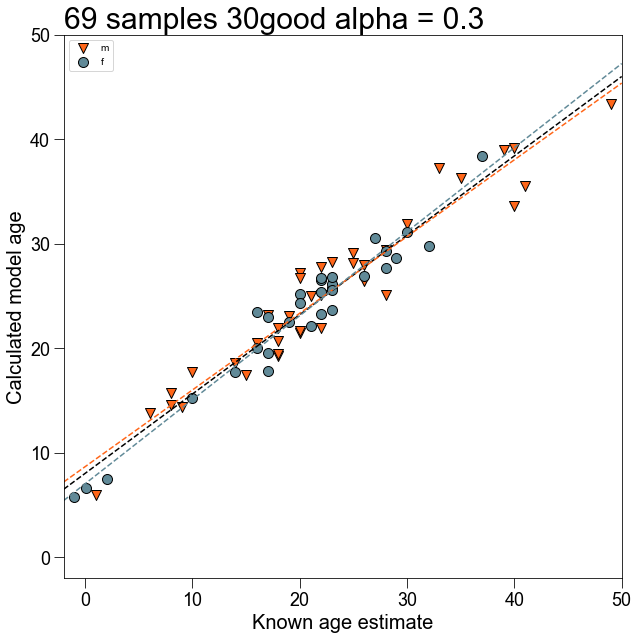

In [108]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.3

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a03_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_30good_model_cpgs.csv'
samp_69_30good_a03_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a03_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a03_clock = make_epigenetic_clock(samp_69_30good_a03_clock_cpgs_path, samp_69_30good_a03_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a03_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a03_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a03_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a03_clock", 0.3, len(samp_69_30good_a03_clock['cpgs'])-1,
                                                                    samp_69_30good_a03_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a03_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.3')
samp_69_30good_a03_clock_stats_df

The y intercept for this clock model equation is 212.486529486121 .
There are 40 cpgs in the current model
The mean absolute error is 3.2085824467926476
The median absolute error is 3.22752402162903
The mean absolute error for m is 3.482674077078052
The median absolute error for m is 3.6517462249939374
The mean absolute error for f is 2.8725991580556984
The median absolute error for f is 3.0205597744753803
r-squared: 0.9368926573143758
p-value: 6.363422555860014e-42
slope: 0.7744002992599786
y-intercept for regression: 7.289552115071089
r-squared for m : 0.9287462358157852
p-value for m : 3.065438808723207e-22
slope for m : 0.74967076067247
y-intercept for regression for m : 7.91855455258078
r-squared for f : 0.9522935762730216
p-value for f : 1.0381921304341482e-20
slope for f : 0.8175939279560782
y-intercept for regression for f : 6.3214262115225


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_30good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_30good_a04_clock    0.4          40    f  2.872599  3.020560   

   r-squared       p-value  regression_slope  y-intercept  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426

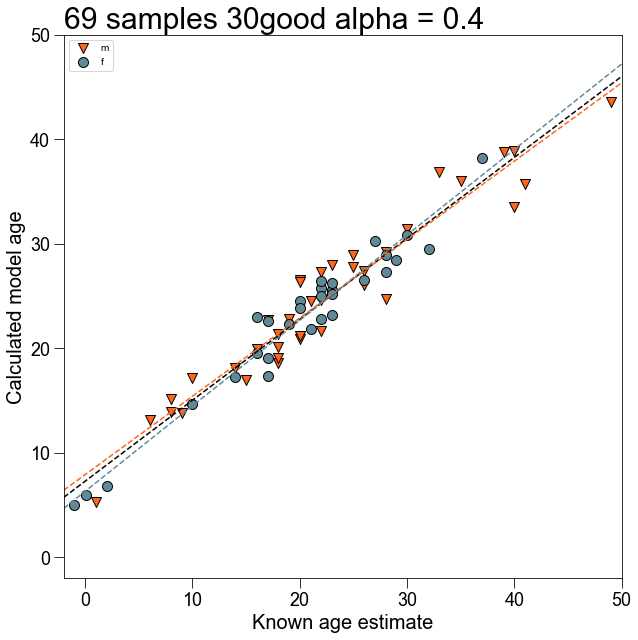

In [109]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.4

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a04_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_30good_model_cpgs.csv'
samp_69_30good_a04_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a04_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a04_clock = make_epigenetic_clock(samp_69_30good_a04_clock_cpgs_path, samp_69_30good_a04_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a04_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a04_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a04_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a04_clock", 0.4, len(samp_69_30good_a04_clock['cpgs'])-1,
                                                                    samp_69_30good_a04_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a04_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.4')
samp_69_30good_a04_clock_stats_df

The y intercept for this clock model equation is 217.078891347078 .
There are 35 cpgs in the current model
The mean absolute error is 2.8358310094489805
The median absolute error is 2.795535629631779
The mean absolute error for m is 3.1407975621473914
The median absolute error for m is 3.3564575129878094
The mean absolute error for f is 2.4620010416251183
The median absolute error for f is 2.649905668169385
r-squared: 0.9377502693394446
p-value: 4.0218626860355436e-42
slope: 0.7808783933590614
y-intercept for regression: 6.620639250136328
r-squared for m : 0.9301975065733503
p-value for m : 2.1149926235546563e-22
slope for m : 0.7564369073499446
y-intercept for regression for m : 7.246597505721045
r-squared for f : 0.9520821851778768
p-value for f : 1.1070437410236955e-20
slope for f : 0.8234160806495688
y-intercept for regression for f : 5.6616369278254375


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_30good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_30good_a05_clock    0.5          35    f  2.462001  2.649906   

   r-squared       p-value  regression_slope  y-intercept  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637

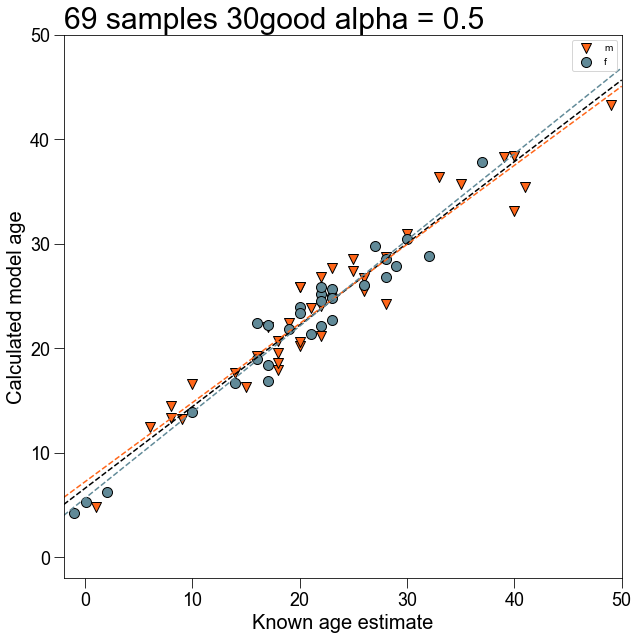

In [110]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.5

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a05_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_30good_model_cpgs.csv'
samp_69_30good_a05_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a05_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a05_clock = make_epigenetic_clock(samp_69_30good_a05_clock_cpgs_path, samp_69_30good_a05_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a05_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a05_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a05_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a05_clock", 0.5, len(samp_69_30good_a05_clock['cpgs'])-1,
                                                                    samp_69_30good_a05_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a05_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.5')
samp_69_30good_a05_clock_stats_df

The y intercept for this clock model equation is 206.94558158086997 .
There are 31 cpgs in the current model
The mean absolute error is 2.4647435101368695
The median absolute error is 2.119077312258625
The mean absolute error for m is 2.7796309523292186
The median absolute error for m is 2.6067854543765083
The mean absolute error for f is 2.0787524519656033
The median absolute error for f is 1.8656165264584423
r-squared: 0.938032646654764
p-value: 3.4531635540411785e-42
slope: 0.7877227102248987
y-intercept for regression: 5.735381325841004
r-squared for m : 0.930617063263834
p-value for m : 1.8970893029293924e-22
slope for m : 0.7634345288584948
y-intercept for regression for m : 6.357741095186846
r-squared for f : 0.9520571776019631
p-value for f : 1.1154643444675516e-20
slope for f : 0.8299818935101874
y-intercept for regression for f : 4.782229387286527


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_30good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_30good_a06_clock    0.6          31    f  2.078752  1.865617   

   r-squared       p-value  regression_slope  y-intercept  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229

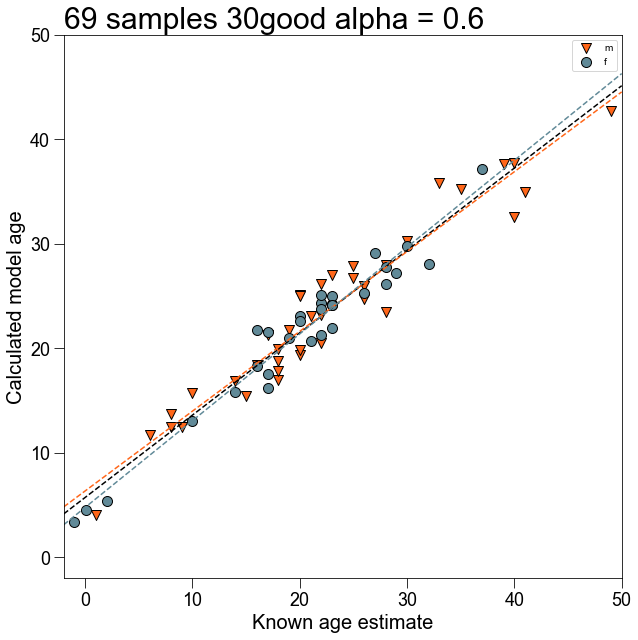

In [111]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.6

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a06_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_30good_model_cpgs.csv'
samp_69_30good_a06_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a06_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a06_clock = make_epigenetic_clock(samp_69_30good_a06_clock_cpgs_path, samp_69_30good_a06_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a06_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a06_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a06_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a06_clock", 0.6, len(samp_69_30good_a06_clock['cpgs'])-1,
                                                                    samp_69_30good_a06_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a06_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.6')
samp_69_30good_a06_clock_stats_df

The y intercept for this clock model equation is 205.346091305246 .
There are 29 cpgs in the current model
The mean absolute error is 2.219155285993478
The median absolute error is 1.8976412149839703
The mean absolute error for m is 2.567739125147147
The median absolute error for m is 2.071776728939618
The mean absolute error for f is 1.7918589670309168
The median absolute error for f is 1.5737019000960757
r-squared: 0.940554970793685
p-value: 8.571640564286161e-43
slope: 0.801680874941195
y-intercept for regression: 4.679933405286523
r-squared for m : 0.933341010197348
p-value for m : 9.212924739564713e-23
slope for m : 0.7783908737035836
y-intercept for regression for m : 5.2781579560665755
r-squared for f : 0.9539996990276227
p-value for f : 6.117590920819982e-21
slope for f : 0.8421518566673357
y-intercept for regression for f : 3.7652283891619582


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_30good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_30good_a07_clock    0.7          29    f  1.791859  1.573702   

   r-squared       p-value  regression_slope  y-intercept  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228

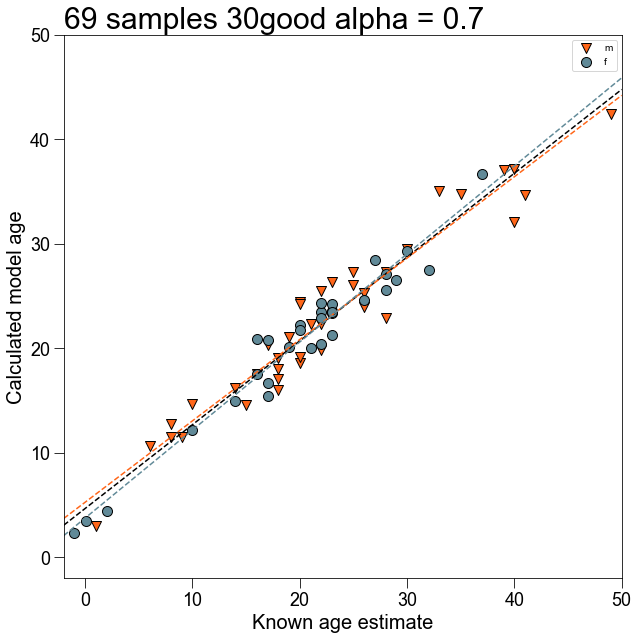

In [112]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.7

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a07_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_30good_model_cpgs.csv'
samp_69_30good_a07_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a07_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a07_clock = make_epigenetic_clock(samp_69_30good_a07_clock_cpgs_path, samp_69_30good_a07_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a07_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a07_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a07_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a07_clock", 0.7, len(samp_69_30good_a07_clock['cpgs'])-1,
                                                                    samp_69_30good_a07_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a07_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.7')
samp_69_30good_a07_clock_stats_df

The y intercept for this clock model equation is 192.06055266879503 .
There are 28 cpgs in the current model
The mean absolute error is 5.961813688239435
The median absolute error is 5.910300617752057
The mean absolute error for m is 5.989892225406047
The median absolute error for m is 6.167609082454767
The mean absolute error for f is 5.927394836228748
The median absolute error for f is 5.905668086592559
r-squared: 0.9283766076847814
p-value: 4.438891699234272e-40
slope: 0.694830525234254
y-intercept for regression: 12.174749860752
r-squared for m : 0.9261966118000939
p-value for m : 5.77948075515378e-22
slope for m : 0.6647802089833713
y-intercept for regression for m : 12.899324267938994
r-squared for f : 0.9371604129797249
p-value for f : 5.6824990968638185e-19
slope for f : 0.748736559055501
y-intercept for regression for f : 11.018316360655845


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_30good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_30good_a08_clock    0.8          28    f  5.927395  5.905668   

   r-squared       p-value  regression_slope  y-intercept  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316

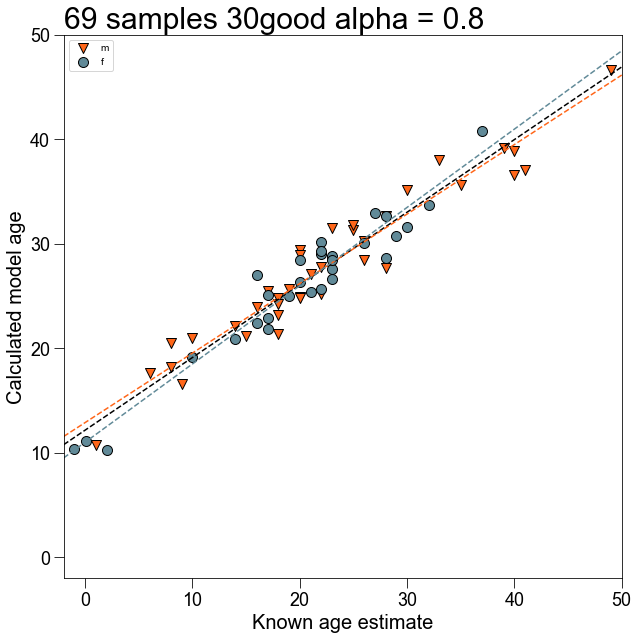

In [113]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.8

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a08_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_30good_model_cpgs.csv'
samp_69_30good_a08_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a08_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a08_clock = make_epigenetic_clock(samp_69_30good_a08_clock_cpgs_path, samp_69_30good_a08_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a08_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a08_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a08_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a08_clock", 0.8, len(samp_69_30good_a08_clock['cpgs'])-1,
                                                                    samp_69_30good_a08_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a08_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.8')
samp_69_30good_a08_clock_stats_df

The y intercept for this clock model equation is 199.526023437144 .
There are 27 cpgs in the current model
The mean absolute error is 6.336773289363945
The median absolute error is 6.411664213162773
The mean absolute error for m is 6.296480149226432
The median absolute error for m is 6.614041996719502
The mean absolute error for f is 6.386164880500256
The median absolute error for f is 6.263086056219716
r-squared: 0.9302180176225662
p-value: 1.8531883322733637e-40
slope: 0.694736461305528
y-intercept for regression: 12.627386799781467
r-squared for m : 0.9291916259821786
p-value for m : 2.7376439049196324e-22
slope for m : 0.665358248903317
y-intercept for regression for m : 13.330369204665647
r-squared for f : 0.9370655918334018
p-value for f : 5.8083782194431975e-19
slope for f : 0.7476290366397876
y-intercept for regression for f : 11.499526238130882


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_30good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_30good_a09_clock    0.9          27    f  6.386165  6.263086   

   r-squared       p-value  regression_slope  y-intercept  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526

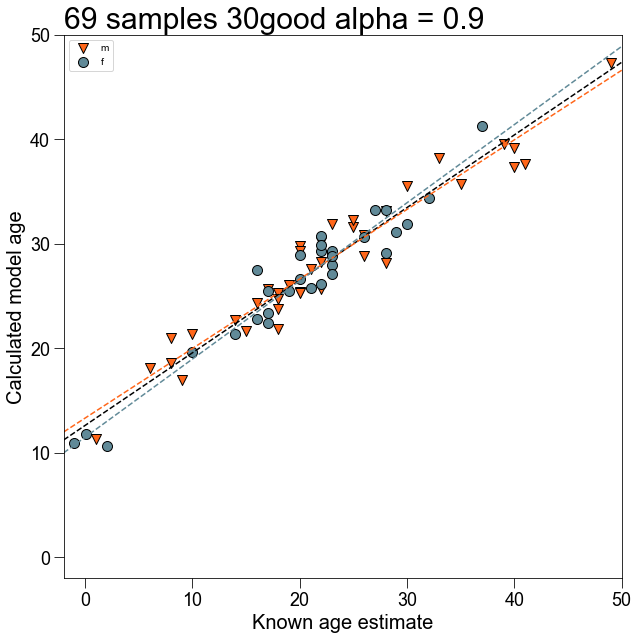

In [114]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 0.9

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a09_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_30good_model_cpgs.csv'
samp_69_30good_a09_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a09_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a09_clock = make_epigenetic_clock(samp_69_30good_a09_clock_cpgs_path, samp_69_30good_a09_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a09_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a09_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a09_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a09_clock", 0.9, len(samp_69_30good_a09_clock['cpgs'])-1,
                                                                    samp_69_30good_a09_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a09_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 0.9')
samp_69_30good_a09_clock_stats_df

The y intercept for this clock model equation is 194.72310742005502 .
There are 26 cpgs in the current model
The mean absolute error is 6.547818901705716
The median absolute error is 6.65312140942347
The mean absolute error for m is 6.480524672373766
The median absolute error for m is 6.824492542184698
The mean absolute error for f is 6.630308602177137
The median absolute error for f is 6.507781710047816
r-squared: 0.9297429367150251
p-value: 2.3267040898426055e-40
slope: 0.6914356260509881
y-intercept for regression: 12.933282961231994
r-squared for m : 0.9290117874204165
p-value for m : 2.8657993473318054e-22
slope for m : 0.662033373891777
y-intercept for regression for m : 13.6326207556703
r-squared for f : 0.9362366373247953
p-value for f : 7.024870620704266e-19
slope for f : 0.7445220635013987
y-intercept for regression for f : 11.806621244589124


clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a1_clock    1.0          26  all  6.547819  6.653121   
1  samp_69_30good_a1_clock    1.0          26    m  6.480525  6.824493   
2  samp_69_30good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.929743  2.326704e-40          0.691436    12.933283  
1   0.929012  2.865799e-22          0.662033    13.632621  
2   0.936237  7.024871e-19          0.744522    11.806621

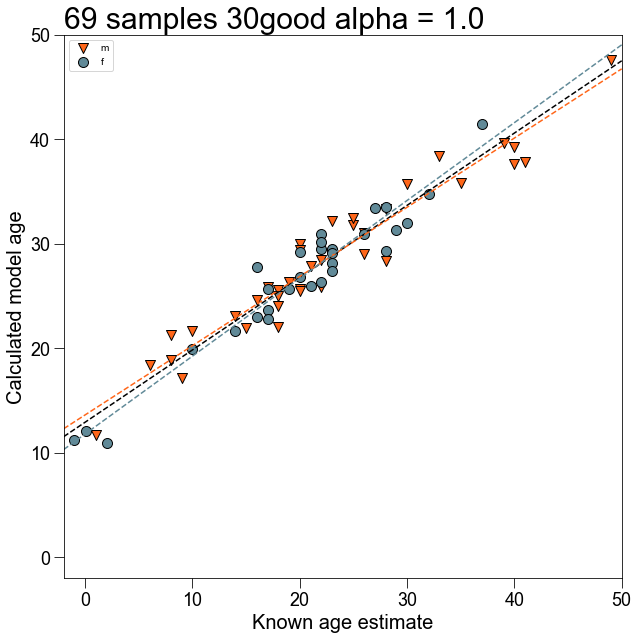

In [115]:
### Using probes filtered for pValue. If either all samples, or all - 30 samples had a bad pValue, the probe was removed. 
### alpha = 1.0

# Define paths to the cpg info and the coefficient info produced by glmnet()
samp_69_30good_a1_clock_cpgs_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_30good_model_cpgs.csv'
samp_69_30good_a1_clock_coefficients_path = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/temp/samp_69_a1_pValue_30good_model_coefficients.csv'

# This will build the epigenetic clock, meaning just makes a df of the clock components 
samp_69_30good_a1_clock = make_epigenetic_clock(samp_69_30good_a1_clock_cpgs_path, samp_69_30good_a1_clock_coefficients_path)

# Calculate the ages of the calibration samples using the clock model
samp_69_30good_a1_model_age_df = calculate_whale_ages(sesame_KBO_samp_69.columns, sesame_KBO_samp_69, 
                                               samp_69_30good_a1_clock, beluga_metadata_df)

# Calculate age error values (sex specific) and plot the regression of model ages vs. 'known' chronological ages 
samp_69_30good_a1_clock_stats_df = sex_specific_clock_plots_and_stats("samp_69_30good_a1_clock", 1.0, len(samp_69_30good_a1_clock['cpgs'])-1,
                                                                    samp_69_30good_a1_model_age_df,
                                                                    '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/plots/samp_69_30good_a1_sex_specific.eps', 
                                                                    '69 samples 30good alpha = 1.0')
samp_69_30good_a1_clock_stats_df

In [116]:

dfs_for_samp_69_30good = [samp_69_30good_a01_clock_stats_df, samp_69_30good_a02_clock_stats_df,
                                      samp_69_30good_a03_clock_stats_df, samp_69_30good_a04_clock_stats_df,
                                      samp_69_30good_a05_clock_stats_df, samp_69_30good_a06_clock_stats_df,
                                      samp_69_30good_a07_clock_stats_df, samp_69_30good_a08_clock_stats_df,
                                      samp_69_30good_a09_clock_stats_df, samp_69_30good_a1_clock_stats_df]

stats_samp_69_30good_clocks = pd.concat(dfs_for_samp_69_30good)
    
stats_samp_69_30good_clocks.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/clock_stats/stats_samp_69_30good_clocks.csv')

stats_samp_69_30good_clocks

clock_info  alpha  clock_size  sex       mae     medae  \
0  samp_69_30good_a01_clock    0.1         116  all  3.265907  3.053814   
1  samp_69_30good_a01_clock    0.1         116    m  3.562363  3.484875   
2  samp_69_30good_a01_clock    0.1         116    f  2.902508  2.947083   
0  samp_69_30good_a02_clock    0.2          67  all  3.612399  3.490510   
1  samp_69_30good_a02_clock    0.2          67    m  3.878176  4.046011   
2  samp_69_30good_a02_clock    0.2          67    f  3.286607  3.363634   
0  samp_69_30good_a03_clock    0.3          50  all  3.585137  3.555868   
1  samp_69_30good_a03_clock    0.3          50    m  3.849066  4.029379   
2  samp_69_30good_a03_clock    0.3          50    f  3.261610  3.421194   
0  samp_69_30good_a04_clock    0.4          40  all  3.208582  3.227524   
1  samp_69_30good_a04_clock    0.4          40    m  3.482674  3.651746   
2  samp_69_30good_a04_clock    0.4          40    f  2.872599  3.020560   
0  samp_69_30good_a05_clock    0.5          35  all  2.835831  2.795536   
1  samp_69_30good_a05_clock    0.5          35    m  3.140798  3.356458   
2  samp_69_30good_a05_clock    0.5          35    f  2.462001  2.649906   
0  samp_69_30good_a06_clock    0.6          31  all  2.464744  2.119077   
1  samp_69_30good_a06_clock    0.6          31    m  2.779631  2.606785   
2  samp_69_30good_a06_clock    0.6          31    f  2.078752  1.865617   
0  samp_69_30good_a07_clock    0.7          29  all  2.219155  1.897641   
1  samp_69_30good_a07_clock    0.7          29    m  2.567739  2.071777   
2  samp_69_30good_a07_clock    0.7          29    f  1.791859  1.573702   
0  samp_69_30good_a08_clock    0.8          28  all  5.961814  5.910301   
1  samp_69_30good_a08_clock    0.8          28    m  5.989892  6.167609   
2  samp_69_30good_a08_clock    0.8          28    f  5.927395  5.905668   
0  samp_69_30good_a09_clock    0.9          27  all  6.336773  6.411664   
1  samp_69_30good_a09_clock    0.9          27    m  6.296480  6.614042   
2  samp_69_30good_a09_clock    0.9          27    f  6.386165  6.263086   
0   samp_69_30good_a1_clock    1.0          26  all  6.547819  6.653121   
1   samp_69_30good_a1_clock    1.0          26    m  6.480525  6.824493   
2   samp_69_30good_a1_clock    1.0          26    f  6.630309  6.507782   

   r-squared       p-value  regression_slope  y-intercept  
0   0.925007  2.074817e-39          0.742635     7.813861  
1   0.914704  7.866622e-21          0.718713     8.377615  
2   0.943734  1.140938e-19          0.786015     6.899818  
0   0.930760  1.426595e-40          0.752457     8.179711  
1   0.921076  1.938391e-21          0.727460     8.797851  
2   0.948736  2.951208e-20          0.796748     7.209997  
0   0.932881  5.026264e-41          0.759249     8.039476  
1   0.923869  1.011821e-21          0.733827     8.680991  
2   0.949862  2.137322e-20          0.803834     7.046812  
0   0.936893  6.363423e-42          0.774400     7.289552  
1   0.928746  3.065439e-22          0.749671     7.918555  
2   0.952294  1.038192e-20          0.817594     6.321426  
0   0.937750  4.021863e-42          0.780878     6.620639  
1   0.930198  2.114993e-22          0.756437     7.246598  
2   0.952082  1.107044e-20          0.823416     5.661637  
0   0.938033  3.453164e-42          0.787723     5.735381  
1   0.930617  1.897089e-22          0.763435     6.357741  
2   0.952057  1.115464e-20          0.829982     4.782229  
0   0.940555  8.571641e-43          0.801681     4.679933  
1   0.933341  9.212925e-23          0.778391     5.278158  
2   0.954000  6.117591e-21          0.842152     3.765228  
0   0.928377  4.438892e-40          0.694831    12.174750  
1   0.926197  5.779481e-22          0.664780    12.899324  
2   0.937160  5.682499e-19          0.748737    11.018316  
0   0.930218  1.853188e-40          0.694736    12.627387  
1   0.929192  2.737644e-22          0.665358    13.330369  
2   0.937066  5.808378e-19          0.747629    11.499526  
0   0.92974

# Clock overlap tests

In [118]:
test = mapped_avg_a06_clock['cpgs']
test_2 = mapped_avg_a07_clock['cpgs']
test.isin(mapped_avg_a01_clock['cpgs'])
test_2.isin(mapped_avg_a01_clock['cpgs'])


0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22    False
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36    False
37     True
38     True
39     True
40     True
41    False
42     True
43    False
44     True
45    False
46     True
Name: cpgs, dtype: bool

In [129]:
test = all_second_a05_clock['cpgs']
old_clock = ['cg00952468', 'cg01208948', 'cg01814115', 'cg02044725', 'cg02534193', 'cg02714609', 'cg02830912',
             'cg03262977', 'cg03653137', 'cg03667077', 'cg04010581', 'cg04051518', 'cg04226139', 'cg06139548',
             'cg07493173', 'cg08228814', 'cg09026530', 'cg09474736', 'cg09622321', 'cg10620475', 'cg12311671',
             'cg12584622', 'cg12600648', 'cg13060540', 'cg14671961', 'cg15700165', 'cg15986005', 'cg17185827', 
             'cg17856858', 'cg18629679', 'cg18814344', 'cg19570901', 'cg19591642', 'cg20920370', 'cg21419180',
             'cg21420547', 'cg21511816', 'cg22069272', 'cg22416332', 'cg23753616', 'cg23795066', 'cg24805210', 
             'cg25140691', 'cg25579908', 'cg26313355', 'cg26899365']
all_second_a05_clock['cpgs'].isin(old_clock)

0     False
1     False
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14     True
15     True
16    False
17     True
18     True
19     True
20    False
21     True
22     True
23    False
24    False
25    False
26     True
27     True
28     True
29     True
30    False
31     True
32     True
33    False
34    False
35     True
36     True
37     True
38     True
39     True
40    False
41     True
42     True
43     True
44    False
45     True
46     True
47     True
48     True
49     True
50     True
51    False
52     True
53     True
54    False
Name: cpgs, dtype: bool

# Calibration Sample Age Histogram

22.0


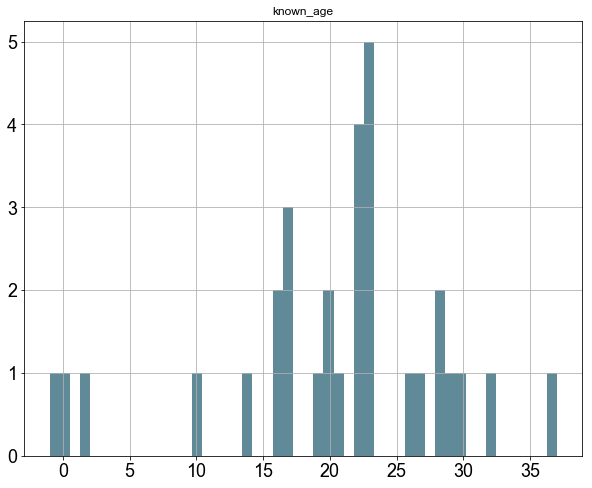

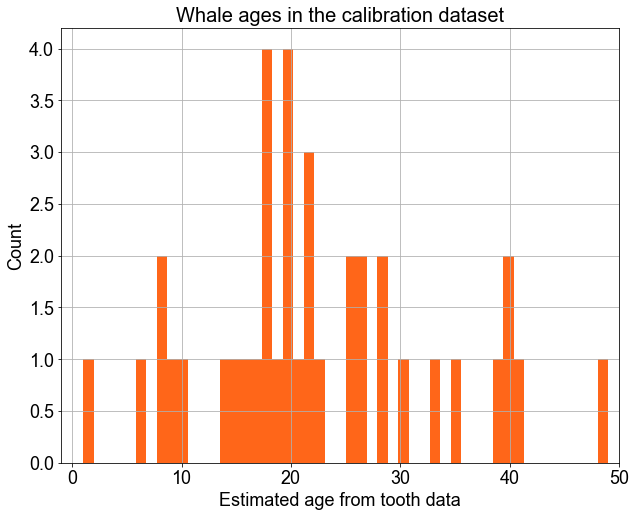

In [34]:
color_dic = {'f': '#618A98', 'm':'#FF6619'}

groups = all_KBO_samp_69_a05_model_age_df.groupby('sex')

    
for key, group in groups: 
    group.hist(column='known_age', figsize=(10,8), color = color_dic[key], bins= 50, xlabelsize=18, 
                                 ylabelsize = 18)

plt.title('Whale ages in the calibration dataset', fontsize = 20)
plt.xlabel('Estimated age from tooth data', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.xlim(-1, 50)

#plt.savefig('/Users/elliebors/Desktop/Beluga/manuscripts/beluga_array_ms/calibration_data_publication.pdf')

print(np.median(all_KBO_samp_69_a05_model_age_df['known_age']))

In [61]:
x = all_KBO_samp_69_a05_model_age_df['known_age'][all_KBO_samp_69_a05_model_age_df['sex']=='m']
y =  all_KBO_samp_69_a05_model_age_df['known_age'][all_KBO_samp_69_a05_model_age_df['sex']=='f']


38
31


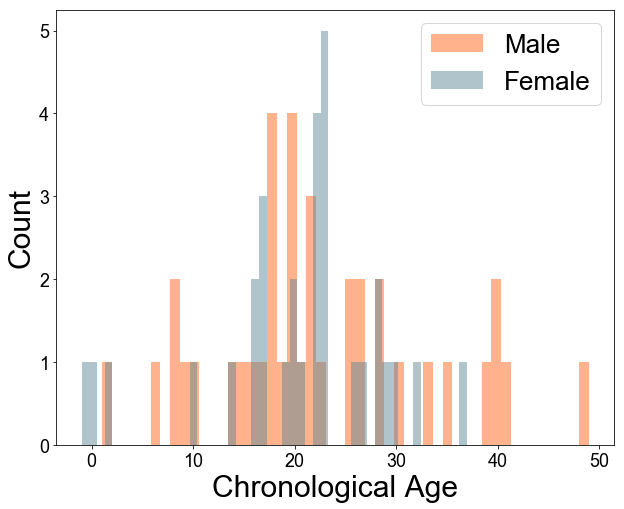

22.0
20.5
22.0


In [135]:


x = all_KBO_samp_69_a05_model_age_df['known_age'][all_KBO_samp_69_a05_model_age_df['sex']=='m']
y =  all_KBO_samp_69_a05_model_age_df['known_age'][all_KBO_samp_69_a05_model_age_df['sex']=='f']

color_dic = {'f': '#618A98', 'm':'#FF6619'}

bins = 50
plt.figure(figsize=(10,8))

#plt.hist([x, y], bins, label=['male', 'female'])
plt.hist(x, bins, alpha=0.5, label='Male', color ='#FF6619')
plt.hist(y, bins, alpha=0.5, label='Female', color = '#618A98')

print(len(x))
print(len(y))

plt.legend(loc='upper right', fontsize = 26)
plt.title('', fontsize = 36)
plt.xlabel('Chronological Age', fontsize = 30)
plt.ylabel('Count', fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('/Users/elliebors/Desktop/Beluga/manuscripts/beluga_array_ms/by_sex_histogram_calibration_ages.pdf')

plt.show()
print(np.median(all_KBO_samp_69_a05_model_age_df['known_age']))
print (np.median(x))
print (np.median(y))

# Clock probe mapping information 



Assuming the input data for the glmnet() analysis includes all of the array sites and not just the sites mapped to the beluga genome, the next section is needed to ascertain if the clock CpGs are mapped to the beluga genome and if so, what they are. 

In [70]:
### FUNCTION ###
### get_cpg_coordinates ###

#Find probe locations 

#You will need to have defined the following mapping dataframes: 

def get_cpg_coordinates(cpg_list):
    coordinate_output_list = []
    unmapped_cpgs_list = []
    for cpg in cpg_list:
        coordinate_output_list.append(unique_mapping_df.loc[cpg]['scaff_coord'])
        if unique_mapping_df.loc[cpg]['scaff_coord']==':':
            unmapped_cpgs_list.append(cpg)
    
    print('There are', len(unmapped_cpgs_list), 'unmapped CpGs in this clock, and they are: \n', unmapped_cpgs_list)
    print(ambiguous_mapping_df[ambiguous_mapping_df.index.isin(unmapped_cpgs_list)])
    return coordinate_output_list



In [71]:
 if unique_mapping_df.loc[cpg]['scaff_coord']==':':

            unmapped_cpgs_list.append(cpg)

NameError: name 'cpg' is not defined

In [72]:
unmapped_cpgs = []
coordinates_all_second_a05_cpgs = get_cpg_coordinates(all_second_a05_clock['cpgs'][1:])#, unmapped_cpgs)

coordinate_df = pd.DataFrame(columns=['cpgs', 'beluga_coordinates'])#, 'in_first_a05_clock', 'in_avg_a05_clock'])


coordinate_df.cpgs = all_second_a05_clock['cpgs'][1:]
coordinate_df.beluga_coordinates = coordinates_all_second_a05_cpgs
#coordinate_df.in_first_a05_clock = coordinate_df['cpgs'].isin(all_first_a05_clock['cpgs'])
#coordinate_df.in_avg_a05_clock = coordinate_df['cpgs'].isin(all_avg_a05_clock['cpgs'])

coordinate_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/n70_coordinates_second_a05.csv')
#coordinate_df

There are 21 unmapped CpGs in this clock, and they are: 
 ['cg00746259', 'cg01814115', 'cg02044725', 'cg04010581', 'cg06139548', 'cg08228814', 'cg09474736', 'cg10996763', 'cg11472764', 'cg12053353', 'cg12600648', 'cg15099808', 'cg15700165', 'cg16114007', 'cg17856858', 'cg18814344', 'cg20920370', 'cg21444333', 'cg23753616', 'cg23795066', 'cg24805210']
Empty DataFrame
Columns: [scaffold_coord_1, scaffold_coord_2, scaffold_coord_3, scaffold_coord_4, scaffold_coord_5]
Index: []


In [73]:
unmapped_cpgs = []
coordinates_all_68limited_a05_cpgs = get_cpg_coordinates(all_68limited_a05_clock['cpgs'][1:])#, unmapped_cpgs)

coordinate_df = pd.DataFrame(columns=['cpgs', 'beluga_coordinates'])#, 'in_first_a05_clock', 'in_avg_a05_clock'])


coordinate_df.cpgs = all_68limited_a05_clock['cpgs'][1:]
coordinate_df.beluga_coordinates = coordinates_all_68limited_a05_cpgs

#coordinate_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/all_68limited_a05.csv')
#coordinate_df

NameError: name 'all_68limited_a05_clock' is not defined

In [74]:
unmapped_cpgs = []
coordinates_all_KBO_samp_69_a05_cpgs = get_cpg_coordinates(all_KBO_samp_69_a05_clock['cpgs'][1:])#, unmapped_cpgs)

coordinate_df = pd.DataFrame(columns=['cpgs', 'beluga_coordinates'])#, 'in_first_a05_clock', 'in_avg_a05_clock'])


coordinate_df.cpgs = all_KBO_samp_69_a05_clock['cpgs'][1:]
coordinate_df.beluga_coordinates = coordinates_all_KBO_samp_69_a05_cpgs

#coordinate_df.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/all_KBO_samp_69_a05.csv')
#coordinate_df

There are 29 unmapped CpGs in this clock, and they are: 
 ['cg01814115', 'cg01878181', 'cg02044725', 'cg02673624', 'cg03932026', 'cg05106770', 'cg05551621', 'cg05859116', 'cg08228814', 'cg08826760', 'cg09474736', 'cg10516886', 'cg10628126', 'cg10996763', 'cg11620885', 'cg11634487', 'cg15700165', 'cg15992086', 'cg16203357', 'cg17856858', 'cg18959846', 'cg19426872', 'cg20550118', 'cg20920370', 'cg21444333', 'cg23753616', 'cg24472748', 'cg25658543', 'cg26286303']
                  scaffold_coord_1        scaffold_coord_2 scaffold_coord_3  \
probeID                                                                       
cg25658543  NW_019160945.1:6949307  NW_019160894.1:7034401              NaN   

           scaffold_coord_4 scaffold_coord_5  
probeID                                       
cg25658543              NaN              NaN  


# Clock probe individual correlations

In [75]:
### FUNCTION ### 

#A function that has inputs of:
#(1) a list of the CpGs to consider, 
#(2) the dataframe with beta values from normalized data with a row 'age' for correlations** 
#    This part is important and may need to be accomplished by hand in excel.... !


def make_correlation_list(cpg_list, beta_value_df):
    #make ane empty list
    coefficient_list = []
    #Loop through the CpGs and calcuate the correlations; append to your correlation list
    for i in (cpg_list):
        correlation = np.corrcoef(beta_value_df.loc['age'], beta_value_df.loc[i])
        coefficient_list.append(correlation[0,1])
    return coefficient_list

###


In [76]:
all_reps_second_sesame_age_included_df = pd.read_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/age_included_sesame_data_reps_second.csv', sep=',', index_col=0)

#reps_second_a05_CpG_correlations

In [77]:
reps_second_a05_CpG_correlations = make_correlation_list(all_second_a05_clock.cpgs[1:], all_reps_second_sesame_age_included_df)

print(len(reps_second_a05_CpG_correlations))
#reps_second_a05_CpG_correlations



54


In [78]:
reps_second_a09_CpG_correlations = make_correlation_list(all_second_a09_clock.cpgs[1:], all_reps_second_sesame_age_included_df)

print(len(reps_second_a09_CpG_correlations))
#reps_second_a09_CpG_correlations

NameError: name 'all_second_a09_clock' is not defined

# Leave one out plotting

LOOCV was run in R by looping cv.glmnet() through n-1 samples. Here, I plot the LOOCV run with the same parameters as the chosen clock.


r-squared for m : 0.43078523933673185
p-value for m : 7.666355786715496e-06
slope for m : -0.3601523892971793
y-intercept for regression for m : 7.501417906440333
r-squared for f : 0.44589497926455907
p-value for f : 4.059266368371157e-05
slope for f : -0.24678455409986894
y-intercept for regression for f : 5.457757825722166
r-squared: 0.42693865061020797
p-value: 1.158120455432414e-09
slope: -0.322328180720622
y-intercept for regression: 6.804967356993349
21.111921836246626


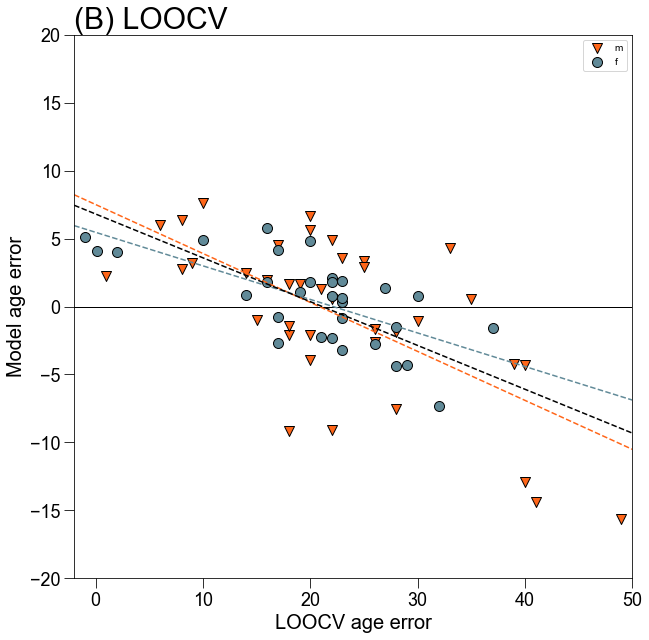

In [81]:
sex_specific_age_error(LOOCV_KBO_samp_69_df, 
                       '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_age_error_KBO_samp_69_sex_specific_fig.eps', 
                       '(B) LOOCV', 'LOOCV age error')

r-squared for m : 0.7292027780156961
p-value for m : 9.392778602557356e-12
slope for m : 0.6231441920585594
y-intercept for regression for m : 8.043719765152229
r-squared for f : 0.8784861829459812
p-value for f : 8.323086065321805e-15
slope for f : 0.773631596864459
y-intercept for regression for f : 4.934712336534943
r-squared: 0.7831527413513599
p-value: 6.306518184429619e-24
slope: 0.6755510047758844
y-intercept for regression: 6.894145834630084
The mean absolute error is 3.500822304873733
The median absolute error is 2.4564065117344995
The mean absolute error for m is 4.367700893249629
The median absolute error for m is 3.6272682720619045
The mean absolute error for f is 2.438196938477473
The median absolute error for f is 1.729777795507399


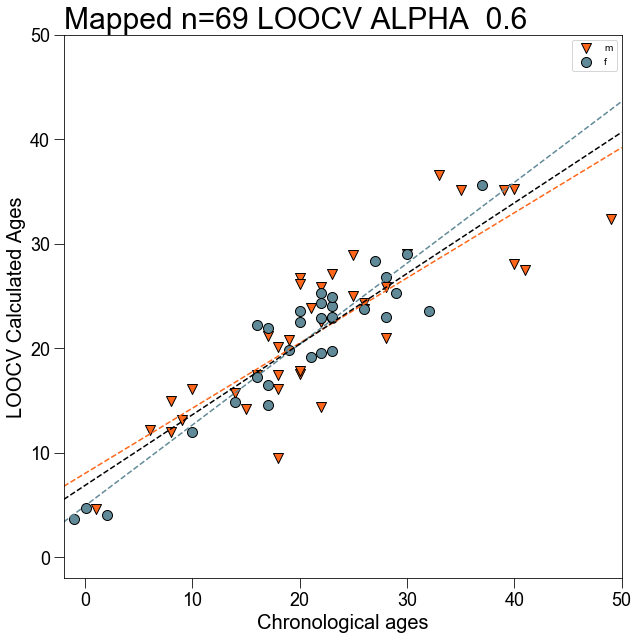

In [164]:
LOOCV_mapped_KBO_samp_69_a06_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_mapped_KBO_samp_69_a06_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_mapped_KBO_samp_69_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_KBO_samp_69_a06_sex_specific_fig.eps',
                                      "Mapped n=69 LOOCV ALPHA  0.6", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_mapped_KBO_samp_69_a06_df)
#LOOCV_KBO_samp_69_df"

r-squared for m : 0.7292027780156961
p-value for m : 9.392778602557356e-12
slope for m : 0.6231441920585594
y-intercept for regression for m : 8.043719765152229
r-squared for f : 0.8784861829459812
p-value for f : 8.323086065321805e-15
slope for f : 0.773631596864459
y-intercept for regression for f : 4.934712336534943
r-squared: 0.7831527413513599
p-value: 6.306518184429619e-24
slope: 0.6755510047758844
y-intercept for regression: 6.894145834630084
The mean absolute error is 3.5575779295728824
The median absolute error is 2.4220495170623018
The mean absolute error for m is 4.4321741656710545
The median absolute error for m is 3.7148270822586014
The mean absolute error for f is 2.4854922208073793
The median absolute error for f is 2.1566861327107


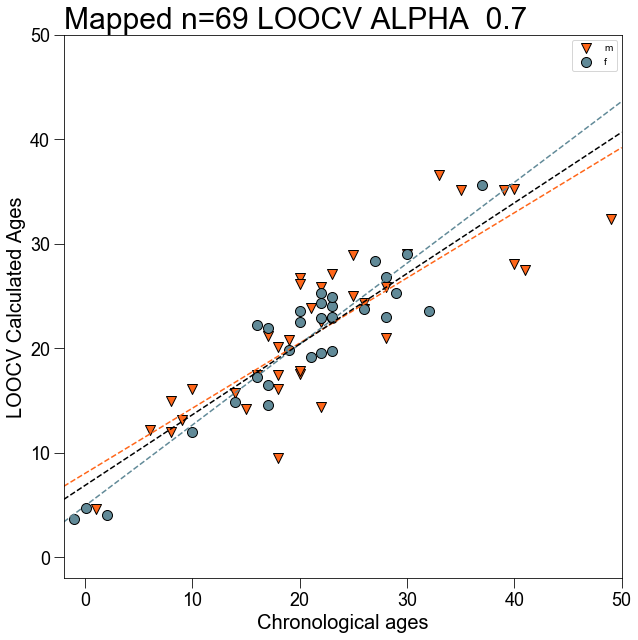

In [165]:
LOOCV_mapped_KBO_samp_69_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_mapped_KBO_samp_69_a07_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_mapped_KBO_samp_69_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_KBO_samp_69_a07_sex_specific_fig.eps',
                                      "Mapped n=69 LOOCV ALPHA  0.7", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_mapped_KBO_samp_69_a07_df)


r-squared for m : 0.7000358236090137
p-value for m : 6.035158524397537e-11
slope for m : 0.6211608637489819
y-intercept for regression for m : 8.036399088179355
r-squared for f : 0.8752638644612545
p-value for f : 1.2185429881687412e-14
slope for f : 0.7370013481025507
y-intercept for regression for f : 5.667877423580057
r-squared: 0.7628158094916035
p-value: 1.2867921854551837e-22
slope: 0.6613649868225191
y-intercept for regression: 7.165522599844614
The mean absolute error is 3.634855557014375
The median absolute error is 2.826358190123001
The mean absolute error for m is 4.4069256068830756
The median absolute error for m is 3.555959229722699
The mean absolute error for f is 2.6884471087882233
The median absolute error for f is 2.4458997887228975


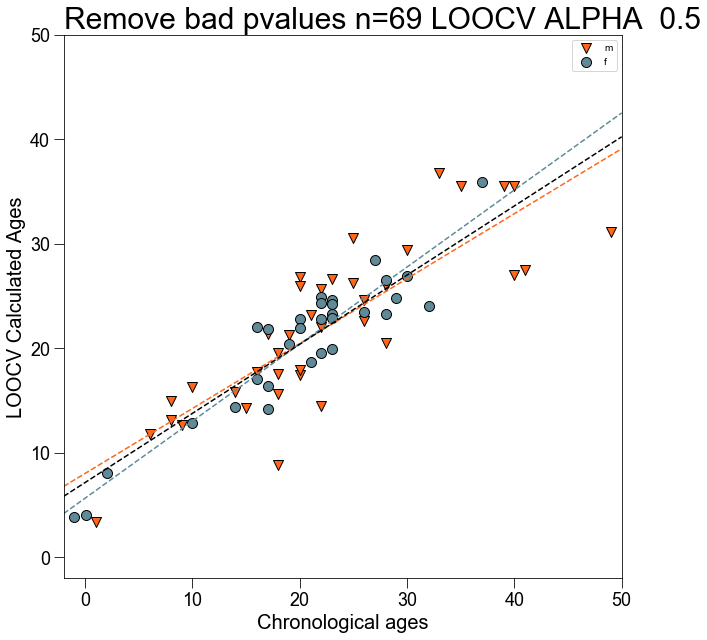

In [32]:
LOOCV_remove_bad_pValues_samp_69_a05_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_69_a05_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_remove_bad_pValues_samp_69_a05_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_pvalues_removed_samp_69_a05_sex_specific_fig.eps',
                                      "Remove bad pvalues n=69 LOOCV ALPHA  0.5", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_remove_bad_pValues_samp_69_a05_df)


r-squared for m : 0.7030182320195887
p-value for m : 5.0317438486421796e-11
slope for m : 0.6344361007394442
y-intercept for regression for m : 7.90527750491381
r-squared for f : 0.8726552027983623
p-value for f : 1.6473334767782653e-14
slope for f : 0.7342612133151442
y-intercept for regression for f : 5.668503319480745
r-squared: 0.7640114110500411
p-value: 1.085568858639148e-22
slope: 0.6701675822769841
y-intercept for regression: 7.043617368678079
The mean absolute error is 3.667282193250418
The median absolute error is 2.698724731787401
The mean absolute error for m is 4.479826203693742
The median absolute error for m is 3.6088088928235003
The mean absolute error for f is 2.6712605030295706
The median absolute error for f is 2.350099203889499


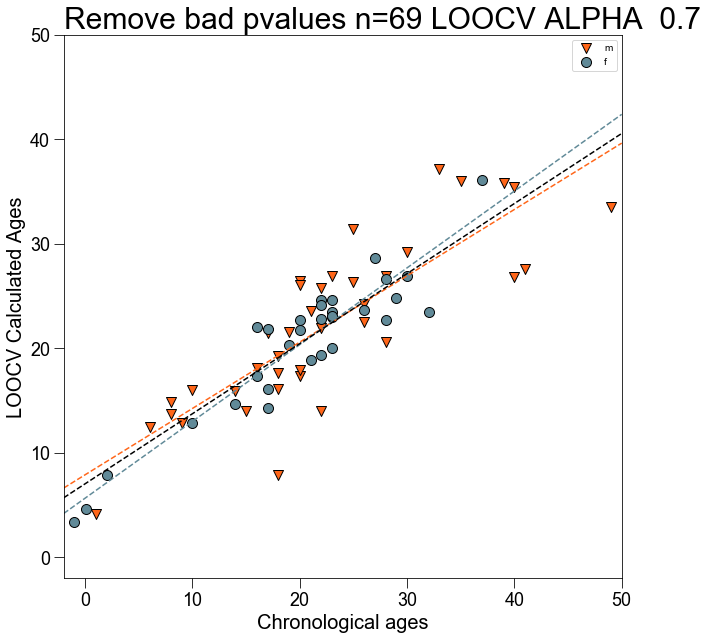

In [34]:
LOOCV_remove_bad_pValues_samp_69_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_bad_removed_samp_69_a07_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_remove_bad_pValues_samp_69_a07_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_bad_pvalues_removed_samp_69_a07_sex_specific_fig.eps',
                                      "Remove bad pvalues n=69 LOOCV ALPHA  0.7", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_remove_bad_pValues_samp_69_a07_df)


r-squared: 0.7660549329712132
p-value: 8.101503567342472e-23
slope: 0.6636157779256102
y-intercept for regression: 7.158779768329396
r-squared for m : 0.7061811742214323
p-value for m : 4.1410453740571783e-11
slope for m : 0.625195401118599
y-intercept for regression for m : 7.981856318771758
r-squared for f : 0.8731516798763425
p-value for f : 1.5562089440962957e-14
slope for f : 0.7362232821269888
y-intercept for regression for f : 5.732187445112098
The mean absolute error is 3.671500297187129
The median absolute error is 2.8684984093415995
The mean absolute error for m is 4.424778422906017
The median absolute error for m is 3.5631419026507993
The mean absolute error for f is 2.7481271108220393
The median absolute error for f is 2.3997605554466013


alpha  sex       mae     medae
0    0.7  all  3.671500  2.868498
1    0.7    m  4.424778  3.563142
2    0.7    f  2.748127  2.399761

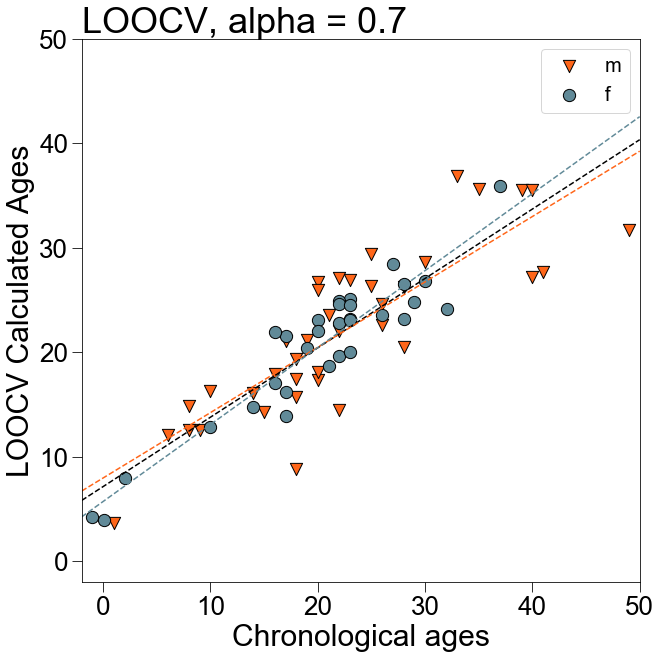

In [149]:
LOOCV_pValue_10good_samp_69_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_10good_samp_69_a05_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_pValue_10good_samp_69_a07_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_10good_samp_69_a07_sex_specific_fig.eps',
                                      "LOOCV, alpha = 0.7", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_pValue_10good_samp_69_a07_df, 0.7)


r-squared for m : 0.7121359240890692
p-value for m : 2.8533618575329886e-11
slope for m : 0.6264901038657436
y-intercept for regression for m : 8.00888285488993
r-squared for f : 0.8769194624234854
p-value for f : 1.003039508273497e-14
slope for f : 0.7360607738103967
y-intercept for regression for f : 5.69471791963376
r-squared: 0.7715465970469171
p-value: 3.643150071501171e-23
slope: 0.6649278262649926
y-intercept for regression: 7.143193395773487
The mean absolute error is 3.660495768308427
The median absolute error is 2.7020715388675995
The mean absolute error for m is 4.442233431653072
The median absolute error for m is 3.717777302689049
The mean absolute error for f is 2.7022366971117635
The median absolute error for f is 2.4553369711536988


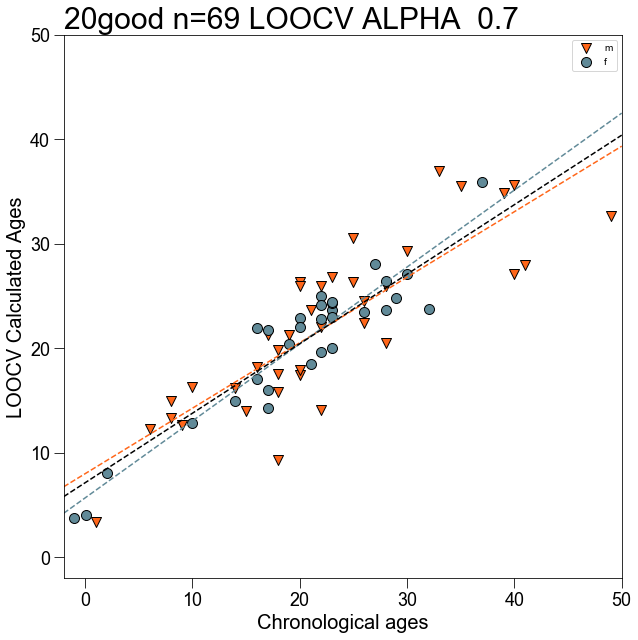

In [66]:
LOOCV_pValue_20good_samp_69_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_20good_samp_69_a05_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_pValue_20good_samp_69_a07_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_20good_samp_69_a07_sex_specific_fig.eps',
                                      "20good n=69 LOOCV ALPHA  0.7", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_pValue_20good_samp_69_a07_df)


r-squared for m : 0.7262414245439404
p-value for m : 1.1445640469533079e-11
slope for m : 0.636037397409406
y-intercept for regression for m : 7.834261658733565
r-squared for f : 0.8765804997337934
p-value for f : 1.0440342059189279e-14
slope for f : 0.7368894141881407
y-intercept for regression for f : 5.670268123183739
r-squared: 0.7807142162022823
p-value: 9.186209593199585e-24
slope: 0.6716050386041182
y-intercept for regression: 7.018157625208561
The mean absolute error is 3.6059420881515987
The median absolute error is 2.8292553967797005
The mean absolute error for m is 4.366817573443424
The median absolute error for m is 3.7318549339509
The mean absolute error for f is 2.673256009406777
The median absolute error for f is 2.522176966574399


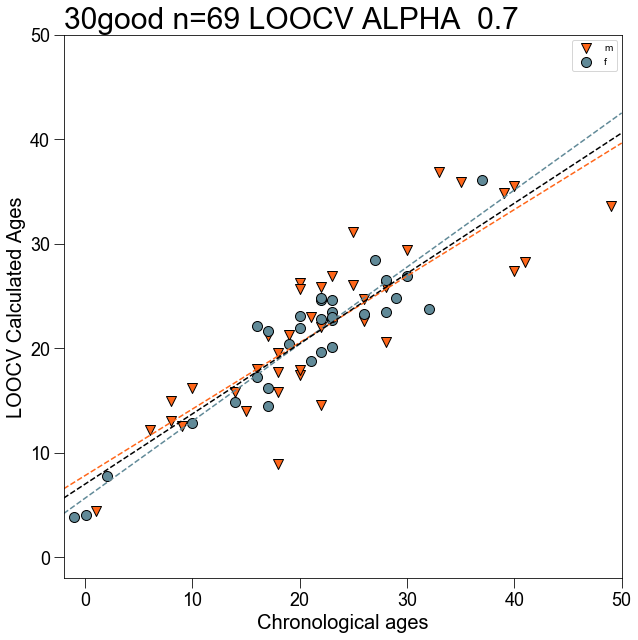

In [77]:
LOOCV_pValue_30good_samp_69_a07_df = make_LOOCV_age_df('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_pValue_30good_samp_69_a05_LOOCV.csv',
                                       sesame_KBO_samp_69_sample_names, beluga_metadata_df)

sex_specific_plot_model_vs_known_ages(LOOCV_pValue_30good_samp_69_a07_df, 
                                      '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/LOOCV_pValue_30good_samp_69_a07_sex_specific_fig.eps',
                                      "30good n=69 LOOCV ALPHA  0.7", "Chronological ages", "LOOCV Calculated Ages")

calculate_mae_medae(LOOCV_pValue_30good_samp_69_a07_df)


r-squared: 0.75221155559696
p-value: 1.1348747621283723e-21
slope: 0.6644908311506131
y-intercept for regression: 7.114651208004469
The mean absolute error is 3.850375792907992
The median absolute error is 3.0674873845491017


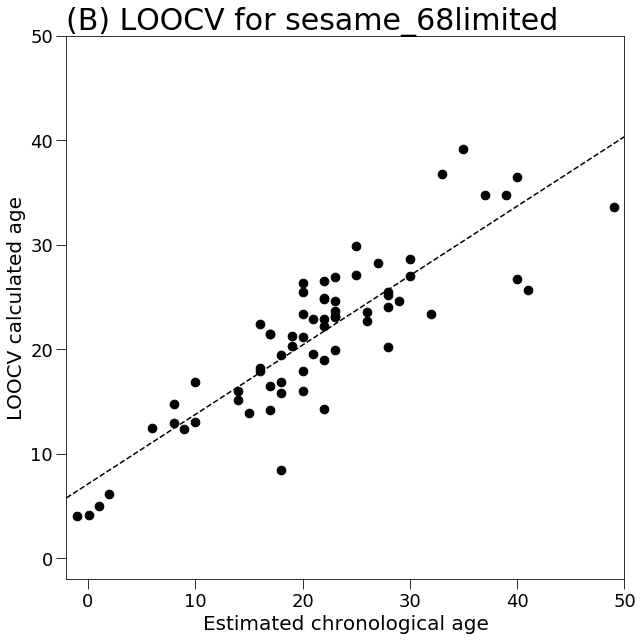

In [126]:
LOOCV_file = '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV/predicted_ages_all_68limited_a05_LOOCV.csv'
LOOCV_prediction_68limited_df = pd.read_csv(LOOCV_file, header = 0, index_col=0)

plot_model_vs_known_ages(LOOCV_prediction_68limited_df['x'], 
                         sesame_68limited_age_vector, 
                         '/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/LOOCV_sesame_68limited_regression.eps',
                        '(B) LOOCV for sesame_68limited', 'Estimated chronological age','LOOCV calculated age')

calculate_mae_medae(sesame_68limited_age_vector, LOOCV_prediction_68limited_df['x'])

# Estimate Ages of Biopsy Samples Using the Beluga Clock!

In [118]:
### FUNCTION ### 
### calcualte_biopsy_ages ###

# This function takes the following arguments: 
# (1) a list of whale sample names (whale_id_list) that correpond with the columns in a beta data file. 
# (2) the dataframe containing raw data you'd like to use 
# (3) the dataframe containing the current clock values - must have the columns 'cpgs' and 'coefficients'
# 
# NOTE that 'cpgs' and 'coefficients' have to have been defined outside of the function from R glmnet() output. 
# One way of defining cpgs and coefficients is to use the function above: make_epigenetic_clock
# This returns a dataframe that has two columns: sampleID and model_ages_df

def calculate_biopsy_ages(whale_id_list, normalized_beta_dataframe, current_clock_df): 
    # Calculate how many CpG terms there are in the clock/model 
    cpgs = current_clock_df['cpgs']
    coefficients = current_clock_df['coefficients']
    print ("There are", len(cpgs)-1, "cpgs in the current model")
    # This loops through the *index* of the cpgs to capture each term in the equation. 
    # NOTE: It starts at 1 because the 0 index item is the y-intercept!
    numbers = [i for i in range(1,len(cpgs)-1)]
    model_ages = []
    yIntercept = coefficients[0]
    # The following loop takes each whale and takes the column of beta values for that whale out of your dataframe
    for whale_id in whale_id_list:     
        beta_values_dleu_whale = normalized_beta_dataframe[whale_id]
        # Note that 'calculated_age' is a number that evolves throughout this code as each term of the equation is filled.
        # It starts here as the yIntercept and with the loop below, each term of the equation is added to the value. 
        # This process goes until the final output is the actual calculated age. 
        calculated_age = yIntercept
        
        for i in numbers: 
            #print (beta_values_dleu_whale[cpgs[i]] * coefficients[i])
            calculated_age = calculated_age + (beta_values_dleu_whale[current_clock_df.cpgs[i]] * current_clock_df.coefficients[i])
        
        # You can un-comment the following line to see the numbers as they are calcuated. 
        # print(whale_id, calculated_age)
        model_ages.append(calculated_age)
    model_ages_df = pd.DataFrame(columns=['sampleID', 'model_age'])
    model_ages_df['sampleID'] = whale_id_list
    model_ages_df['model_age'] = model_ages

    #Output of this function is a dataframe with whale sampleID and calculated model age
    return model_ages_df

###

In [119]:
biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)
#len(biopsy_df)

biopsy_ages_n69_10good_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, samp_69_10good_a07_clock)

biopsy_ages_n69_10good_clock




There are 29 cpgs in the current model


sampleID  model_age
0  MML_RA170902-B02  13.162406
1  MML_RA170903-B02  16.544919

In [121]:
#Calculate biopsy ages using the new clock = KBO sample 69
biopsy_plate_sesame_beta_data_file = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_array_data/NormalizedData/sesame_normalized_biopsy_plate_LabIDs.csv'
new_biopsy_sesame_df = pd.read_csv(biopsy_plate_sesame_beta_data_file, sep = ',', index_col=0)
#new_biopsy_sesame_df

biopsy_plate_ages_n69_10good_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, samp_69_10good_a07_clock)
biopsy_plate_ages_n69_10good_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/biopsy_plate_ages_n69_10good_clock.csv')

biopsy_plate_ages_n69_10good_clock


There are 29 cpgs in the current model


sampleID  model_age
0        Dleu17CI02  17.361081
1        Dleu17CI04  17.875762
2        Dleu17CI05  17.811257
3        Dleu17CI06  16.533411
4        Dleu17CI07  23.063695
5        Dleu17CI08  27.901869
6        Dleu17CI09  11.321068
7        Dleu17CI10  23.106042
8        Dleu17CI11  20.925821
9        Dleu17CI12  23.309801
10       Dleu17CI13  14.971859
11       Dleu16CI01  13.750920
12       Dleu16CI02  19.763170
13       Dleu16CI03  15.686448
14       Dleu16CI04  22.125643
15       Dleu16CI05  21.923001
16       Dleu18CI01  14.652619
17       Dleu18CI02  15.633764
18       Dleu18CI03  14.760473
19       Dleu18CI04  25.908763
20       Dleu18CI05  21.159451
21       Dleu18CI06  19.859542
22       Dleu18CI07  20.398342
23       Dleu18CI08  19.681998
24       Dleu18CI09  20.679533
25       Dleu18CI10  27.687531
26       Dleu18CI11  18.780752
27       Dleu18CI12  15.765807
28       Dleu18CI13   8.290335
29       Dleu18CI14  17.327826
30       Dleu18CI15  15.328027
31       Dleu18CI16  13.158211
32       Dleu18CI17  23.347672
33       Dleu18CI18  26.456168
34       Dleu18CI19  21.492755
35       Dleu18CI20  18.949305
36       Dleu18CI21  14.689247
37    Dleu_4196_KBO  24.345075
38    Dleu_9799_KBO  28.425348
39   Dleu_17861_KBO  20.758398
40   Dleu_28926_KBO  16.554989
41   Dleu_34579_KBO  21.107021
42  Dleu_35278_KBO   36.772114
43   Dleu_35281_KBO  25.333658
44   Dleu_79633_KBO  35.204015
45  Dleu_143907_KBO  24.318537
46       Chem18NZ02  19.871739
47       Chem18NZ04   3.025586

There are 29 cpgs in the current model


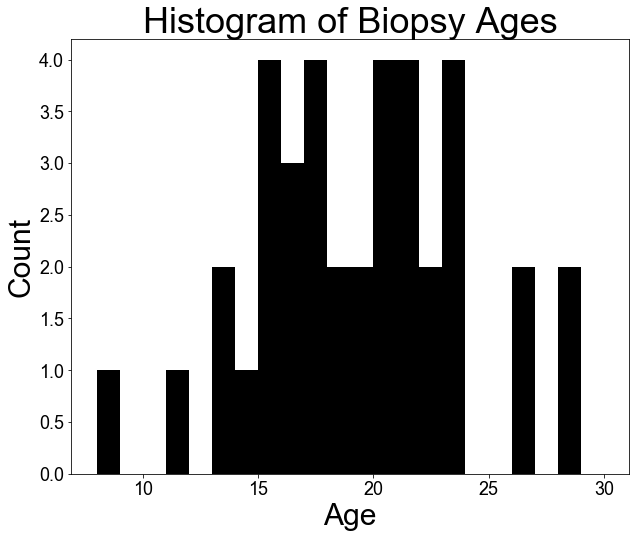

In [131]:
biopsy_age_prediction = biopsy_plate_ages_n69_10good_clock.iloc[0:36]

biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)

first_biopsy_ages_n69_10good_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, samp_69_10good_a07_clock)

first_biopsy_ages_n69_10good_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/first_biopsy_ages.csv')
first_biopsy_ages_n69_10good_clock

biopsy_age_prediction = biopsy_age_prediction.append(first_biopsy_ages_n69_10good_clock)

biopsy_age_prediction['integer_age'] = biopsy_age_prediction['model_age'].round(0)

biopsy_age_prediction.hist(column='integer_age', bins = 22, range = (8,30),histtype = 'bar', figsize=(10,8), color = 'Black', xlabelsize=18, 
                                 ylabelsize = 18)
plt.title('Histogram of Biopsy Ages', fontsize = 36)
plt.ylabel('Count',  fontsize = 30)
plt.xlabel('Age',  fontsize = 30)
plt.grid(b=None)

biopsy_age_prediction.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/estimated_biopsy_ages_n69_10good_clock.csv")
plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/biopsy_age_histogram_n69_10good_clock.eps')

In [127]:
biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)
#len(biopsy_df)

biopsy_ages_a05_reps_second_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, all_second_a05_clock)

biopsy_ages_a05_reps_second_clock

There are 54 cpgs in the current model


sampleID  model_age
0  MML_RA170902-B02  13.651758
1  MML_RA170903-B02  17.881192

In [128]:
biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)
#len(biopsy_df)

biopsy_ages_a08_reps_first_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, all_first_a08_clock)

biopsy_ages_a08_reps_first_clock

There are 22 cpgs in the current model


sampleID  model_age
0  MML_RA170902-B02  14.081716
1  MML_RA170903-B02  18.297310

In [90]:
biopsy_plate_sesame_beta_data_file = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_array_data/NormalizedData/sesame_normalized_biopsy_plate_LabIDs.csv'
new_biopsy_sesame_df = pd.read_csv(biopsy_plate_sesame_beta_data_file, sep = ',', index_col=0)
#new_biopsy_sesame_df

In [91]:
biopsy_plate_ages_a05_reps_second_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, all_second_a05_clock)

biopsy_plate_ages_a05_reps_second_clock.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_array_data/biopsy_age_estimation_05Dec2019.csv")

#biopsy_plate_ages_a05_reps_second_clock



There are 54 cpgs in the current model


In [96]:
ages_calibration_data_KBO_samp_69 = calculate_biopsy_ages(sesame_data_reps_second.columns, sesame_data_reps_second, all_KBO_samp_69_a05_clock)
ages_calibration_data_KBO_samp_69

There are 60 cpgs in the current model


sampleID  model_age
0        dleu_1335  17.599765
1        dleu_4195  23.828917
2        dleu_4360  18.888338
3        dleu_4361  18.450058
4        dleu_5316  23.257684
5        dleu_5381  22.933313
6        dleu_9798  26.783728
7        dleu_9799  26.190044
8        dleu_9800  18.757405
9       dleu_10918  17.342442
10      dleu_35279  24.411807
11      dleu_70583  46.386988
12       dleu_1336  35.024480
13       dleu_4107  24.819587
14       dleu_4108   3.324044
15       dleu_4109  19.686849
16       dleu_5428  27.842156
17      dleu_13507  18.850147
18      dleu_41732  10.416853
19      dleu_70581  30.202243
20      dleu_77292  11.938629
21     dleu_113072  15.144875
22  dleu_144309_13  38.983533
23     dleu_156874  22.394649
24     dleu_157255  22.370120
25       dleu_1572  21.179437
26       dleu_4196  27.466527
27       dleu_4359  26.267419
28       dleu_6001  27.793175
29       dleu_6002  15.847926
..             ...        ...
40      dleu_24819  17.473179
41      dleu_25493   9.153849
42      dleu_27937  25.419054
43      dleu_28944  22.175841
44      dleu_34577  20.945301
45      dleu_34578  11.755139
46      dleu_34579  19.780992
47      dleu_35278  34.067343
48      dleu_35280  20.021837
49      dleu_35281  14.774482
50      dleu_35344  22.396479
51      dleu_35345   1.950071
52      dleu_35853  25.732134
53      dleu_39050  23.492597
54   dleu_41745_07  21.770947
55      dleu_47973  29.999810
56      dleu_74693  30.370977
57      dleu_88661  18.532607
58      dleu_91065  15.015030
59      dleu_91066  27.549273
60      dleu_91067   8.243775
61     dleu_143907  38.053044
62     dleu_156870  39.208684
63     dleu_156873  36.036151
64      dleu_16605  12.748280
65   dleu_25494_16  21.054208
66   dleu_25495_16   2.013741
67   dleu_79633_13  36.770969
68    dleu_28926_B  22.760994
69    dleu_32512_B   0.680441

[70 rows x 2 columns]

In [94]:
ages_calibration_data_68limited = calculate_biopsy_ages(sesame_data_reps_second.columns, sesame_data_reps_second, all_68limited_a05_clock)
#ages_calibration_data_68limited

NameError: name 'all_68limited_a05_clock' is not defined

In [100]:
#Calculate biopsy ages using the new clock = KBO sample 69

biopsy_plate_ages_a05_KBO_samp_69_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, all_KBO_samp_69_a05_clock)
biopsy_plate_ages_a05_KBO_samp_69_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/biopsy_plate_ages_60cpg_clock.csv')

biopsy_plate_ages_a05_KBO_samp_69_clock


There are 60 cpgs in the current model


sampleID  model_age
0        Dleu17CI02  18.562778
1        Dleu17CI04  18.111865
2        Dleu17CI05  13.744118
3        Dleu17CI06  16.709713
4        Dleu17CI07  23.026523
5        Dleu17CI08  29.007873
6        Dleu17CI09  11.609932
7        Dleu17CI10  22.850601
8        Dleu17CI11  19.484327
9        Dleu17CI12  22.530982
10       Dleu17CI13  15.182567
11       Dleu16CI01  14.175996
12       Dleu16CI02  17.971880
13       Dleu16CI03  15.318822
14       Dleu16CI04  22.485895
15       Dleu16CI05  23.628666
16       Dleu18CI01  14.652411
17       Dleu18CI02  13.446496
18       Dleu18CI03  13.462588
19       Dleu18CI04  26.447254
20       Dleu18CI05  21.692691
21       Dleu18CI06  20.933083
22       Dleu18CI07  18.914703
23       Dleu18CI08  21.523524
24       Dleu18CI09  19.655771
25       Dleu18CI10  28.453528
26       Dleu18CI11  18.799973
27       Dleu18CI12  17.642474
28       Dleu18CI13   8.933344
29       Dleu18CI14  11.860423
30       Dleu18CI15  15.087135
31       Dleu18CI16  12.088364
32       Dleu18CI17  22.434659
33       Dleu18CI18  27.524029
34       Dleu18CI19  20.651284
35       Dleu18CI20  18.609116
36       Dleu18CI21  13.111956
37    Dleu_4196_KBO  24.613268
38    Dleu_9799_KBO  28.221082
39   Dleu_17861_KBO  21.192595
40   Dleu_28926_KBO  17.262987
41   Dleu_34579_KBO  20.655053
42  Dleu_35278_KBO   37.289961
43   Dleu_35281_KBO  25.923998
44   Dleu_79633_KBO  36.603980
45  Dleu_143907_KBO  24.384107
46       Chem18NZ02  11.151989
47       Chem18NZ04   2.287449

In [161]:
#Calculate biopsy ages using the new clock = KBO sample 69

biopsy_plate_ages_a05_mapped_KBO_samp_69_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, mapped_KBO_samp_69_a05_clock)
biopsy_plate_ages_a05_KBO_samp_69_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/biopsy_plate_ages_mapped_KBO_69_clock.csv')

biopsy_plate_ages_a05_mapped_KBO_samp_69_clock


There are 28 cpgs in the current model


sampleID  model_age
0        Dleu17CI02  18.765552
1        Dleu17CI04  20.214504
2        Dleu17CI05  20.522250
3        Dleu17CI06  17.320565
4        Dleu17CI07  24.974484
5        Dleu17CI08  29.067134
6        Dleu17CI09  13.050359
7        Dleu17CI10  25.089372
8        Dleu17CI11  22.506557
9        Dleu17CI12  24.976939
10       Dleu17CI13  17.233407
11       Dleu16CI01  16.018146
12       Dleu16CI02  21.972381
13       Dleu16CI03  18.384099
14       Dleu16CI04  24.141061
15       Dleu16CI05  23.567111
16       Dleu18CI01  17.381484
17       Dleu18CI02  17.903317
18       Dleu18CI03  17.326516
19       Dleu18CI04  27.766683
20       Dleu18CI05  23.433131
21       Dleu18CI06  22.498816
22       Dleu18CI07  22.079751
23       Dleu18CI08  21.494155
24       Dleu18CI09  22.573975
25       Dleu18CI10  29.204972
26       Dleu18CI11  20.822808
27       Dleu18CI12  18.344929
28       Dleu18CI13  11.625997
29       Dleu18CI14  19.470223
30       Dleu18CI15  18.066115
31       Dleu18CI16  15.347142
32       Dleu18CI17  25.974501
33       Dleu18CI18  28.416626
34       Dleu18CI19  23.547768
35       Dleu18CI20  21.644596
36       Dleu18CI21  16.998043
37    Dleu_4196_KBO  26.613459
38    Dleu_9799_KBO  30.315142
39   Dleu_17861_KBO  23.139254
40   Dleu_28926_KBO  18.991908
41   Dleu_34579_KBO  23.125669
42  Dleu_35278_KBO   37.800635
43   Dleu_35281_KBO  27.173905
44   Dleu_79633_KBO  36.499909
45  Dleu_143907_KBO  26.640270
46       Chem18NZ02  19.876988
47       Chem18NZ04   5.221997

There are 60 cpgs in the current model


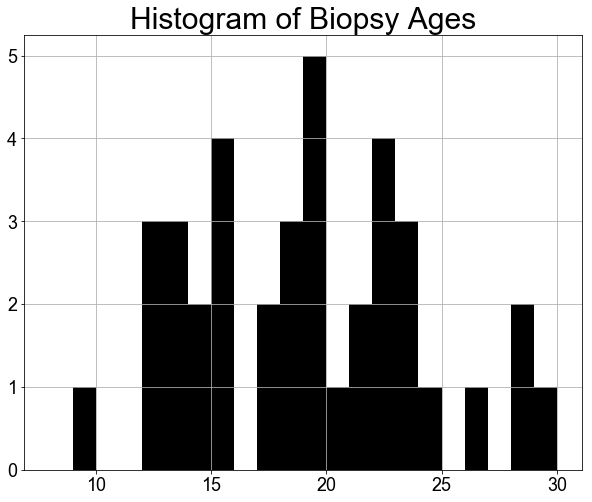

In [145]:
biopsy_age_prediction = biopsy_plate_ages_a05_KBO_samp_69_clock.iloc[0:36]


biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)

first_biopsy_ages_a05_KBO_samp_69_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, all_KBO_samp_69_a05_clock)

first_biopsy_ages_a05_KBO_samp_69_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/first_biopsy_ages.csv')
first_biopsy_ages_a05_KBO_samp_69_clock

biopsy_age_prediction = biopsy_age_prediction.append(first_biopsy_ages_a05_KBO_samp_69_clock)

biopsy_age_prediction['integer_age'] = biopsy_age_prediction['model_age'].round(0)

biopsy_age_prediction.hist(column='integer_age', bins = 22, range = (8,30),histtype = 'bar', figsize=(10,8), color = 'Black', xlabelsize=18, 
                                 ylabelsize = 18)
plt.title('Histogram of Biopsy Ages', fontsize = 30)

biopsy_age_prediction.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/estimated_biopsy_ages_60CpG_clock.csv")
plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/biopsy_age_histogram.pdf')

There are 28 cpgs in the current model


Text(0.5,1,'Histogram of Biopsy Ages')

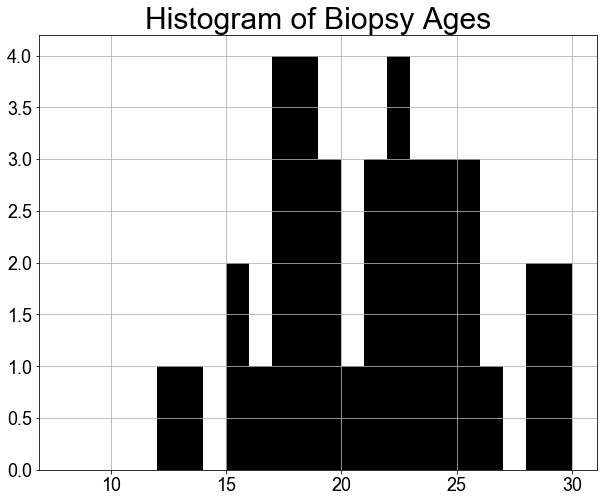

In [166]:
biopsy_age_prediction = biopsy_plate_ages_a05_mapped_KBO_samp_69_clock.iloc[0:36]


biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)

first_biopsy_ages_mapped_a05_KBO_samp_69_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, mapped_KBO_samp_69_a05_clock)

first_biopsy_ages_mapped_a05_KBO_samp_69_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/first_biopsy_ages.csv')
first_biopsy_ages_mapped_a05_KBO_samp_69_clock

biopsy_age_prediction = biopsy_age_prediction.append(first_biopsy_ages_mapped_a05_KBO_samp_69_clock)

biopsy_age_prediction['integer_age'] = biopsy_age_prediction['model_age'].round(0)

biopsy_age_prediction.hist(column='integer_age', bins = 22, range = (8,30),histtype = 'bar', figsize=(10,8), color = 'Black', xlabelsize=18, 
                                 ylabelsize = 18)
plt.title('Histogram of Biopsy Ages', fontsize = 30)

#biopsy_age_prediction.to_csv("/Users/elliebors/Desktop/Beluga/methylation_array/analysis/estimated_biopsy_ages_60CpG_clock.csv")
#plt.savefig('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/biopsy_age_histogram.pdf')

In [99]:

biopsy_data_filepath = '/Users/elliebors/Desktop/Beluga/methylation_array/data/biopsy_betas_sesame_18Nov2019.csv'

biopsy_df = pd.read_csv(biopsy_data_filepath, sep = ',', index_col=0)

first_biopsy_ages_a05_KBO_samp_69_clock = calculate_biopsy_ages(biopsy_df.columns, biopsy_df, all_KBO_samp_69_a05_clock)

first_biopsy_ages_a05_KBO_samp_69_clock.to_csv('/Users/elliebors/Desktop/Beluga/methylation_array/analysis/clock_building/first_biopsy_ages.csv')
first_biopsy_ages_a05_KBO_samp_69_clock


There are 60 cpgs in the current model


sampleID  model_age
0  MML_RA170902-B02  12.929827
1  MML_RA170903-B02  16.820679

In [138]:
biopsy_plate_ages_a05_68limited_clock = calculate_biopsy_ages(new_biopsy_sesame_df.columns, new_biopsy_sesame_df, all_68limited_a05_clock)
biopsy_plate_ages_a05_68limited_clock


There are 49 cpgs in the current model


sampleID  model_age
0        Dleu17CI02  18.784995
1        Dleu17CI04  18.463090
2        Dleu17CI05  15.020455
3        Dleu17CI06  17.264911
4        Dleu17CI07  23.653078
5        Dleu17CI08  29.160444
6        Dleu17CI09  11.904065
7        Dleu17CI10  23.637872
8        Dleu17CI11  20.571339
9        Dleu17CI12  22.961955
10       Dleu17CI13  15.601114
11       Dleu16CI01  14.559323
12       Dleu16CI02  18.936009
13       Dleu16CI03  15.931977
14       Dleu16CI04  22.737530
15       Dleu16CI05  23.318857
16       Dleu18CI01  14.957628
17       Dleu18CI02  14.661377
18       Dleu18CI03  14.423618
19       Dleu18CI04  26.409778
20       Dleu18CI05  21.345561
21       Dleu18CI06  20.902482
22       Dleu18CI07  19.916655
23       Dleu18CI08  21.501303
24       Dleu18CI09  20.412697
25       Dleu18CI10  28.501627
26       Dleu18CI11  19.044803
27       Dleu18CI12  17.295516
28       Dleu18CI13   9.689657
29       Dleu18CI14  13.543479
30       Dleu18CI15  15.486988
31       Dleu18CI16  12.617499
32       Dleu18CI17  23.216473
33       Dleu18CI18  27.518838
34       Dleu18CI19  21.046197
35       Dleu18CI20  18.990929
36       Dleu18CI21  13.766783
37    Dleu_4196_KBO  24.607579
38    Dleu_9799_KBO  28.380066
39   Dleu_17861_KBO  21.393989
40   Dleu_28926_KBO  17.520627
41   Dleu_34579_KBO  21.630214
42  Dleu_35278_KBO   37.211170
43   Dleu_35281_KBO  25.744053
44   Dleu_79633_KBO  36.404648
45  Dleu_143907_KBO  24.253062
46       Chem18NZ02  11.028568
47       Chem18NZ04   1.912900